In [1]:
#Checking paths to executable and libs for installing modules directly into this environment
import os, sys
print(sys.executable)
print(sys.path)

C:\Users\Andrew\anaconda3\envs\gpu2\python.exe
['C:\\Users\\Andrew\\OneDrive\\Documentos\\Pessoal\\Projetos\\Reinforcement_Learning\\RL_Mario', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\python38.zip', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\DLLs', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\lib', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2', '', 'C:\\Users\\Andrew\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\lib\\site-packages', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\lib\\site-packages\\win32', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Andrew\\anaconda3\\envs\\gpu2\\lib\\site-packages\\Pythonwin']


In [3]:
#Making sure the GPU is being recognized
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7092520247042824936
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15521732612306037097
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
#Using the path to the environment python to install the dependencies into this one
!C:\Users\Andrew\anaconda3\envs\gpu2\python.exe -m pip install gym-super-mario-bros==7.3.0 nes_py

In [5]:
#Install Pytorch
!C:\Users\Andrew\anaconda3\envs\gpu2\python.exe -m pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [6]:
#Install stable baselines for RL Stuff
!C:\Users\Andrew\anaconda3\envs\gpu2\python.exe -m pip install stable-baselines3[extra]

In [7]:
!C:\Users\Andrew\anaconda3\envs\gpu2\python.exe -m pip install gym==0.21.0

In [1]:
#Import the game
import gym_super_mario_bros
#Import the joypad wrapper
from nes_py.wrappers import JoypadSpace
#Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
#Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [11]:
env.reset()
env.step(env.action_space.sample())

(array([[[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        ...,
 
        [[240, 208, 176],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [228,  92,  16],
         [  0,   0,   0]],
 
        [[240, 208, 176],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[228,  92,  16],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

In [12]:
#Test if we can run the game
done = True
for step in range(100000):
    if done:
        env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

C:\Users\Andrew\anaconda3\envs\gpu2\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [13]:
#Close because it takes too long to finish
env.close()

In [3]:
#Import Fram Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
#Import Vectorizing Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
#Import matplotlib
from matplotlib import pyplot as plt

In [21]:
#Create the base envinronment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#Gray scale
env = GrayScaleObservation(env, keep_dim=True)
#Wrap inside dummy env
env = DummyVecEnv([lambda:env])
#Stack the frames
env = VecFrameStack(env, 4, channels_order="last")

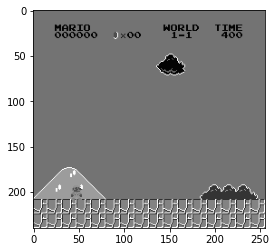

In [5]:
#show image of current state with matplotlib
plt.imshow(env.reset()[0])

In [22]:
#Import os for file path management
import os
#Import  PPO for algos
from stable_baselines3 import PPO
#Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [23]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [24]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [25]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [21]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
#Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=5000000, callback=callback)

Logging to ./logs/PPO_1


C:\Users\Andrew\anaconda3\envs\gpu2\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 79  |
|    iterations      | 1   |
|    time_elapsed    | 6   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 90            |
|    iterations           | 2             |
|    time_elapsed         | 11            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.7783215e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00742      |
|    learning_rate        | 1e-06         |
|    loss                 | 149           |
|    n_updates            | 10            |
|    policy_gradient_loss | -9.7e-05      |
|    value_loss           | 387           |
-------------------------------------------
-----

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 13           |
|    time_elapsed         | 70           |
|    total_timesteps      | 6656         |
| train/                  |              |
|    approx_kl            | 2.401718e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.00857      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.149        |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000417    |
|    value_loss           | 0.272        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 14            |
|    time_elapsed         | 75            |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 24           |
|    time_elapsed         | 129          |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 9.487732e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.00486      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.174        |
|    n_updates            | 230          |
|    policy_gradient_loss | -6.13e-05    |
|    value_loss           | 0.493        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 25            |
|    time_elapsed         | 134           |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 35            |
|    time_elapsed         | 188           |
|    total_timesteps      | 17920         |
| train/                  |               |
|    approx_kl            | 2.4028239e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.94         |
|    explained_variance   | 0.323         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.105         |
|    n_updates            | 340           |
|    policy_gradient_loss | -9.92e-05     |
|    value_loss           | 0.441         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 36            |
|    time_elapsed         | 193 

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 46            |
|    time_elapsed         | 247           |
|    total_timesteps      | 23552         |
| train/                  |               |
|    approx_kl            | 5.5541517e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.93         |
|    explained_variance   | 0.0917        |
|    learning_rate        | 1e-06         |
|    loss                 | 41.2          |
|    n_updates            | 450           |
|    policy_gradient_loss | -0.000206     |
|    value_loss           | 77.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 47           |
|    time_elapsed         | 253     

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 57            |
|    time_elapsed         | 306           |
|    total_timesteps      | 29184         |
| train/                  |               |
|    approx_kl            | 7.3932926e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.92         |
|    explained_variance   | 0.0991        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0663        |
|    n_updates            | 560           |
|    policy_gradient_loss | -0.000354     |
|    value_loss           | 0.22          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 58           |
|    time_elapsed         | 311     

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 68           |
|    time_elapsed         | 365          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 2.513046e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.91        |
|    explained_variance   | 0.301        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.119        |
|    n_updates            | 670          |
|    policy_gradient_loss | -3.76e-05    |
|    value_loss           | 0.824        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 69            |
|    time_elapsed         | 371           |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 79           |
|    time_elapsed         | 425          |
|    total_timesteps      | 40448        |
| train/                  |              |
|    approx_kl            | 9.488873e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.91        |
|    explained_variance   | 0.498        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0636       |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000497    |
|    value_loss           | 0.191        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 80           |
|    time_elapsed         | 430          |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 90            |
|    time_elapsed         | 484           |
|    total_timesteps      | 46080         |
| train/                  |               |
|    approx_kl            | 0.00020084134 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.89         |
|    explained_variance   | 0.269         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0631        |
|    n_updates            | 890           |
|    policy_gradient_loss | -0.00094      |
|    value_loss           | 0.254         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 91           |
|    time_elapsed         | 489     

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 101           |
|    time_elapsed         | 543           |
|    total_timesteps      | 51712         |
| train/                  |               |
|    approx_kl            | 3.3494085e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.87         |
|    explained_variance   | 0.00892       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.15          |
|    n_updates            | 1000          |
|    policy_gradient_loss | -0.000119     |
|    value_loss           | 0.404         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 102          |
|    time_elapsed         | 549     

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 112          |
|    time_elapsed         | 602          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0031940648 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |
|    explained_variance   | 0.176        |
|    learning_rate        | 1e-06        |
|    loss                 | 194          |
|    n_updates            | 1110         |
|    policy_gradient_loss | 0.000964     |
|    value_loss           | 491          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 113          |
|    time_elapsed         | 608          |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 123           |
|    time_elapsed         | 662           |
|    total_timesteps      | 62976         |
| train/                  |               |
|    approx_kl            | 0.00026861008 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.8          |
|    explained_variance   | -0.03         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.112         |
|    n_updates            | 1220          |
|    policy_gradient_loss | -0.00106      |
|    value_loss           | 0.431         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 124           |
|    time_elapsed         | 667 

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 134         |
|    time_elapsed         | 721         |
|    total_timesteps      | 68608       |
| train/                  |             |
|    approx_kl            | 0.000149508 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.0178     |
|    learning_rate        | 1e-06       |
|    loss                 | 0.0847      |
|    n_updates            | 1330        |
|    policy_gradient_loss | -0.000244   |
|    value_loss           | 0.594       |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 135           |
|    time_elapsed         | 726           |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 145         |
|    time_elapsed         | 781         |
|    total_timesteps      | 74240       |
| train/                  |             |
|    approx_kl            | 0.004637247 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.253       |
|    learning_rate        | 1e-06       |
|    loss                 | 181         |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.00288    |
|    value_loss           | 499         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 146           |
|    time_elapsed         | 786           |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 156          |
|    time_elapsed         | 840          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0008977045 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.53        |
|    explained_variance   | 0.159        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.198        |
|    n_updates            | 1550         |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 16.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 157          |
|    time_elapsed         | 846          |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 167           |
|    time_elapsed         | 899           |
|    total_timesteps      | 85504         |
| train/                  |               |
|    approx_kl            | 0.00022047712 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.67         |
|    explained_variance   | -0.0327       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0497        |
|    n_updates            | 1660          |
|    policy_gradient_loss | -0.000723     |
|    value_loss           | 0.202         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 168          |
|    time_elapsed         | 904     

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 178          |
|    time_elapsed         | 959          |
|    total_timesteps      | 91136        |
| train/                  |              |
|    approx_kl            | 6.896141e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 0.00729      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0975       |
|    n_updates            | 1770         |
|    policy_gradient_loss | 0.000552     |
|    value_loss           | 0.891        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 179           |
|    time_elapsed         | 964           |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 189           |
|    time_elapsed         | 1018          |
|    total_timesteps      | 96768         |
| train/                  |               |
|    approx_kl            | 0.00047624833 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.58         |
|    explained_variance   | 0.0395        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.105         |
|    n_updates            | 1880          |
|    policy_gradient_loss | -0.00099      |
|    value_loss           | 2.1           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 190          |
|    time_elapsed         | 1024    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 200           |
|    time_elapsed         | 1077          |
|    total_timesteps      | 102400        |
| train/                  |               |
|    approx_kl            | 0.00042966136 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.51         |
|    explained_variance   | 0.0294        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.176         |
|    n_updates            | 1990          |
|    policy_gradient_loss | 0.00133       |
|    value_loss           | 6.69          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 201           |
|    time_elapsed         | 1082

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 211          |
|    time_elapsed         | 1137         |
|    total_timesteps      | 108032       |
| train/                  |              |
|    approx_kl            | 0.0042601703 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.197        |
|    learning_rate        | 1e-06        |
|    loss                 | 156          |
|    n_updates            | 2100         |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 443          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 212           |
|    time_elapsed         | 1142          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 222           |
|    time_elapsed         | 1196          |
|    total_timesteps      | 113664        |
| train/                  |               |
|    approx_kl            | 0.00044280663 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.65         |
|    explained_variance   | -0.0906       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0562        |
|    n_updates            | 2210          |
|    policy_gradient_loss | -0.00117      |
|    value_loss           | 0.223         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 223           |
|    time_elapsed         | 1201

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 233           |
|    time_elapsed         | 1255          |
|    total_timesteps      | 119296        |
| train/                  |               |
|    approx_kl            | 0.00021902996 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.63         |
|    explained_variance   | -0.0217       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0773        |
|    n_updates            | 2320          |
|    policy_gradient_loss | -0.000511     |
|    value_loss           | 0.246         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 234           |
|    time_elapsed         | 1260

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 244           |
|    time_elapsed         | 1314          |
|    total_timesteps      | 124928        |
| train/                  |               |
|    approx_kl            | 0.00014000677 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.56         |
|    explained_variance   | -0.0345       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.144         |
|    n_updates            | 2430          |
|    policy_gradient_loss | -2.64e-05     |
|    value_loss           | 1.04          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 245           |
|    time_elapsed         | 1319

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 255           |
|    time_elapsed         | 1373          |
|    total_timesteps      | 130560        |
| train/                  |               |
|    approx_kl            | 0.00090409326 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.63         |
|    explained_variance   | -0.0627       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0496        |
|    n_updates            | 2540          |
|    policy_gradient_loss | -0.00179      |
|    value_loss           | 0.147         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 256           |
|    time_elapsed         | 1378

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 266           |
|    time_elapsed         | 1431          |
|    total_timesteps      | 136192        |
| train/                  |               |
|    approx_kl            | 0.00021517137 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.6          |
|    explained_variance   | -0.0245       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0605        |
|    n_updates            | 2650          |
|    policy_gradient_loss | -0.000459     |
|    value_loss           | 0.174         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 267          |
|    time_elapsed         | 1436    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 277           |
|    time_elapsed         | 1489          |
|    total_timesteps      | 141824        |
| train/                  |               |
|    approx_kl            | 0.00034740008 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.57         |
|    explained_variance   | 0.0119        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0513        |
|    n_updates            | 2760          |
|    policy_gradient_loss | -0.00069      |
|    value_loss           | 0.595         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 278           |
|    time_elapsed         | 1494

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 288          |
|    time_elapsed         | 1547         |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0018748795 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.56        |
|    explained_variance   | -0.00934     |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0284       |
|    n_updates            | 2870         |
|    policy_gradient_loss | -0.00285     |
|    value_loss           | 0.104        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 289           |
|    time_elapsed         | 1552          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 299           |
|    time_elapsed         | 1606          |
|    total_timesteps      | 153088        |
| train/                  |               |
|    approx_kl            | 0.00022737321 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.51         |
|    explained_variance   | 0.000428      |
|    learning_rate        | 1e-06         |
|    loss                 | 0.144         |
|    n_updates            | 2980          |
|    policy_gradient_loss | -0.000423     |
|    value_loss           | 0.38          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 300          |
|    time_elapsed         | 1611    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 310          |
|    time_elapsed         | 1663         |
|    total_timesteps      | 158720       |
| train/                  |              |
|    approx_kl            | 0.0009537954 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.212        |
|    learning_rate        | 1e-06        |
|    loss                 | 150          |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.00271     |
|    value_loss           | 318          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 311           |
|    time_elapsed         | 1669          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 321          |
|    time_elapsed         | 1722         |
|    total_timesteps      | 164352       |
| train/                  |              |
|    approx_kl            | 0.0006397747 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | -0.0786      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.0766       |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.000624    |
|    value_loss           | 0.206        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 322           |
|    time_elapsed         | 1727          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 332          |
|    time_elapsed         | 1779         |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0007323987 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | -0.00524     |
|    learning_rate        | 1e-06        |
|    loss                 | 0.308        |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.000528    |
|    value_loss           | 4.89         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 333          |
|    time_elapsed         | 1784         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 343          |
|    time_elapsed         | 1837         |
|    total_timesteps      | 175616       |
| train/                  |              |
|    approx_kl            | 0.0003406927 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.00776      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.257        |
|    n_updates            | 3420         |
|    policy_gradient_loss | -0.000417    |
|    value_loss           | 2.16         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 344         |
|    time_elapsed         | 1843        |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 354           |
|    time_elapsed         | 1896          |
|    total_timesteps      | 181248        |
| train/                  |               |
|    approx_kl            | 0.00010677485 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.14         |
|    explained_variance   | -0.117        |
|    learning_rate        | 1e-06         |
|    loss                 | 143           |
|    n_updates            | 3530          |
|    policy_gradient_loss | -1.66e-05     |
|    value_loss           | 239           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 355          |
|    time_elapsed         | 1900    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 365           |
|    time_elapsed         | 1954          |
|    total_timesteps      | 186880        |
| train/                  |               |
|    approx_kl            | 6.0296035e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.615        |
|    explained_variance   | 0.179         |
|    learning_rate        | 1e-06         |
|    loss                 | 466           |
|    n_updates            | 3640          |
|    policy_gradient_loss | 2.31e-05      |
|    value_loss           | 664           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 366          |
|    time_elapsed         | 1959    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 376           |
|    time_elapsed         | 2013          |
|    total_timesteps      | 192512        |
| train/                  |               |
|    approx_kl            | 1.1409982e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.522        |
|    explained_variance   | -0.0121       |
|    learning_rate        | 1e-06         |
|    loss                 | 263           |
|    n_updates            | 3750          |
|    policy_gradient_loss | -0.000131     |
|    value_loss           | 969           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 377         |
|    time_elapsed         | 2019        

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 387          |
|    time_elapsed         | 2073         |
|    total_timesteps      | 198144       |
| train/                  |              |
|    approx_kl            | 0.0015833422 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.527       |
|    explained_variance   | 0.261        |
|    learning_rate        | 1e-06        |
|    loss                 | 143          |
|    n_updates            | 3860         |
|    policy_gradient_loss | -0.00187     |
|    value_loss           | 295          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 388          |
|    time_elapsed         | 2078         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 398          |
|    time_elapsed         | 2133         |
|    total_timesteps      | 203776       |
| train/                  |              |
|    approx_kl            | 0.0018842233 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.582       |
|    explained_variance   | 0.417        |
|    learning_rate        | 1e-06        |
|    loss                 | 116          |
|    n_updates            | 3970         |
|    policy_gradient_loss | -0.000252    |
|    value_loss           | 217          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 399          |
|    time_elapsed         | 2138         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 409           |
|    time_elapsed         | 2192          |
|    total_timesteps      | 209408        |
| train/                  |               |
|    approx_kl            | 0.00021242863 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.685        |
|    explained_variance   | 0.214         |
|    learning_rate        | 1e-06         |
|    loss                 | 246           |
|    n_updates            | 4080          |
|    policy_gradient_loss | -0.000253     |
|    value_loss           | 794           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 410          |
|    time_elapsed         | 2198    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 420          |
|    time_elapsed         | 2252         |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 0.0076152324 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.803       |
|    explained_variance   | 0.306        |
|    learning_rate        | 1e-06        |
|    loss                 | 259          |
|    n_updates            | 4190         |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 650          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 421          |
|    time_elapsed         | 2258         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 431          |
|    time_elapsed         | 2312         |
|    total_timesteps      | 220672       |
| train/                  |              |
|    approx_kl            | 0.0011184012 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.619       |
|    explained_variance   | 0.651        |
|    learning_rate        | 1e-06        |
|    loss                 | 168          |
|    n_updates            | 4300         |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 345          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 432          |
|    time_elapsed         | 2317         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 442          |
|    time_elapsed         | 2371         |
|    total_timesteps      | 226304       |
| train/                  |              |
|    approx_kl            | 0.0062553417 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.768       |
|    explained_variance   | 0.482        |
|    learning_rate        | 1e-06        |
|    loss                 | 147          |
|    n_updates            | 4410         |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 299          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 443          |
|    time_elapsed         | 2376         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 453          |
|    time_elapsed         | 2430         |
|    total_timesteps      | 231936       |
| train/                  |              |
|    approx_kl            | 0.0032506252 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.806       |
|    explained_variance   | 0.714        |
|    learning_rate        | 1e-06        |
|    loss                 | 166          |
|    n_updates            | 4520         |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 305          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 454          |
|    time_elapsed         | 2436         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 464           |
|    time_elapsed         | 2489          |
|    total_timesteps      | 237568        |
| train/                  |               |
|    approx_kl            | 0.00012484402 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.901        |
|    explained_variance   | 0.451         |
|    learning_rate        | 1e-06         |
|    loss                 | 349           |
|    n_updates            | 4630          |
|    policy_gradient_loss | 9.82e-05      |
|    value_loss           | 664           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 465          |
|    time_elapsed         | 2495    

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 475         |
|    time_elapsed         | 2549        |
|    total_timesteps      | 243200      |
| train/                  |             |
|    approx_kl            | 0.001212933 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.892      |
|    explained_variance   | 0.69        |
|    learning_rate        | 1e-06       |
|    loss                 | 173         |
|    n_updates            | 4740        |
|    policy_gradient_loss | -0.000667   |
|    value_loss           | 302         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 476          |
|    time_elapsed         | 2555         |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 486         |
|    time_elapsed         | 2609        |
|    total_timesteps      | 248832      |
| train/                  |             |
|    approx_kl            | 0.008433858 |
|    clip_fraction        | 0.00156     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.897      |
|    explained_variance   | 0.809       |
|    learning_rate        | 1e-06       |
|    loss                 | 103         |
|    n_updates            | 4850        |
|    policy_gradient_loss | -0.00497    |
|    value_loss           | 230         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 487          |
|    time_elapsed         | 2615         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 497          |
|    time_elapsed         | 2668         |
|    total_timesteps      | 254464       |
| train/                  |              |
|    approx_kl            | 0.0016609553 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.839       |
|    explained_variance   | 0.601        |
|    learning_rate        | 1e-06        |
|    loss                 | 92.6         |
|    n_updates            | 4960         |
|    policy_gradient_loss | -0.000502    |
|    value_loss           | 461          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 498          |
|    time_elapsed         | 2674         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 508          |
|    time_elapsed         | 2728         |
|    total_timesteps      | 260096       |
| train/                  |              |
|    approx_kl            | 0.0010332137 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.791       |
|    explained_variance   | 0.744        |
|    learning_rate        | 1e-06        |
|    loss                 | 183          |
|    n_updates            | 5070         |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 332          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 509         |
|    time_elapsed         | 2734        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 519         |
|    time_elapsed         | 2788        |
|    total_timesteps      | 265728      |
| train/                  |             |
|    approx_kl            | 0.003410494 |
|    clip_fraction        | 0.00273     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.881      |
|    explained_variance   | 0.378       |
|    learning_rate        | 1e-06       |
|    loss                 | 73.1        |
|    n_updates            | 5180        |
|    policy_gradient_loss | -0.00175    |
|    value_loss           | 272         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 520          |
|    time_elapsed         | 2793         |
|    total_timesteps      | 2

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 530           |
|    time_elapsed         | 2847          |
|    total_timesteps      | 271360        |
| train/                  |               |
|    approx_kl            | 0.00022314629 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.936        |
|    explained_variance   | 0.623         |
|    learning_rate        | 1e-06         |
|    loss                 | 124           |
|    n_updates            | 5290          |
|    policy_gradient_loss | -7.5e-05      |
|    value_loss           | 435           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 531          |
|    time_elapsed         | 2853    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 541          |
|    time_elapsed         | 2907         |
|    total_timesteps      | 276992       |
| train/                  |              |
|    approx_kl            | 0.0023997934 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.859       |
|    explained_variance   | 0.216        |
|    learning_rate        | 1e-06        |
|    loss                 | 277          |
|    n_updates            | 5400         |
|    policy_gradient_loss | -0.00248     |
|    value_loss           | 674          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 542         |
|    time_elapsed         | 2913        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 552         |
|    time_elapsed         | 2967        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.010697208 |
|    clip_fraction        | 0.00391     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.907      |
|    explained_variance   | 0.65        |
|    learning_rate        | 1e-06       |
|    loss                 | 129         |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.00384    |
|    value_loss           | 287         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 553          |
|    time_elapsed         | 2972         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 563          |
|    time_elapsed         | 3027         |
|    total_timesteps      | 288256       |
| train/                  |              |
|    approx_kl            | 0.0013062885 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.812       |
|    explained_variance   | 0.573        |
|    learning_rate        | 1e-06        |
|    loss                 | 307          |
|    n_updates            | 5620         |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 651          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 564          |
|    time_elapsed         | 3032         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 574          |
|    time_elapsed         | 3087         |
|    total_timesteps      | 293888       |
| train/                  |              |
|    approx_kl            | 0.0021636426 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.857       |
|    explained_variance   | 0.332        |
|    learning_rate        | 1e-06        |
|    loss                 | 99           |
|    n_updates            | 5730         |
|    policy_gradient_loss | -0.000875    |
|    value_loss           | 286          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 575          |
|    time_elapsed         | 3093         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 585         |
|    time_elapsed         | 3151        |
|    total_timesteps      | 299520      |
| train/                  |             |
|    approx_kl            | 7.33895e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.798      |
|    explained_variance   | 0.889       |
|    learning_rate        | 1e-06       |
|    loss                 | 68.5        |
|    n_updates            | 5840        |
|    policy_gradient_loss | -8.62e-05   |
|    value_loss           | 178         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 586           |
|    time_elapsed         | 3157          |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 596         |
|    time_elapsed         | 3214        |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.001990093 |
|    clip_fraction        | 0.000195    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.841      |
|    explained_variance   | 0.327       |
|    learning_rate        | 1e-06       |
|    loss                 | 162         |
|    n_updates            | 5950        |
|    policy_gradient_loss | -0.00207    |
|    value_loss           | 838         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 597           |
|    time_elapsed         | 3220          |
|    total_timesteps    

--------------------------------------------
| time/                   |                |
|    fps                  | 94             |
|    iterations           | 607            |
|    time_elapsed         | 3274           |
|    total_timesteps      | 310784         |
| train/                  |                |
|    approx_kl            | 0.000102541526 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.02          |
|    explained_variance   | 0.5            |
|    learning_rate        | 1e-06          |
|    loss                 | 76.2           |
|    n_updates            | 6060           |
|    policy_gradient_loss | 6.76e-05       |
|    value_loss           | 189            |
--------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 608         |
|    time_elapsed     

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 618           |
|    time_elapsed         | 3335          |
|    total_timesteps      | 316416        |
| train/                  |               |
|    approx_kl            | 0.00012306962 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.922        |
|    explained_variance   | 0.759         |
|    learning_rate        | 1e-06         |
|    loss                 | 113           |
|    n_updates            | 6170          |
|    policy_gradient_loss | 0.000109      |
|    value_loss           | 382           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 619          |
|    time_elapsed         | 3341    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 629          |
|    time_elapsed         | 3398         |
|    total_timesteps      | 322048       |
| train/                  |              |
|    approx_kl            | 0.0013728192 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.999       |
|    explained_variance   | 0.841        |
|    learning_rate        | 1e-06        |
|    loss                 | 74.5         |
|    n_updates            | 6280         |
|    policy_gradient_loss | -0.00155     |
|    value_loss           | 240          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 630         |
|    time_elapsed         | 3403        |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 640           |
|    time_elapsed         | 3457          |
|    total_timesteps      | 327680        |
| train/                  |               |
|    approx_kl            | 4.5651454e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.873        |
|    explained_variance   | 0.91          |
|    learning_rate        | 1e-06         |
|    loss                 | 155           |
|    n_updates            | 6390          |
|    policy_gradient_loss | -7.92e-05     |
|    value_loss           | 186           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 641         |
|    time_elapsed         | 3462        

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 651          |
|    time_elapsed         | 3516         |
|    total_timesteps      | 333312       |
| train/                  |              |
|    approx_kl            | 0.0014963564 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.706       |
|    explained_variance   | 0.7          |
|    learning_rate        | 1e-06        |
|    loss                 | 301          |
|    n_updates            | 6500         |
|    policy_gradient_loss | -0.00238     |
|    value_loss           | 432          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 652           |
|    time_elapsed         | 3522          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 662           |
|    time_elapsed         | 3575          |
|    total_timesteps      | 338944        |
| train/                  |               |
|    approx_kl            | 0.00066167046 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.694        |
|    explained_variance   | 0.934         |
|    learning_rate        | 1e-06         |
|    loss                 | 69.4          |
|    n_updates            | 6610          |
|    policy_gradient_loss | -0.000575     |
|    value_loss           | 192           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 663          |
|    time_elapsed         | 3580    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 673          |
|    time_elapsed         | 3634         |
|    total_timesteps      | 344576       |
| train/                  |              |
|    approx_kl            | 0.0011505294 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.723       |
|    explained_variance   | 0.832        |
|    learning_rate        | 1e-06        |
|    loss                 | 152          |
|    n_updates            | 6720         |
|    policy_gradient_loss | -0.0013      |
|    value_loss           | 335          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 674           |
|    time_elapsed         | 3639          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 684           |
|    time_elapsed         | 3693          |
|    total_timesteps      | 350208        |
| train/                  |               |
|    approx_kl            | 0.00033977022 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.673        |
|    explained_variance   | 0.448         |
|    learning_rate        | 1e-06         |
|    loss                 | 371           |
|    n_updates            | 6830          |
|    policy_gradient_loss | -0.000184     |
|    value_loss           | 917           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 685           |
|    time_elapsed         | 3698

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 695          |
|    time_elapsed         | 3751         |
|    total_timesteps      | 355840       |
| train/                  |              |
|    approx_kl            | 0.0073063737 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.668       |
|    explained_variance   | 0.79         |
|    learning_rate        | 1e-06        |
|    loss                 | 215          |
|    n_updates            | 6940         |
|    policy_gradient_loss | -0.0044      |
|    value_loss           | 365          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 696          |
|    time_elapsed         | 3757         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 706          |
|    time_elapsed         | 3813         |
|    total_timesteps      | 361472       |
| train/                  |              |
|    approx_kl            | 0.0034493944 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.499       |
|    explained_variance   | 0.77         |
|    learning_rate        | 1e-06        |
|    loss                 | 204          |
|    n_updates            | 7050         |
|    policy_gradient_loss | -0.00311     |
|    value_loss           | 445          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 707         |
|    time_elapsed         | 3818        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 717          |
|    time_elapsed         | 3872         |
|    total_timesteps      | 367104       |
| train/                  |              |
|    approx_kl            | 0.0014884641 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.557       |
|    explained_variance   | 0.312        |
|    learning_rate        | 1e-06        |
|    loss                 | 275          |
|    n_updates            | 7160         |
|    policy_gradient_loss | -0.00174     |
|    value_loss           | 934          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 718           |
|    time_elapsed         | 3877          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 728          |
|    time_elapsed         | 3930         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0049920725 |
|    clip_fraction        | 0.0627       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | 0.794        |
|    learning_rate        | 1e-06        |
|    loss                 | 84.7         |
|    n_updates            | 7270         |
|    policy_gradient_loss | -0.00539     |
|    value_loss           | 168          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 729           |
|    time_elapsed         | 3936          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 739          |
|    time_elapsed         | 3989         |
|    total_timesteps      | 378368       |
| train/                  |              |
|    approx_kl            | 0.0006696475 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.849        |
|    learning_rate        | 1e-06        |
|    loss                 | 139          |
|    n_updates            | 7380         |
|    policy_gradient_loss | -0.000911    |
|    value_loss           | 278          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 740          |
|    time_elapsed         | 3995         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 750           |
|    time_elapsed         | 4049          |
|    total_timesteps      | 384000        |
| train/                  |               |
|    approx_kl            | 0.00047352514 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.427        |
|    explained_variance   | 0.663         |
|    learning_rate        | 1e-06         |
|    loss                 | 80.2          |
|    n_updates            | 7490          |
|    policy_gradient_loss | -0.000607     |
|    value_loss           | 160           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 751           |
|    time_elapsed         | 4054

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 761           |
|    time_elapsed         | 4108          |
|    total_timesteps      | 389632        |
| train/                  |               |
|    approx_kl            | 0.00041170872 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.366        |
|    explained_variance   | 0.636         |
|    learning_rate        | 1e-06         |
|    loss                 | 243           |
|    n_updates            | 7600          |
|    policy_gradient_loss | -0.00102      |
|    value_loss           | 522           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 762          |
|    time_elapsed         | 4114    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 772          |
|    time_elapsed         | 4167         |
|    total_timesteps      | 395264       |
| train/                  |              |
|    approx_kl            | 0.0006330216 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.393       |
|    explained_variance   | 0.667        |
|    learning_rate        | 1e-06        |
|    loss                 | 201          |
|    n_updates            | 7710         |
|    policy_gradient_loss | -0.00127     |
|    value_loss           | 442          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 773          |
|    time_elapsed         | 4172         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 783          |
|    time_elapsed         | 4227         |
|    total_timesteps      | 400896       |
| train/                  |              |
|    approx_kl            | 0.0007024937 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.389       |
|    explained_variance   | 0.652        |
|    learning_rate        | 1e-06        |
|    loss                 | 407          |
|    n_updates            | 7820         |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 955          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 784           |
|    time_elapsed         | 4232          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 794          |
|    time_elapsed         | 4285         |
|    total_timesteps      | 406528       |
| train/                  |              |
|    approx_kl            | 0.0006941939 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.442       |
|    explained_variance   | 0.876        |
|    learning_rate        | 1e-06        |
|    loss                 | 111          |
|    n_updates            | 7930         |
|    policy_gradient_loss | -0.00135     |
|    value_loss           | 230          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 795           |
|    time_elapsed         | 4291          |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 805         |
|    time_elapsed         | 4345        |
|    total_timesteps      | 412160      |
| train/                  |             |
|    approx_kl            | 0.000991841 |
|    clip_fraction        | 0.00313     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.447      |
|    explained_variance   | 0.489       |
|    learning_rate        | 1e-06       |
|    loss                 | 155         |
|    n_updates            | 8040        |
|    policy_gradient_loss | -0.000729   |
|    value_loss           | 739         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 806          |
|    time_elapsed         | 4350         |
|    total_timesteps      | 4

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 816           |
|    time_elapsed         | 4405          |
|    total_timesteps      | 417792        |
| train/                  |               |
|    approx_kl            | 0.00054514955 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.41         |
|    explained_variance   | 0.899         |
|    learning_rate        | 1e-06         |
|    loss                 | 168           |
|    n_updates            | 8150          |
|    policy_gradient_loss | -0.000665     |
|    value_loss           | 270           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 817          |
|    time_elapsed         | 4410    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 827          |
|    time_elapsed         | 4464         |
|    total_timesteps      | 423424       |
| train/                  |              |
|    approx_kl            | 0.0022618503 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.841       |
|    explained_variance   | 0.685        |
|    learning_rate        | 1e-06        |
|    loss                 | 223          |
|    n_updates            | 8260         |
|    policy_gradient_loss | -0.00247     |
|    value_loss           | 568          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 828         |
|    time_elapsed         | 4469        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 838          |
|    time_elapsed         | 4524         |
|    total_timesteps      | 429056       |
| train/                  |              |
|    approx_kl            | 0.0055677667 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.924       |
|    explained_variance   | 0.873        |
|    learning_rate        | 1e-06        |
|    loss                 | 77.5         |
|    n_updates            | 8370         |
|    policy_gradient_loss | -0.00398     |
|    value_loss           | 154          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 839          |
|    time_elapsed         | 4529         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 849          |
|    time_elapsed         | 4583         |
|    total_timesteps      | 434688       |
| train/                  |              |
|    approx_kl            | 0.0025781244 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.941       |
|    explained_variance   | 0.565        |
|    learning_rate        | 1e-06        |
|    loss                 | 382          |
|    n_updates            | 8480         |
|    policy_gradient_loss | -0.000639    |
|    value_loss           | 917          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 850         |
|    time_elapsed         | 4589        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 860          |
|    time_elapsed         | 4643         |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0021825684 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.888       |
|    explained_variance   | 0.44         |
|    learning_rate        | 1e-06        |
|    loss                 | 82.4         |
|    n_updates            | 8590         |
|    policy_gradient_loss | -0.00159     |
|    value_loss           | 216          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 861           |
|    time_elapsed         | 4648          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 871          |
|    time_elapsed         | 4702         |
|    total_timesteps      | 445952       |
| train/                  |              |
|    approx_kl            | 0.0027994185 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | 0.24         |
|    learning_rate        | 1e-06        |
|    loss                 | 483          |
|    n_updates            | 8700         |
|    policy_gradient_loss | -0.00275     |
|    value_loss           | 987          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 872          |
|    time_elapsed         | 4707         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 882          |
|    time_elapsed         | 4761         |
|    total_timesteps      | 451584       |
| train/                  |              |
|    approx_kl            | 0.0017599578 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.501       |
|    explained_variance   | 0.853        |
|    learning_rate        | 1e-06        |
|    loss                 | 102          |
|    n_updates            | 8810         |
|    policy_gradient_loss | -0.000833    |
|    value_loss           | 267          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 883          |
|    time_elapsed         | 4766         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 893          |
|    time_elapsed         | 4821         |
|    total_timesteps      | 457216       |
| train/                  |              |
|    approx_kl            | 0.0009142738 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.876        |
|    learning_rate        | 1e-06        |
|    loss                 | 185          |
|    n_updates            | 8920         |
|    policy_gradient_loss | -0.000259    |
|    value_loss           | 286          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 894         |
|    time_elapsed         | 4827        |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 904           |
|    time_elapsed         | 4881          |
|    total_timesteps      | 462848        |
| train/                  |               |
|    approx_kl            | 5.8296137e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.423        |
|    explained_variance   | 0.569         |
|    learning_rate        | 1e-06         |
|    loss                 | 192           |
|    n_updates            | 9030          |
|    policy_gradient_loss | 1.88e-05      |
|    value_loss           | 717           |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 94             |
|    iterations           | 905            |
|    time_elapsed         | 

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 915           |
|    time_elapsed         | 4942          |
|    total_timesteps      | 468480        |
| train/                  |               |
|    approx_kl            | 0.00064320327 |
|    clip_fraction        | 0.00781       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.335        |
|    explained_variance   | 0.913         |
|    learning_rate        | 1e-06         |
|    loss                 | 48.6          |
|    n_updates            | 9140          |
|    policy_gradient_loss | -0.00115      |
|    value_loss           | 132           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 916           |
|    time_elapsed         | 4947

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 926           |
|    time_elapsed         | 5001          |
|    total_timesteps      | 474112        |
| train/                  |               |
|    approx_kl            | 0.00066991907 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.336        |
|    explained_variance   | 0.698         |
|    learning_rate        | 1e-06         |
|    loss                 | 523           |
|    n_updates            | 9250          |
|    policy_gradient_loss | -0.000584     |
|    value_loss           | 682           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 927          |
|    time_elapsed         | 5007    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 937           |
|    time_elapsed         | 5060          |
|    total_timesteps      | 479744        |
| train/                  |               |
|    approx_kl            | 0.00079890573 |
|    clip_fraction        | 0.00254       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.301        |
|    explained_variance   | 0.412         |
|    learning_rate        | 1e-06         |
|    loss                 | 635           |
|    n_updates            | 9360          |
|    policy_gradient_loss | -0.00114      |
|    value_loss           | 1e+03         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 938         |
|    time_elapsed         | 5066        

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 948          |
|    time_elapsed         | 5121         |
|    total_timesteps      | 485376       |
| train/                  |              |
|    approx_kl            | 0.0024794955 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.395       |
|    explained_variance   | 0.789        |
|    learning_rate        | 1e-06        |
|    loss                 | 173          |
|    n_updates            | 9470         |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 446          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 949         |
|    time_elapsed         | 5126        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 959          |
|    time_elapsed         | 5183         |
|    total_timesteps      | 491008       |
| train/                  |              |
|    approx_kl            | 0.0028031608 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.506       |
|    explained_variance   | 0.913        |
|    learning_rate        | 1e-06        |
|    loss                 | 101          |
|    n_updates            | 9580         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 177          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 960         |
|    time_elapsed         | 5189        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 970          |
|    time_elapsed         | 5244         |
|    total_timesteps      | 496640       |
| train/                  |              |
|    approx_kl            | 0.0027959691 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.318       |
|    explained_variance   | 0.813        |
|    learning_rate        | 1e-06        |
|    loss                 | 83.7         |
|    n_updates            | 9690         |
|    policy_gradient_loss | -0.00191     |
|    value_loss           | 255          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 971          |
|    time_elapsed         | 5249         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 981          |
|    time_elapsed         | 5303         |
|    total_timesteps      | 502272       |
| train/                  |              |
|    approx_kl            | 9.260897e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.366       |
|    explained_variance   | 0.818        |
|    learning_rate        | 1e-06        |
|    loss                 | 145          |
|    n_updates            | 9800         |
|    policy_gradient_loss | 7.46e-05     |
|    value_loss           | 267          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 982           |
|    time_elapsed         | 5308          |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 992         |
|    time_elapsed         | 5363        |
|    total_timesteps      | 507904      |
| train/                  |             |
|    approx_kl            | 0.001500282 |
|    clip_fraction        | 0.0289      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.41       |
|    explained_variance   | 0.724       |
|    learning_rate        | 1e-06       |
|    loss                 | 108         |
|    n_updates            | 9910        |
|    policy_gradient_loss | -0.00308    |
|    value_loss           | 327         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 993           |
|    time_elapsed         | 5368          |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1003          |
|    time_elapsed         | 5423          |
|    total_timesteps      | 513536        |
| train/                  |               |
|    approx_kl            | 0.00044101814 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.417        |
|    explained_variance   | 0.339         |
|    learning_rate        | 1e-06         |
|    loss                 | 336           |
|    n_updates            | 10020         |
|    policy_gradient_loss | -0.000295     |
|    value_loss           | 1.1e+03       |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1004         |
|    time_elapsed         | 5428    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1014          |
|    time_elapsed         | 5483          |
|    total_timesteps      | 519168        |
| train/                  |               |
|    approx_kl            | 0.00035627477 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.281        |
|    explained_variance   | 0.835         |
|    learning_rate        | 1e-06         |
|    loss                 | 99            |
|    n_updates            | 10130         |
|    policy_gradient_loss | -0.000199     |
|    value_loss           | 252           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1015         |
|    time_elapsed         | 5488    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1025         |
|    time_elapsed         | 5541         |
|    total_timesteps      | 524800       |
| train/                  |              |
|    approx_kl            | 0.0005159705 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.333       |
|    explained_variance   | 0.804        |
|    learning_rate        | 1e-06        |
|    loss                 | 94.5         |
|    n_updates            | 10240        |
|    policy_gradient_loss | -0.000482    |
|    value_loss           | 155          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1026          |
|    time_elapsed         | 5547          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1036         |
|    time_elapsed         | 5601         |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0003286054 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.445       |
|    explained_variance   | 0.88         |
|    learning_rate        | 1e-06        |
|    loss                 | 139          |
|    n_updates            | 10350        |
|    policy_gradient_loss | -0.000598    |
|    value_loss           | 264          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1037         |
|    time_elapsed         | 5607         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1047         |
|    time_elapsed         | 5665         |
|    total_timesteps      | 536064       |
| train/                  |              |
|    approx_kl            | 0.0042066006 |
|    clip_fraction        | 0.0164       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.519       |
|    explained_variance   | 0.57         |
|    learning_rate        | 1e-06        |
|    loss                 | 221          |
|    n_updates            | 10460        |
|    policy_gradient_loss | -0.00285     |
|    value_loss           | 397          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1048          |
|    time_elapsed         | 5670          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1058         |
|    time_elapsed         | 5728         |
|    total_timesteps      | 541696       |
| train/                  |              |
|    approx_kl            | 0.0013403974 |
|    clip_fraction        | 0.0205       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.299       |
|    explained_variance   | 0.864        |
|    learning_rate        | 1e-06        |
|    loss                 | 73.1         |
|    n_updates            | 10570        |
|    policy_gradient_loss | -0.0025      |
|    value_loss           | 199          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1059          |
|    time_elapsed         | 5734          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1069          |
|    time_elapsed         | 5792          |
|    total_timesteps      | 547328        |
| train/                  |               |
|    approx_kl            | 3.9904495e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.344        |
|    explained_variance   | 0.575         |
|    learning_rate        | 1e-06         |
|    loss                 | 266           |
|    n_updates            | 10680         |
|    policy_gradient_loss | 2.71e-05      |
|    value_loss           | 891           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1070         |
|    time_elapsed         | 5798    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1080         |
|    time_elapsed         | 5856         |
|    total_timesteps      | 552960       |
| train/                  |              |
|    approx_kl            | 0.0022162644 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.716        |
|    learning_rate        | 1e-06        |
|    loss                 | 121          |
|    n_updates            | 10790        |
|    policy_gradient_loss | -0.00313     |
|    value_loss           | 577          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1081         |
|    time_elapsed         | 5862         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1091        |
|    time_elapsed         | 5921        |
|    total_timesteps      | 558592      |
| train/                  |             |
|    approx_kl            | 0.001877887 |
|    clip_fraction        | 0.0105      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.397      |
|    explained_variance   | 0.863       |
|    learning_rate        | 1e-06       |
|    loss                 | 158         |
|    n_updates            | 10900       |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 318         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1092        |
|    time_elapsed         | 5927        |
|    total_timesteps      | 559104

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1102          |
|    time_elapsed         | 5986          |
|    total_timesteps      | 564224        |
| train/                  |               |
|    approx_kl            | 0.00015905371 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.449        |
|    explained_variance   | 0.799         |
|    learning_rate        | 1e-06         |
|    loss                 | 200           |
|    n_updates            | 11010         |
|    policy_gradient_loss | 3.21e-05      |
|    value_loss           | 452           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1103          |
|    time_elapsed         | 5992

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1113         |
|    time_elapsed         | 6050         |
|    total_timesteps      | 569856       |
| train/                  |              |
|    approx_kl            | 8.144928e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.837        |
|    learning_rate        | 1e-06        |
|    loss                 | 291          |
|    n_updates            | 11120        |
|    policy_gradient_loss | -6.91e-05    |
|    value_loss           | 349          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1114         |
|    time_elapsed         | 6056         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1124         |
|    time_elapsed         | 6114         |
|    total_timesteps      | 575488       |
| train/                  |              |
|    approx_kl            | 0.0017910865 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.287       |
|    explained_variance   | 0.853        |
|    learning_rate        | 1e-06        |
|    loss                 | 133          |
|    n_updates            | 11230        |
|    policy_gradient_loss | -0.000937    |
|    value_loss           | 393          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1125          |
|    time_elapsed         | 6120          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1135          |
|    time_elapsed         | 6178          |
|    total_timesteps      | 581120        |
| train/                  |               |
|    approx_kl            | 0.00018001476 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.332        |
|    explained_variance   | 0.733         |
|    learning_rate        | 1e-06         |
|    loss                 | 406           |
|    n_updates            | 11340         |
|    policy_gradient_loss | -0.000259     |
|    value_loss           | 692           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1136         |
|    time_elapsed         | 6184    

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1146         |
|    time_elapsed         | 6242         |
|    total_timesteps      | 586752       |
| train/                  |              |
|    approx_kl            | 0.0006538213 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.272       |
|    explained_variance   | 0.431        |
|    learning_rate        | 1e-06        |
|    loss                 | 298          |
|    n_updates            | 11450        |
|    policy_gradient_loss | -0.000401    |
|    value_loss           | 782          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1147         |
|    time_elapsed         | 6248         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1157         |
|    time_elapsed         | 6306         |
|    total_timesteps      | 592384       |
| train/                  |              |
|    approx_kl            | 0.0023137252 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.744        |
|    learning_rate        | 1e-06        |
|    loss                 | 70.3         |
|    n_updates            | 11560        |
|    policy_gradient_loss | -0.00271     |
|    value_loss           | 227          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1158         |
|    time_elapsed         | 6312         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1168         |
|    time_elapsed         | 6370         |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0010732271 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.504       |
|    explained_variance   | 0.921        |
|    learning_rate        | 1e-06        |
|    loss                 | 53.1         |
|    n_updates            | 11670        |
|    policy_gradient_loss | -0.00222     |
|    value_loss           | 167          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1169         |
|    time_elapsed         | 6376         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1179          |
|    time_elapsed         | 6435          |
|    total_timesteps      | 603648        |
| train/                  |               |
|    approx_kl            | 6.0574384e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.408        |
|    explained_variance   | 0.814         |
|    learning_rate        | 1e-06         |
|    loss                 | 102           |
|    n_updates            | 11780         |
|    policy_gradient_loss | 7.04e-05      |
|    value_loss           | 445           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1180         |
|    time_elapsed         | 6441    

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1190         |
|    time_elapsed         | 6499         |
|    total_timesteps      | 609280       |
| train/                  |              |
|    approx_kl            | 0.0025905236 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.573       |
|    explained_variance   | 0.71         |
|    learning_rate        | 1e-06        |
|    loss                 | 296          |
|    n_updates            | 11890        |
|    policy_gradient_loss | -0.00257     |
|    value_loss           | 456          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1191         |
|    time_elapsed         | 6505         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1201         |
|    time_elapsed         | 6564         |
|    total_timesteps      | 614912       |
| train/                  |              |
|    approx_kl            | 0.0054612868 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.573       |
|    explained_variance   | 0.874        |
|    learning_rate        | 1e-06        |
|    loss                 | 214          |
|    n_updates            | 12000        |
|    policy_gradient_loss | -0.00388     |
|    value_loss           | 447          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1202         |
|    time_elapsed         | 6569         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1212         |
|    time_elapsed         | 6628         |
|    total_timesteps      | 620544       |
| train/                  |              |
|    approx_kl            | 0.0016243416 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.457       |
|    explained_variance   | 0.477        |
|    learning_rate        | 1e-06        |
|    loss                 | 236          |
|    n_updates            | 12110        |
|    policy_gradient_loss | -0.00236     |
|    value_loss           | 460          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1213        |
|    time_elapsed         | 6634        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1223         |
|    time_elapsed         | 6693         |
|    total_timesteps      | 626176       |
| train/                  |              |
|    approx_kl            | 0.0011403504 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.341       |
|    explained_variance   | 0.509        |
|    learning_rate        | 1e-06        |
|    loss                 | 234          |
|    n_updates            | 12220        |
|    policy_gradient_loss | -0.00179     |
|    value_loss           | 689          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1224         |
|    time_elapsed         | 6699         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1234         |
|    time_elapsed         | 6757         |
|    total_timesteps      | 631808       |
| train/                  |              |
|    approx_kl            | 0.0014067898 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.382       |
|    explained_variance   | 0.82         |
|    learning_rate        | 1e-06        |
|    loss                 | 118          |
|    n_updates            | 12330        |
|    policy_gradient_loss | -0.00297     |
|    value_loss           | 235          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1235          |
|    time_elapsed         | 6763          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1245          |
|    time_elapsed         | 6819          |
|    total_timesteps      | 637440        |
| train/                  |               |
|    approx_kl            | 0.00013809279 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.215        |
|    explained_variance   | 0.902         |
|    learning_rate        | 1e-06         |
|    loss                 | 91.3          |
|    n_updates            | 12440         |
|    policy_gradient_loss | -0.000183     |
|    value_loss           | 164           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1246          |
|    time_elapsed         | 6824

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1256         |
|    time_elapsed         | 6878         |
|    total_timesteps      | 643072       |
| train/                  |              |
|    approx_kl            | 0.0014292613 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.375       |
|    explained_variance   | 0.787        |
|    learning_rate        | 1e-06        |
|    loss                 | 53.2         |
|    n_updates            | 12550        |
|    policy_gradient_loss | -0.00108     |
|    value_loss           | 146          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1257         |
|    time_elapsed         | 6884         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1267         |
|    time_elapsed         | 6938         |
|    total_timesteps      | 648704       |
| train/                  |              |
|    approx_kl            | 8.015253e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.644       |
|    explained_variance   | 0.771        |
|    learning_rate        | 1e-06        |
|    loss                 | 235          |
|    n_updates            | 12660        |
|    policy_gradient_loss | -5.92e-05    |
|    value_loss           | 347          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1268         |
|    time_elapsed         | 6943         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1278         |
|    time_elapsed         | 6995         |
|    total_timesteps      | 654336       |
| train/                  |              |
|    approx_kl            | 0.0053499276 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.859       |
|    explained_variance   | 0.619        |
|    learning_rate        | 1e-06        |
|    loss                 | 241          |
|    n_updates            | 12770        |
|    policy_gradient_loss | -0.00432     |
|    value_loss           | 545          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1279        |
|    time_elapsed         | 7001        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1289        |
|    time_elapsed         | 7053        |
|    total_timesteps      | 659968      |
| train/                  |             |
|    approx_kl            | 0.005109327 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.929      |
|    explained_variance   | 0.889       |
|    learning_rate        | 1e-06       |
|    loss                 | 60.5        |
|    n_updates            | 12880       |
|    policy_gradient_loss | -0.00257    |
|    value_loss           | 246         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1290         |
|    time_elapsed         | 7058         |
|    total_timesteps      | 6

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1300         |
|    time_elapsed         | 7111         |
|    total_timesteps      | 665600       |
| train/                  |              |
|    approx_kl            | 0.0010296657 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.902       |
|    explained_variance   | 0.599        |
|    learning_rate        | 1e-06        |
|    loss                 | 65.2         |
|    n_updates            | 12990        |
|    policy_gradient_loss | -0.000344    |
|    value_loss           | 391          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1301        |
|    time_elapsed         | 7116        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1311         |
|    time_elapsed         | 7168         |
|    total_timesteps      | 671232       |
| train/                  |              |
|    approx_kl            | 0.0015404958 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.746       |
|    explained_variance   | 0.858        |
|    learning_rate        | 1e-06        |
|    loss                 | 202          |
|    n_updates            | 13100        |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 388          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1312         |
|    time_elapsed         | 7173         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1322         |
|    time_elapsed         | 7225         |
|    total_timesteps      | 676864       |
| train/                  |              |
|    approx_kl            | 0.0004389555 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.811       |
|    explained_variance   | 0.619        |
|    learning_rate        | 1e-06        |
|    loss                 | 362          |
|    n_updates            | 13210        |
|    policy_gradient_loss | 0.000197     |
|    value_loss           | 782          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1323         |
|    time_elapsed         | 7230         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1333         |
|    time_elapsed         | 7282         |
|    total_timesteps      | 682496       |
| train/                  |              |
|    approx_kl            | 0.0007693501 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.837       |
|    explained_variance   | 0.856        |
|    learning_rate        | 1e-06        |
|    loss                 | 73.1         |
|    n_updates            | 13320        |
|    policy_gradient_loss | -0.000205    |
|    value_loss           | 138          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1334          |
|    time_elapsed         | 7288          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1344          |
|    time_elapsed         | 7340          |
|    total_timesteps      | 688128        |
| train/                  |               |
|    approx_kl            | 0.00085047574 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.851        |
|    explained_variance   | 0.933         |
|    learning_rate        | 1e-06         |
|    loss                 | 76.1          |
|    n_updates            | 13430         |
|    policy_gradient_loss | -0.000161     |
|    value_loss           | 193           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1345         |
|    time_elapsed         | 7345    

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1355          |
|    time_elapsed         | 7397          |
|    total_timesteps      | 693760        |
| train/                  |               |
|    approx_kl            | 3.7529506e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.742        |
|    explained_variance   | 0.839         |
|    learning_rate        | 1e-06         |
|    loss                 | 225           |
|    n_updates            | 13540         |
|    policy_gradient_loss | 0.000139      |
|    value_loss           | 662           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1356         |
|    time_elapsed         | 7402    

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1366         |
|    time_elapsed         | 7455         |
|    total_timesteps      | 699392       |
| train/                  |              |
|    approx_kl            | 0.0008478218 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.752       |
|    explained_variance   | 0.915        |
|    learning_rate        | 1e-06        |
|    loss                 | 55.2         |
|    n_updates            | 13650        |
|    policy_gradient_loss | -0.000378    |
|    value_loss           | 152          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1367        |
|    time_elapsed         | 7460        |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1377          |
|    time_elapsed         | 7513          |
|    total_timesteps      | 705024        |
| train/                  |               |
|    approx_kl            | 8.1686885e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.66         |
|    explained_variance   | 0.889         |
|    learning_rate        | 1e-06         |
|    loss                 | 88.8          |
|    n_updates            | 13760         |
|    policy_gradient_loss | -4.26e-06     |
|    value_loss           | 175           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1378         |
|    time_elapsed         | 7518    

-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 1388        |
|    time_elapsed         | 7569        |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.008620696 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.671      |
|    explained_variance   | 0.903       |
|    learning_rate        | 1e-06       |
|    loss                 | 154         |
|    n_updates            | 13870       |
|    policy_gradient_loss | -0.00479    |
|    value_loss           | 272         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1389          |
|    time_elapsed         | 7574          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1399         |
|    time_elapsed         | 7627         |
|    total_timesteps      | 716288       |
| train/                  |              |
|    approx_kl            | 0.0038450772 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.9         |
|    explained_variance   | 0.798        |
|    learning_rate        | 1e-06        |
|    loss                 | 127          |
|    n_updates            | 13980        |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 227          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1400         |
|    time_elapsed         | 7632         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 1410          |
|    time_elapsed         | 7684          |
|    total_timesteps      | 721920        |
| train/                  |               |
|    approx_kl            | 0.00037092774 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.705        |
|    explained_variance   | 0.535         |
|    learning_rate        | 1e-06         |
|    loss                 | 41.8          |
|    n_updates            | 14090         |
|    policy_gradient_loss | 0.00037       |
|    value_loss           | 133           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1411         |
|    time_elapsed         | 7689    

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1421         |
|    time_elapsed         | 7741         |
|    total_timesteps      | 727552       |
| train/                  |              |
|    approx_kl            | 0.0015514039 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.69        |
|    explained_variance   | 0.762        |
|    learning_rate        | 1e-06        |
|    loss                 | 74.8         |
|    n_updates            | 14200        |
|    policy_gradient_loss | -0.000881    |
|    value_loss           | 180          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 1422         |
|    time_elapsed         | 7746         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1432         |
|    time_elapsed         | 7798         |
|    total_timesteps      | 733184       |
| train/                  |              |
|    approx_kl            | 0.0019039044 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.564       |
|    explained_variance   | 0.931        |
|    learning_rate        | 1e-06        |
|    loss                 | 57.6         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 165          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1433         |
|    time_elapsed         | 7803         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1443          |
|    time_elapsed         | 7854          |
|    total_timesteps      | 738816        |
| train/                  |               |
|    approx_kl            | 7.1964576e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.601        |
|    explained_variance   | 0.205         |
|    learning_rate        | 1e-06         |
|    loss                 | 226           |
|    n_updates            | 14420         |
|    policy_gradient_loss | 0.000581      |
|    value_loss           | 428           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1444         |
|    time_elapsed         | 7860    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1454          |
|    time_elapsed         | 7912          |
|    total_timesteps      | 744448        |
| train/                  |               |
|    approx_kl            | 0.00033581431 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.61         |
|    explained_variance   | 0.828         |
|    learning_rate        | 1e-06         |
|    loss                 | 93.4          |
|    n_updates            | 14530         |
|    policy_gradient_loss | -0.000149     |
|    value_loss           | 181           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1455        |
|    time_elapsed         | 7917        

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1465         |
|    time_elapsed         | 7968         |
|    total_timesteps      | 750080       |
| train/                  |              |
|    approx_kl            | 0.0017443569 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0.64         |
|    learning_rate        | 1e-06        |
|    loss                 | 106          |
|    n_updates            | 14640        |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 274          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1466         |
|    time_elapsed         | 7973         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1476        |
|    time_elapsed         | 8026        |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.001870726 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.695      |
|    explained_variance   | 0.737       |
|    learning_rate        | 1e-06       |
|    loss                 | 75.1        |
|    n_updates            | 14750       |
|    policy_gradient_loss | -0.00125    |
|    value_loss           | 254         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1477          |
|    time_elapsed         | 8032          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1487         |
|    time_elapsed         | 8084         |
|    total_timesteps      | 761344       |
| train/                  |              |
|    approx_kl            | 0.0024426552 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.661       |
|    explained_variance   | 0.479        |
|    learning_rate        | 1e-06        |
|    loss                 | 567          |
|    n_updates            | 14860        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 872          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1488        |
|    time_elapsed         | 8089        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1498         |
|    time_elapsed         | 8140         |
|    total_timesteps      | 766976       |
| train/                  |              |
|    approx_kl            | 0.0010700545 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.828       |
|    explained_variance   | 0.908        |
|    learning_rate        | 1e-06        |
|    loss                 | 149          |
|    n_updates            | 14970        |
|    policy_gradient_loss | 1.92e-05     |
|    value_loss           | 237          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1499         |
|    time_elapsed         | 8145         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1509         |
|    time_elapsed         | 8197         |
|    total_timesteps      | 772608       |
| train/                  |              |
|    approx_kl            | 0.0037373817 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.834       |
|    explained_variance   | 0.456        |
|    learning_rate        | 1e-06        |
|    loss                 | 2.02         |
|    n_updates            | 15080        |
|    policy_gradient_loss | 0.0011       |
|    value_loss           | 16.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1510         |
|    time_elapsed         | 8202         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1520        |
|    time_elapsed         | 8254        |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.004801037 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | 0.869       |
|    learning_rate        | 1e-06       |
|    loss                 | 113         |
|    n_updates            | 15190       |
|    policy_gradient_loss | -0.00404    |
|    value_loss           | 147         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1521          |
|    time_elapsed         | 8259          |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1531        |
|    time_elapsed         | 8310        |
|    total_timesteps      | 783872      |
| train/                  |             |
|    approx_kl            | 0.004739779 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.756      |
|    explained_variance   | -0.154      |
|    learning_rate        | 1e-06       |
|    loss                 | 0.834       |
|    n_updates            | 15300       |
|    policy_gradient_loss | 8.39e-05    |
|    value_loss           | 11.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1532         |
|    time_elapsed         | 8315         |
|    total_timesteps      | 7

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1542        |
|    time_elapsed         | 8367        |
|    total_timesteps      | 789504      |
| train/                  |             |
|    approx_kl            | 0.001541448 |
|    clip_fraction        | 0.000586    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.629      |
|    explained_variance   | 0.775       |
|    learning_rate        | 1e-06       |
|    loss                 | 87.5        |
|    n_updates            | 15410       |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 182         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1543         |
|    time_elapsed         | 8372         |
|    total_timesteps      | 7

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1553         |
|    time_elapsed         | 8423         |
|    total_timesteps      | 795136       |
| train/                  |              |
|    approx_kl            | 0.0066153114 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.564       |
|    explained_variance   | 0.942        |
|    learning_rate        | 1e-06        |
|    loss                 | 66.9         |
|    n_updates            | 15520        |
|    policy_gradient_loss | -0.00499     |
|    value_loss           | 155          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1554         |
|    time_elapsed         | 8429         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1564         |
|    time_elapsed         | 8481         |
|    total_timesteps      | 800768       |
| train/                  |              |
|    approx_kl            | 0.0014079682 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.567       |
|    explained_variance   | 0.944        |
|    learning_rate        | 1e-06        |
|    loss                 | 160          |
|    n_updates            | 15630        |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 291          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1565          |
|    time_elapsed         | 8488          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1575         |
|    time_elapsed         | 8541         |
|    total_timesteps      | 806400       |
| train/                  |              |
|    approx_kl            | 0.0013940491 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | -2.34        |
|    learning_rate        | 1e-06        |
|    loss                 | 1.23         |
|    n_updates            | 15740        |
|    policy_gradient_loss | -0.00238     |
|    value_loss           | 6.02         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1576         |
|    time_elapsed         | 8546         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1586         |
|    time_elapsed         | 8598         |
|    total_timesteps      | 812032       |
| train/                  |              |
|    approx_kl            | 0.0005719756 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | -0.626       |
|    learning_rate        | 1e-06        |
|    loss                 | 0.242        |
|    n_updates            | 15850        |
|    policy_gradient_loss | -0.00179     |
|    value_loss           | 0.549        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1587         |
|    time_elapsed         | 8604         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1597          |
|    time_elapsed         | 8656          |
|    total_timesteps      | 817664        |
| train/                  |               |
|    approx_kl            | 0.00031924073 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.895        |
|    explained_variance   | 0.861         |
|    learning_rate        | 1e-06         |
|    loss                 | 132           |
|    n_updates            | 15960         |
|    policy_gradient_loss | 0.00098       |
|    value_loss           | 303           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1598          |
|    time_elapsed         | 8661

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1608          |
|    time_elapsed         | 8713          |
|    total_timesteps      | 823296        |
| train/                  |               |
|    approx_kl            | 0.00021674891 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.921        |
|    explained_variance   | 0.346         |
|    learning_rate        | 1e-06         |
|    loss                 | 1.08          |
|    n_updates            | 16070         |
|    policy_gradient_loss | 0.000317      |
|    value_loss           | 8.47          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1609         |
|    time_elapsed         | 8718    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1619          |
|    time_elapsed         | 8770          |
|    total_timesteps      | 828928        |
| train/                  |               |
|    approx_kl            | 4.6461704e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.788        |
|    explained_variance   | 0.907         |
|    learning_rate        | 1e-06         |
|    loss                 | 97.3          |
|    n_updates            | 16180         |
|    policy_gradient_loss | 0.000132      |
|    value_loss           | 326           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1620          |
|    time_elapsed         | 8776

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1630         |
|    time_elapsed         | 8827         |
|    total_timesteps      | 834560       |
| train/                  |              |
|    approx_kl            | 8.334371e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.603       |
|    explained_variance   | 0.79         |
|    learning_rate        | 1e-06        |
|    loss                 | 81.9         |
|    n_updates            | 16290        |
|    policy_gradient_loss | 0.00013      |
|    value_loss           | 260          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1631         |
|    time_elapsed         | 8832         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1641          |
|    time_elapsed         | 8885          |
|    total_timesteps      | 840192        |
| train/                  |               |
|    approx_kl            | 0.00010103546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | 0.656         |
|    learning_rate        | 1e-06         |
|    loss                 | 260           |
|    n_updates            | 16400         |
|    policy_gradient_loss | -0.000701     |
|    value_loss           | 492           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1642         |
|    time_elapsed         | 8890    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1652         |
|    time_elapsed         | 8942         |
|    total_timesteps      | 845824       |
| train/                  |              |
|    approx_kl            | 0.0028549472 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.59        |
|    explained_variance   | 0.907        |
|    learning_rate        | 1e-06        |
|    loss                 | 131          |
|    n_updates            | 16510        |
|    policy_gradient_loss | -0.00251     |
|    value_loss           | 183          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1653          |
|    time_elapsed         | 8947          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1663          |
|    time_elapsed         | 8999          |
|    total_timesteps      | 851456        |
| train/                  |               |
|    approx_kl            | 0.00081753463 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.619        |
|    explained_variance   | 0.139         |
|    learning_rate        | 1e-06         |
|    loss                 | 515           |
|    n_updates            | 16620         |
|    policy_gradient_loss | -0.00118      |
|    value_loss           | 819           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1664         |
|    time_elapsed         | 9004    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1674         |
|    time_elapsed         | 9056         |
|    total_timesteps      | 857088       |
| train/                  |              |
|    approx_kl            | 0.0014319345 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.651       |
|    explained_variance   | 0.818        |
|    learning_rate        | 1e-06        |
|    loss                 | 266          |
|    n_updates            | 16730        |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 449          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1675         |
|    time_elapsed         | 9062         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1685         |
|    time_elapsed         | 9113         |
|    total_timesteps      | 862720       |
| train/                  |              |
|    approx_kl            | 7.918221e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.365       |
|    explained_variance   | 0.808        |
|    learning_rate        | 1e-06        |
|    loss                 | 59.3         |
|    n_updates            | 16840        |
|    policy_gradient_loss | 7.77e-05     |
|    value_loss           | 187          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1686          |
|    time_elapsed         | 9118          |
|    t

--------------------------------------------
| time/                   |                |
|    fps                  | 94             |
|    iterations           | 1696           |
|    time_elapsed         | 9171           |
|    total_timesteps      | 868352         |
| train/                  |                |
|    approx_kl            | 0.000121333986 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.346         |
|    explained_variance   | 0.704          |
|    learning_rate        | 1e-06          |
|    loss                 | 212            |
|    n_updates            | 16950          |
|    policy_gradient_loss | -0.000249      |
|    value_loss           | 436            |
--------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1697         |
|    time_elapsed 

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1707        |
|    time_elapsed         | 9228        |
|    total_timesteps      | 873984      |
| train/                  |             |
|    approx_kl            | 0.002442626 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.665      |
|    explained_variance   | 0.72        |
|    learning_rate        | 1e-06       |
|    loss                 | 120         |
|    n_updates            | 17060       |
|    policy_gradient_loss | -0.00333    |
|    value_loss           | 497         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1708        |
|    time_elapsed         | 9233        |
|    total_timesteps      | 874496

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1718        |
|    time_elapsed         | 9285        |
|    total_timesteps      | 879616      |
| train/                  |             |
|    approx_kl            | 0.014675617 |
|    clip_fraction        | 0.0662      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.959      |
|    explained_variance   | 0.823       |
|    learning_rate        | 1e-06       |
|    loss                 | 144         |
|    n_updates            | 17170       |
|    policy_gradient_loss | -0.00729    |
|    value_loss           | 229         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1719        |
|    time_elapsed         | 9291        |
|    total_timesteps      | 880128

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1729        |
|    time_elapsed         | 9343        |
|    total_timesteps      | 885248      |
| train/                  |             |
|    approx_kl            | 0.002047022 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.999      |
|    explained_variance   | 0.698       |
|    learning_rate        | 1e-06       |
|    loss                 | 242         |
|    n_updates            | 17280       |
|    policy_gradient_loss | -0.00107    |
|    value_loss           | 374         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1730         |
|    time_elapsed         | 9348         |
|    total_timesteps      | 8

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1740        |
|    time_elapsed         | 9400        |
|    total_timesteps      | 890880      |
| train/                  |             |
|    approx_kl            | 0.012138519 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.915      |
|    explained_variance   | 0.777       |
|    learning_rate        | 1e-06       |
|    loss                 | 148         |
|    n_updates            | 17390       |
|    policy_gradient_loss | -0.00303    |
|    value_loss           | 402         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1741        |
|    time_elapsed         | 9405        |
|    total_timesteps      | 891392

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1751         |
|    time_elapsed         | 9458         |
|    total_timesteps      | 896512       |
| train/                  |              |
|    approx_kl            | 0.0014240536 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.911       |
|    explained_variance   | 0.874        |
|    learning_rate        | 1e-06        |
|    loss                 | 85.4         |
|    n_updates            | 17500        |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 221          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1752        |
|    time_elapsed         | 9463        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1762         |
|    time_elapsed         | 9517         |
|    total_timesteps      | 902144       |
| train/                  |              |
|    approx_kl            | 0.0006335372 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.702       |
|    explained_variance   | 0.623        |
|    learning_rate        | 1e-06        |
|    loss                 | 130          |
|    n_updates            | 17610        |
|    policy_gradient_loss | -0.000667    |
|    value_loss           | 315          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1763         |
|    time_elapsed         | 9522         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1773          |
|    time_elapsed         | 9575          |
|    total_timesteps      | 907776        |
| train/                  |               |
|    approx_kl            | 0.00039459125 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.726        |
|    explained_variance   | 0.725         |
|    learning_rate        | 1e-06         |
|    loss                 | 233           |
|    n_updates            | 17720         |
|    policy_gradient_loss | -0.000103     |
|    value_loss           | 578           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1774        |
|    time_elapsed         | 9580        

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1784         |
|    time_elapsed         | 9633         |
|    total_timesteps      | 913408       |
| train/                  |              |
|    approx_kl            | 0.0060028387 |
|    clip_fraction        | 0.00273      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.81        |
|    explained_variance   | 0.862        |
|    learning_rate        | 1e-06        |
|    loss                 | 342          |
|    n_updates            | 17830        |
|    policy_gradient_loss | -0.00216     |
|    value_loss           | 359          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1785        |
|    time_elapsed         | 9638        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1795        |
|    time_elapsed         | 9690        |
|    total_timesteps      | 919040      |
| train/                  |             |
|    approx_kl            | 0.003379018 |
|    clip_fraction        | 0.00176     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.668      |
|    explained_variance   | 0.84        |
|    learning_rate        | 1e-06       |
|    loss                 | 113         |
|    n_updates            | 17940       |
|    policy_gradient_loss | -0.00206    |
|    value_loss           | 291         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1796          |
|    time_elapsed         | 9696          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1806         |
|    time_elapsed         | 9750         |
|    total_timesteps      | 924672       |
| train/                  |              |
|    approx_kl            | 0.0016300398 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.627       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 141          |
|    n_updates            | 18050        |
|    policy_gradient_loss | -0.000911    |
|    value_loss           | 336          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1807          |
|    time_elapsed         | 9756          |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1817        |
|    time_elapsed         | 9808        |
|    total_timesteps      | 930304      |
| train/                  |             |
|    approx_kl            | 0.004569928 |
|    clip_fraction        | 0.0861      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.66       |
|    explained_variance   | 0.744       |
|    learning_rate        | 1e-06       |
|    loss                 | 172         |
|    n_updates            | 18160       |
|    policy_gradient_loss | -0.00815    |
|    value_loss           | 254         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1818         |
|    time_elapsed         | 9814         |
|    total_timesteps      | 9

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1828          |
|    time_elapsed         | 9867          |
|    total_timesteps      | 935936        |
| train/                  |               |
|    approx_kl            | 0.00015877746 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.45         |
|    explained_variance   | 0.812         |
|    learning_rate        | 1e-06         |
|    loss                 | 101           |
|    n_updates            | 18270         |
|    policy_gradient_loss | -0.000264     |
|    value_loss           | 393           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1829        |
|    time_elapsed         | 9872        

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1839          |
|    time_elapsed         | 9927          |
|    total_timesteps      | 941568        |
| train/                  |               |
|    approx_kl            | 2.7905102e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.44         |
|    explained_variance   | 0.643         |
|    learning_rate        | 1e-06         |
|    loss                 | 268           |
|    n_updates            | 18380         |
|    policy_gradient_loss | 1.3e-05       |
|    value_loss           | 498           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1840         |
|    time_elapsed         | 9933    

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1850         |
|    time_elapsed         | 9987         |
|    total_timesteps      | 947200       |
| train/                  |              |
|    approx_kl            | 0.0007606357 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.355       |
|    explained_variance   | 0.458        |
|    learning_rate        | 1e-06        |
|    loss                 | 281          |
|    n_updates            | 18490        |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 785          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1851          |
|    time_elapsed         | 9993          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1861         |
|    time_elapsed         | 10047        |
|    total_timesteps      | 952832       |
| train/                  |              |
|    approx_kl            | 0.0008641606 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.265       |
|    explained_variance   | 0.772        |
|    learning_rate        | 1e-06        |
|    loss                 | 230          |
|    n_updates            | 18600        |
|    policy_gradient_loss | -0.00141     |
|    value_loss           | 407          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1862          |
|    time_elapsed         | 10052         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1872          |
|    time_elapsed         | 10105         |
|    total_timesteps      | 958464        |
| train/                  |               |
|    approx_kl            | 0.00039846997 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.215        |
|    explained_variance   | 0.88          |
|    learning_rate        | 1e-06         |
|    loss                 | 126           |
|    n_updates            | 18710         |
|    policy_gradient_loss | -0.000653     |
|    value_loss           | 279           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1873          |
|    time_elapsed         | 1011

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1883         |
|    time_elapsed         | 10165        |
|    total_timesteps      | 964096       |
| train/                  |              |
|    approx_kl            | 0.0006539804 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 0.825        |
|    learning_rate        | 1e-06        |
|    loss                 | 151          |
|    n_updates            | 18820        |
|    policy_gradient_loss | -0.000234    |
|    value_loss           | 270          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1884         |
|    time_elapsed         | 10170        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1894         |
|    time_elapsed         | 10224        |
|    total_timesteps      | 969728       |
| train/                  |              |
|    approx_kl            | 0.0006603773 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.63         |
|    learning_rate        | 1e-06        |
|    loss                 | 674          |
|    n_updates            | 18930        |
|    policy_gradient_loss | -0.000681    |
|    value_loss           | 694          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1895         |
|    time_elapsed         | 10229        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1905         |
|    time_elapsed         | 10283        |
|    total_timesteps      | 975360       |
| train/                  |              |
|    approx_kl            | 0.0005612576 |
|    clip_fraction        | 0.00527      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.739        |
|    learning_rate        | 1e-06        |
|    loss                 | 174          |
|    n_updates            | 19040        |
|    policy_gradient_loss | -0.00151     |
|    value_loss           | 315          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1906          |
|    time_elapsed         | 10288         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1916         |
|    time_elapsed         | 10343        |
|    total_timesteps      | 980992       |
| train/                  |              |
|    approx_kl            | 0.0018224524 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.316       |
|    explained_variance   | 0.663        |
|    learning_rate        | 1e-06        |
|    loss                 | 303          |
|    n_updates            | 19150        |
|    policy_gradient_loss | -0.00375     |
|    value_loss           | 575          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1917         |
|    time_elapsed         | 10348        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1927         |
|    time_elapsed         | 10402        |
|    total_timesteps      | 986624       |
| train/                  |              |
|    approx_kl            | 0.0024113553 |
|    clip_fraction        | 0.0611       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.382       |
|    explained_variance   | 0.605        |
|    learning_rate        | 1e-06        |
|    loss                 | 235          |
|    n_updates            | 19260        |
|    policy_gradient_loss | -0.00335     |
|    value_loss           | 711          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1928         |
|    time_elapsed         | 10407        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1938         |
|    time_elapsed         | 10461        |
|    total_timesteps      | 992256       |
| train/                  |              |
|    approx_kl            | 0.0036043557 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.436       |
|    explained_variance   | 0.73         |
|    learning_rate        | 1e-06        |
|    loss                 | 531          |
|    n_updates            | 19370        |
|    policy_gradient_loss | -0.00264     |
|    value_loss           | 932          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1939          |
|    time_elapsed         | 10467         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1949          |
|    time_elapsed         | 10520         |
|    total_timesteps      | 997888        |
| train/                  |               |
|    approx_kl            | 0.00020770135 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.482        |
|    explained_variance   | 0.884         |
|    learning_rate        | 1e-06         |
|    loss                 | 95.1          |
|    n_updates            | 19480         |
|    policy_gradient_loss | -0.00039      |
|    value_loss           | 201           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1950         |
|    time_elapsed         | 10526   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1960         |
|    time_elapsed         | 10579        |
|    total_timesteps      | 1003520      |
| train/                  |              |
|    approx_kl            | 0.0018116689 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.504       |
|    explained_variance   | 0.908        |
|    learning_rate        | 1e-06        |
|    loss                 | 86           |
|    n_updates            | 19590        |
|    policy_gradient_loss | -0.00093     |
|    value_loss           | 259          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1961         |
|    time_elapsed         | 10585        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1971         |
|    time_elapsed         | 10639        |
|    total_timesteps      | 1009152      |
| train/                  |              |
|    approx_kl            | 0.0060056583 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.637       |
|    explained_variance   | 0.738        |
|    learning_rate        | 1e-06        |
|    loss                 | 358          |
|    n_updates            | 19700        |
|    policy_gradient_loss | -0.00366     |
|    value_loss           | 819          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1972        |
|    time_elapsed         | 10644       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1982          |
|    time_elapsed         | 10698         |
|    total_timesteps      | 1014784       |
| train/                  |               |
|    approx_kl            | 0.00035304984 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.491        |
|    explained_variance   | 0.774         |
|    learning_rate        | 1e-06         |
|    loss                 | 166           |
|    n_updates            | 19810         |
|    policy_gradient_loss | -0.000407     |
|    value_loss           | 470           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 1983          |
|    time_elapsed         | 1070

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 1993        |
|    time_elapsed         | 10757       |
|    total_timesteps      | 1020416     |
| train/                  |             |
|    approx_kl            | 0.001049711 |
|    clip_fraction        | 0.00313     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.517      |
|    explained_variance   | 0.828       |
|    learning_rate        | 1e-06       |
|    loss                 | 69.8        |
|    n_updates            | 19920       |
|    policy_gradient_loss | -0.000804   |
|    value_loss           | 246         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 1994         |
|    time_elapsed         | 10762        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2004         |
|    time_elapsed         | 10816        |
|    total_timesteps      | 1026048      |
| train/                  |              |
|    approx_kl            | 0.0010670333 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.455       |
|    explained_variance   | 0.821        |
|    learning_rate        | 1e-06        |
|    loss                 | 176          |
|    n_updates            | 20030        |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 535          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2005         |
|    time_elapsed         | 10821        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2015          |
|    time_elapsed         | 10875         |
|    total_timesteps      | 1031680       |
| train/                  |               |
|    approx_kl            | 0.00025987136 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.333        |
|    explained_variance   | 0.858         |
|    learning_rate        | 1e-06         |
|    loss                 | 103           |
|    n_updates            | 20140         |
|    policy_gradient_loss | 0.000197      |
|    value_loss           | 210           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2016          |
|    time_elapsed         | 1088

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2026         |
|    time_elapsed         | 10934        |
|    total_timesteps      | 1037312      |
| train/                  |              |
|    approx_kl            | 0.0004836853 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.311       |
|    explained_variance   | 0.728        |
|    learning_rate        | 1e-06        |
|    loss                 | 307          |
|    n_updates            | 20250        |
|    policy_gradient_loss | -0.000451    |
|    value_loss           | 601          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2027         |
|    time_elapsed         | 10939        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2037        |
|    time_elapsed         | 10992       |
|    total_timesteps      | 1042944     |
| train/                  |             |
|    approx_kl            | 0.000907736 |
|    clip_fraction        | 0.0107      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.906       |
|    learning_rate        | 1e-06       |
|    loss                 | 56.3        |
|    n_updates            | 20360       |
|    policy_gradient_loss | -0.00143    |
|    value_loss           | 121         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2038         |
|    time_elapsed         | 10997        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2048          |
|    time_elapsed         | 11051         |
|    total_timesteps      | 1048576       |
| train/                  |               |
|    approx_kl            | 7.3304516e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.192        |
|    explained_variance   | 0.84          |
|    learning_rate        | 1e-06         |
|    loss                 | 59.3          |
|    n_updates            | 20470         |
|    policy_gradient_loss | -0.000164     |
|    value_loss           | 376           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2049         |
|    time_elapsed         | 11057   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2059         |
|    time_elapsed         | 11111        |
|    total_timesteps      | 1054208      |
| train/                  |              |
|    approx_kl            | 0.0014264972 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.269       |
|    explained_variance   | 0.707        |
|    learning_rate        | 1e-06        |
|    loss                 | 420          |
|    n_updates            | 20580        |
|    policy_gradient_loss | -0.00241     |
|    value_loss           | 527          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2060         |
|    time_elapsed         | 11116        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2070        |
|    time_elapsed         | 11170       |
|    total_timesteps      | 1059840     |
| train/                  |             |
|    approx_kl            | 0.002302973 |
|    clip_fraction        | 0.0277      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.458      |
|    explained_variance   | 0.897       |
|    learning_rate        | 1e-06       |
|    loss                 | 69.6        |
|    n_updates            | 20690       |
|    policy_gradient_loss | -0.00134    |
|    value_loss           | 153         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2071         |
|    time_elapsed         | 11176        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2081          |
|    time_elapsed         | 11230         |
|    total_timesteps      | 1065472       |
| train/                  |               |
|    approx_kl            | 0.00061872706 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.367        |
|    explained_variance   | 0.658         |
|    learning_rate        | 1e-06         |
|    loss                 | 611           |
|    n_updates            | 20800         |
|    policy_gradient_loss | -0.000232     |
|    value_loss           | 998           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2082         |
|    time_elapsed         | 11235   

----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 2092       |
|    time_elapsed         | 11289      |
|    total_timesteps      | 1071104    |
| train/                  |            |
|    approx_kl            | 0.00241508 |
|    clip_fraction        | 0.0213     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.666      |
|    learning_rate        | 1e-06      |
|    loss                 | 149        |
|    n_updates            | 20910      |
|    policy_gradient_loss | -0.00307   |
|    value_loss           | 421        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2093         |
|    time_elapsed         | 11294        |
|    total_timesteps      | 1071616      |
| tr

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2103          |
|    time_elapsed         | 11349         |
|    total_timesteps      | 1076736       |
| train/                  |               |
|    approx_kl            | 0.00010257552 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.376        |
|    explained_variance   | 0.708         |
|    learning_rate        | 1e-06         |
|    loss                 | 211           |
|    n_updates            | 21020         |
|    policy_gradient_loss | 0.000198      |
|    value_loss           | 485           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2104         |
|    time_elapsed         | 11354   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2114         |
|    time_elapsed         | 11408        |
|    total_timesteps      | 1082368      |
| train/                  |              |
|    approx_kl            | 0.0002021282 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.426        |
|    learning_rate        | 1e-06        |
|    loss                 | 562          |
|    n_updates            | 21130        |
|    policy_gradient_loss | -0.000242    |
|    value_loss           | 962          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2115          |
|    time_elapsed         | 11414         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2125         |
|    time_elapsed         | 11468        |
|    total_timesteps      | 1088000      |
| train/                  |              |
|    approx_kl            | 0.0011151615 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.613        |
|    learning_rate        | 1e-06        |
|    loss                 | 709          |
|    n_updates            | 21240        |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 820          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2126         |
|    time_elapsed         | 11473        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2136         |
|    time_elapsed         | 11527        |
|    total_timesteps      | 1093632      |
| train/                  |              |
|    approx_kl            | 0.0012293878 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.327       |
|    explained_variance   | 0.673        |
|    learning_rate        | 1e-06        |
|    loss                 | 145          |
|    n_updates            | 21350        |
|    policy_gradient_loss | -0.000886    |
|    value_loss           | 243          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2137         |
|    time_elapsed         | 11532        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2147          |
|    time_elapsed         | 11586         |
|    total_timesteps      | 1099264       |
| train/                  |               |
|    approx_kl            | 1.6210368e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.227        |
|    explained_variance   | 0.878         |
|    learning_rate        | 1e-06         |
|    loss                 | 103           |
|    n_updates            | 21460         |
|    policy_gradient_loss | -3.03e-05     |
|    value_loss           | 203           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2148          |
|    time_elapsed         | 1159

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2158         |
|    time_elapsed         | 11645        |
|    total_timesteps      | 1104896      |
| train/                  |              |
|    approx_kl            | 0.0016935574 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.354       |
|    explained_variance   | 0.834        |
|    learning_rate        | 1e-06        |
|    loss                 | 46.4         |
|    n_updates            | 21570        |
|    policy_gradient_loss | -0.00196     |
|    value_loss           | 145          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2159         |
|    time_elapsed         | 11650        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2169         |
|    time_elapsed         | 11705        |
|    total_timesteps      | 1110528      |
| train/                  |              |
|    approx_kl            | 0.0034557027 |
|    clip_fraction        | 0.0357       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.274       |
|    explained_variance   | 0.787        |
|    learning_rate        | 1e-06        |
|    loss                 | 130          |
|    n_updates            | 21680        |
|    policy_gradient_loss | -0.00395     |
|    value_loss           | 310          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2170         |
|    time_elapsed         | 11710        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2180         |
|    time_elapsed         | 11765        |
|    total_timesteps      | 1116160      |
| train/                  |              |
|    approx_kl            | 0.0005447271 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.299       |
|    explained_variance   | 0.871        |
|    learning_rate        | 1e-06        |
|    loss                 | 158          |
|    n_updates            | 21790        |
|    policy_gradient_loss | -0.00169     |
|    value_loss           | 330          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2181          |
|    time_elapsed         | 11770         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2191         |
|    time_elapsed         | 11823        |
|    total_timesteps      | 1121792      |
| train/                  |              |
|    approx_kl            | 0.0006186471 |
|    clip_fraction        | 0.00801      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.756        |
|    learning_rate        | 1e-06        |
|    loss                 | 147          |
|    n_updates            | 21900        |
|    policy_gradient_loss | -0.00193     |
|    value_loss           | 320          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2192        |
|    time_elapsed         | 11828       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2202         |
|    time_elapsed         | 11882        |
|    total_timesteps      | 1127424      |
| train/                  |              |
|    approx_kl            | 0.0017999972 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.512       |
|    explained_variance   | -0.156       |
|    learning_rate        | 1e-06        |
|    loss                 | 641          |
|    n_updates            | 22010        |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 1.4e+03      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2203         |
|    time_elapsed         | 11888        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2213        |
|    time_elapsed         | 11941       |
|    total_timesteps      | 1133056     |
| train/                  |             |
|    approx_kl            | 0.001331307 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.566      |
|    explained_variance   | 0.821       |
|    learning_rate        | 1e-06       |
|    loss                 | 185         |
|    n_updates            | 22120       |
|    policy_gradient_loss | -0.000732   |
|    value_loss           | 468         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2214          |
|    time_elapsed         | 11946         |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2224        |
|    time_elapsed         | 11999       |
|    total_timesteps      | 1138688     |
| train/                  |             |
|    approx_kl            | 0.003471252 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.72       |
|    explained_variance   | 0.912       |
|    learning_rate        | 1e-06       |
|    loss                 | 60          |
|    n_updates            | 22230       |
|    policy_gradient_loss | -0.00242    |
|    value_loss           | 115         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2225         |
|    time_elapsed         | 12005        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2235         |
|    time_elapsed         | 12058        |
|    total_timesteps      | 1144320      |
| train/                  |              |
|    approx_kl            | 0.0019448183 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | 0.923        |
|    learning_rate        | 1e-06        |
|    loss                 | 124          |
|    n_updates            | 22340        |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 188          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2236         |
|    time_elapsed         | 12064        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2246         |
|    time_elapsed         | 12118        |
|    total_timesteps      | 1149952      |
| train/                  |              |
|    approx_kl            | 0.0046188533 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.821        |
|    learning_rate        | 1e-06        |
|    loss                 | 131          |
|    n_updates            | 22450        |
|    policy_gradient_loss | -0.00355     |
|    value_loss           | 270          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2247          |
|    time_elapsed         | 12123         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2257         |
|    time_elapsed         | 12176        |
|    total_timesteps      | 1155584      |
| train/                  |              |
|    approx_kl            | 0.0018275979 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.454       |
|    explained_variance   | 0.876        |
|    learning_rate        | 1e-06        |
|    loss                 | 138          |
|    n_updates            | 22560        |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 234          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2258         |
|    time_elapsed         | 12182        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2268          |
|    time_elapsed         | 12235         |
|    total_timesteps      | 1161216       |
| train/                  |               |
|    approx_kl            | 0.00020161155 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.323        |
|    explained_variance   | 0.742         |
|    learning_rate        | 1e-06         |
|    loss                 | 78.7          |
|    n_updates            | 22670         |
|    policy_gradient_loss | 4.67e-05      |
|    value_loss           | 371           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2269          |
|    time_elapsed         | 1224

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2279        |
|    time_elapsed         | 12294       |
|    total_timesteps      | 1166848     |
| train/                  |             |
|    approx_kl            | 4.83935e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.529       |
|    learning_rate        | 1e-06       |
|    loss                 | 303         |
|    n_updates            | 22780       |
|    policy_gradient_loss | 0.00021     |
|    value_loss           | 443         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2280        |
|    time_elapsed         | 12299       |
|    total_timesteps      | 116736

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2290         |
|    time_elapsed         | 12352        |
|    total_timesteps      | 1172480      |
| train/                  |              |
|    approx_kl            | 0.0009133173 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.679        |
|    learning_rate        | 1e-06        |
|    loss                 | 272          |
|    n_updates            | 22890        |
|    policy_gradient_loss | -0.0013      |
|    value_loss           | 586          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2291        |
|    time_elapsed         | 12358       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2301          |
|    time_elapsed         | 12411         |
|    total_timesteps      | 1178112       |
| train/                  |               |
|    approx_kl            | 1.8037274e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.189        |
|    explained_variance   | 0.61          |
|    learning_rate        | 1e-06         |
|    loss                 | 308           |
|    n_updates            | 23000         |
|    policy_gradient_loss | -4.45e-05     |
|    value_loss           | 739           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2302          |
|    time_elapsed         | 1241

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2312          |
|    time_elapsed         | 12470         |
|    total_timesteps      | 1183744       |
| train/                  |               |
|    approx_kl            | 0.00093015085 |
|    clip_fraction        | 0.0229        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.197        |
|    explained_variance   | 0.87          |
|    learning_rate        | 1e-06         |
|    loss                 | 123           |
|    n_updates            | 23110         |
|    policy_gradient_loss | -0.00294      |
|    value_loss           | 291           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2313          |
|    time_elapsed         | 1247

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2323         |
|    time_elapsed         | 12529        |
|    total_timesteps      | 1189376      |
| train/                  |              |
|    approx_kl            | 0.0008664697 |
|    clip_fraction        | 0.00684      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.192       |
|    explained_variance   | 0.825        |
|    learning_rate        | 1e-06        |
|    loss                 | 77.4         |
|    n_updates            | 23220        |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 195          |
------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 94             |
|    iterations           | 2324           |
|    time_elapsed         | 12535          |
|

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2334         |
|    time_elapsed         | 12589        |
|    total_timesteps      | 1195008      |
| train/                  |              |
|    approx_kl            | 0.0004888915 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.329       |
|    explained_variance   | 0.824        |
|    learning_rate        | 1e-06        |
|    loss                 | 132          |
|    n_updates            | 23330        |
|    policy_gradient_loss | -0.000388    |
|    value_loss           | 194          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2335         |
|    time_elapsed         | 12594        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2345         |
|    time_elapsed         | 12649        |
|    total_timesteps      | 1200640      |
| train/                  |              |
|    approx_kl            | 0.0018983451 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.324       |
|    explained_variance   | 0.685        |
|    learning_rate        | 1e-06        |
|    loss                 | 243          |
|    n_updates            | 23440        |
|    policy_gradient_loss | -0.002       |
|    value_loss           | 406          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2346         |
|    time_elapsed         | 12655        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2356         |
|    time_elapsed         | 12708        |
|    total_timesteps      | 1206272      |
| train/                  |              |
|    approx_kl            | 0.0015284152 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.544       |
|    explained_variance   | 0.809        |
|    learning_rate        | 1e-06        |
|    loss                 | 92.4         |
|    n_updates            | 23550        |
|    policy_gradient_loss | -0.000551    |
|    value_loss           | 308          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2357          |
|    time_elapsed         | 12713         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2367        |
|    time_elapsed         | 12766       |
|    total_timesteps      | 1211904     |
| train/                  |             |
|    approx_kl            | 0.002649414 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.458      |
|    explained_variance   | 0.814       |
|    learning_rate        | 1e-06       |
|    loss                 | 135         |
|    n_updates            | 23660       |
|    policy_gradient_loss | -0.000593   |
|    value_loss           | 248         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2368          |
|    time_elapsed         | 12771         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2378          |
|    time_elapsed         | 12825         |
|    total_timesteps      | 1217536       |
| train/                  |               |
|    approx_kl            | 0.00020201539 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.528        |
|    explained_variance   | 0.517         |
|    learning_rate        | 1e-06         |
|    loss                 | 343           |
|    n_updates            | 23770         |
|    policy_gradient_loss | 0.000193      |
|    value_loss           | 940           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2379         |
|    time_elapsed         | 12830   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2389         |
|    time_elapsed         | 12884        |
|    total_timesteps      | 1223168      |
| train/                  |              |
|    approx_kl            | 0.0014807074 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.486        |
|    learning_rate        | 1e-06        |
|    loss                 | 315          |
|    n_updates            | 23880        |
|    policy_gradient_loss | -0.000956    |
|    value_loss           | 733          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2390        |
|    time_elapsed         | 12889       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2400          |
|    time_elapsed         | 12942         |
|    total_timesteps      | 1228800       |
| train/                  |               |
|    approx_kl            | 0.00055888447 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.63         |
|    explained_variance   | 0.819         |
|    learning_rate        | 1e-06         |
|    loss                 | 348           |
|    n_updates            | 23990         |
|    policy_gradient_loss | -0.000261     |
|    value_loss           | 647           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2401          |
|    time_elapsed         | 1294

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2411          |
|    time_elapsed         | 13001         |
|    total_timesteps      | 1234432       |
| train/                  |               |
|    approx_kl            | 5.3622294e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.632        |
|    explained_variance   | 0.534         |
|    learning_rate        | 1e-06         |
|    loss                 | 267           |
|    n_updates            | 24100         |
|    policy_gradient_loss | 0.000289      |
|    value_loss           | 678           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2412         |
|    time_elapsed         | 13007   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2422          |
|    time_elapsed         | 13060         |
|    total_timesteps      | 1240064       |
| train/                  |               |
|    approx_kl            | 0.00086595165 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.536        |
|    explained_variance   | 0.763         |
|    learning_rate        | 1e-06         |
|    loss                 | 258           |
|    n_updates            | 24210         |
|    policy_gradient_loss | -0.000406     |
|    value_loss           | 620           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 2423          |
|    time_elapsed         | 1306

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2433         |
|    time_elapsed         | 13118        |
|    total_timesteps      | 1245696      |
| train/                  |              |
|    approx_kl            | 0.0012194857 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.677       |
|    explained_variance   | 0.911        |
|    learning_rate        | 1e-06        |
|    loss                 | 99.4         |
|    n_updates            | 24320        |
|    policy_gradient_loss | -0.000193    |
|    value_loss           | 268          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2434         |
|    time_elapsed         | 13123        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 2444       |
|    time_elapsed         | 13177      |
|    total_timesteps      | 1251328    |
| train/                  |            |
|    approx_kl            | 0.00399697 |
|    clip_fraction        | 0.0189     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.64      |
|    explained_variance   | 0.712      |
|    learning_rate        | 1e-06      |
|    loss                 | 421        |
|    n_updates            | 24430      |
|    policy_gradient_loss | -0.00511   |
|    value_loss           | 949        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2445         |
|    time_elapsed         | 13182        |
|    total_timesteps      | 1251840      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2455         |
|    time_elapsed         | 13236        |
|    total_timesteps      | 1256960      |
| train/                  |              |
|    approx_kl            | 0.0038159569 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0.79         |
|    learning_rate        | 1e-06        |
|    loss                 | 159          |
|    n_updates            | 24540        |
|    policy_gradient_loss | -0.00272     |
|    value_loss           | 423          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2456         |
|    time_elapsed         | 13242        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2466         |
|    time_elapsed         | 13295        |
|    total_timesteps      | 1262592      |
| train/                  |              |
|    approx_kl            | 0.0016926747 |
|    clip_fraction        | 0.00684      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.466       |
|    explained_variance   | 0.884        |
|    learning_rate        | 1e-06        |
|    loss                 | 149          |
|    n_updates            | 24650        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 411          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 2467         |
|    time_elapsed         | 13300        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2477         |
|    time_elapsed         | 13347        |
|    total_timesteps      | 1268224      |
| train/                  |              |
|    approx_kl            | 0.0019110029 |
|    clip_fraction        | 0.0143       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.392       |
|    explained_variance   | 0.742        |
|    learning_rate        | 1e-06        |
|    loss                 | 69.7         |
|    n_updates            | 24760        |
|    policy_gradient_loss | -0.00264     |
|    value_loss           | 158          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2478         |
|    time_elapsed         | 13352        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2488        |
|    time_elapsed         | 13406       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.000903131 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.53       |
|    explained_variance   | 0.414       |
|    learning_rate        | 1e-06       |
|    loss                 | 452         |
|    n_updates            | 24870       |
|    policy_gradient_loss | -0.00106    |
|    value_loss           | 820         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2489         |
|    time_elapsed         | 13412        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2499          |
|    time_elapsed         | 13464         |
|    total_timesteps      | 1279488       |
| train/                  |               |
|    approx_kl            | 0.00040740648 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.804         |
|    learning_rate        | 1e-06         |
|    loss                 | 454           |
|    n_updates            | 24980         |
|    policy_gradient_loss | -0.000106     |
|    value_loss           | 533           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2500          |
|    time_elapsed         | 1346

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2510          |
|    time_elapsed         | 13521         |
|    total_timesteps      | 1285120       |
| train/                  |               |
|    approx_kl            | 8.6295186e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.397        |
|    explained_variance   | 0.836         |
|    learning_rate        | 1e-06         |
|    loss                 | 135           |
|    n_updates            | 25090         |
|    policy_gradient_loss | -5.32e-05     |
|    value_loss           | 371           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2511         |
|    time_elapsed         | 13527   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2521         |
|    time_elapsed         | 13580        |
|    total_timesteps      | 1290752      |
| train/                  |              |
|    approx_kl            | 0.0024710826 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.401       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 138          |
|    n_updates            | 25200        |
|    policy_gradient_loss | -0.00252     |
|    value_loss           | 266          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2522         |
|    time_elapsed         | 13586        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2532        |
|    time_elapsed         | 13638       |
|    total_timesteps      | 1296384     |
| train/                  |             |
|    approx_kl            | 0.000728323 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.664      |
|    explained_variance   | 0.53        |
|    learning_rate        | 1e-06       |
|    loss                 | 430         |
|    n_updates            | 25310       |
|    policy_gradient_loss | 7.06e-05    |
|    value_loss           | 848         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2533         |
|    time_elapsed         | 13643        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2543          |
|    time_elapsed         | 13695         |
|    total_timesteps      | 1302016       |
| train/                  |               |
|    approx_kl            | 0.00027228415 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.541        |
|    explained_variance   | 0.574         |
|    learning_rate        | 1e-06         |
|    loss                 | 534           |
|    n_updates            | 25420         |
|    policy_gradient_loss | -0.000448     |
|    value_loss           | 825           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2544         |
|    time_elapsed         | 13699   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2554          |
|    time_elapsed         | 13746         |
|    total_timesteps      | 1307648       |
| train/                  |               |
|    approx_kl            | 0.00030679908 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.452        |
|    explained_variance   | 0.65          |
|    learning_rate        | 1e-06         |
|    loss                 | 243           |
|    n_updates            | 25530         |
|    policy_gradient_loss | -0.000473     |
|    value_loss           | 456           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2555          |
|    time_elapsed         | 1375

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2565         |
|    time_elapsed         | 13798        |
|    total_timesteps      | 1313280      |
| train/                  |              |
|    approx_kl            | 0.0011783044 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.382       |
|    explained_variance   | 0.805        |
|    learning_rate        | 1e-06        |
|    loss                 | 230          |
|    n_updates            | 25640        |
|    policy_gradient_loss | -0.000507    |
|    value_loss           | 430          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2566          |
|    time_elapsed         | 13802         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2576          |
|    time_elapsed         | 13848         |
|    total_timesteps      | 1318912       |
| train/                  |               |
|    approx_kl            | 0.00020566932 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.346        |
|    explained_variance   | 0.773         |
|    learning_rate        | 1e-06         |
|    loss                 | 481           |
|    n_updates            | 25750         |
|    policy_gradient_loss | -0.000282     |
|    value_loss           | 628           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2577          |
|    time_elapsed         | 1385

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2587         |
|    time_elapsed         | 13899        |
|    total_timesteps      | 1324544      |
| train/                  |              |
|    approx_kl            | 0.0014849869 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.398       |
|    explained_variance   | 0.626        |
|    learning_rate        | 1e-06        |
|    loss                 | 153          |
|    n_updates            | 25860        |
|    policy_gradient_loss | -0.00276     |
|    value_loss           | 541          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2588         |
|    time_elapsed         | 13903        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2598          |
|    time_elapsed         | 13950         |
|    total_timesteps      | 1330176       |
| train/                  |               |
|    approx_kl            | 8.7883556e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.394        |
|    explained_variance   | 0.754         |
|    learning_rate        | 1e-06         |
|    loss                 | 59.4          |
|    n_updates            | 25970         |
|    policy_gradient_loss | -3.47e-06     |
|    value_loss           | 161           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2599         |
|    time_elapsed         | 13955   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2609         |
|    time_elapsed         | 14002        |
|    total_timesteps      | 1335808      |
| train/                  |              |
|    approx_kl            | 0.0014763265 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.701        |
|    learning_rate        | 1e-06        |
|    loss                 | 280          |
|    n_updates            | 26080        |
|    policy_gradient_loss | -0.000737    |
|    value_loss           | 572          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2610          |
|    time_elapsed         | 14007         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2620         |
|    time_elapsed         | 14052        |
|    total_timesteps      | 1341440      |
| train/                  |              |
|    approx_kl            | 0.0027567216 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.419       |
|    explained_variance   | 0.782        |
|    learning_rate        | 1e-06        |
|    loss                 | 259          |
|    n_updates            | 26190        |
|    policy_gradient_loss | -0.00257     |
|    value_loss           | 586          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2621        |
|    time_elapsed         | 14057       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2631          |
|    time_elapsed         | 14104         |
|    total_timesteps      | 1347072       |
| train/                  |               |
|    approx_kl            | 5.3824042e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.356        |
|    explained_variance   | 0.43          |
|    learning_rate        | 1e-06         |
|    loss                 | 128           |
|    n_updates            | 26300         |
|    policy_gradient_loss | 0.000394      |
|    value_loss           | 794           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2632         |
|    time_elapsed         | 14109   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2642         |
|    time_elapsed         | 14155        |
|    total_timesteps      | 1352704      |
| train/                  |              |
|    approx_kl            | 0.0005008123 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.404       |
|    explained_variance   | 0.824        |
|    learning_rate        | 1e-06        |
|    loss                 | 219          |
|    n_updates            | 26410        |
|    policy_gradient_loss | -0.000382    |
|    value_loss           | 404          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2643        |
|    time_elapsed         | 14160       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2653         |
|    time_elapsed         | 14206        |
|    total_timesteps      | 1358336      |
| train/                  |              |
|    approx_kl            | 0.0024531125 |
|    clip_fraction        | 0.0451       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.398       |
|    explained_variance   | 0.781        |
|    learning_rate        | 1e-06        |
|    loss                 | 198          |
|    n_updates            | 26520        |
|    policy_gradient_loss | -0.00467     |
|    value_loss           | 325          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2654          |
|    time_elapsed         | 14210         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2664         |
|    time_elapsed         | 14256        |
|    total_timesteps      | 1363968      |
| train/                  |              |
|    approx_kl            | 0.0008097951 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.353       |
|    explained_variance   | 0.802        |
|    learning_rate        | 1e-06        |
|    loss                 | 202          |
|    n_updates            | 26630        |
|    policy_gradient_loss | -0.000582    |
|    value_loss           | 370          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2665          |
|    time_elapsed         | 14261         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2675        |
|    time_elapsed         | 14309       |
|    total_timesteps      | 1369600     |
| train/                  |             |
|    approx_kl            | 0.002016691 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.399      |
|    explained_variance   | 0.841       |
|    learning_rate        | 1e-06       |
|    loss                 | 226         |
|    n_updates            | 26740       |
|    policy_gradient_loss | -0.00128    |
|    value_loss           | 385         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2676         |
|    time_elapsed         | 14313        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2686         |
|    time_elapsed         | 14361        |
|    total_timesteps      | 1375232      |
| train/                  |              |
|    approx_kl            | 0.0040101563 |
|    clip_fraction        | 0.0471       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.528       |
|    explained_variance   | 0.815        |
|    learning_rate        | 1e-06        |
|    loss                 | 77.2         |
|    n_updates            | 26850        |
|    policy_gradient_loss | -0.00343     |
|    value_loss           | 287          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2687        |
|    time_elapsed         | 14365       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2697        |
|    time_elapsed         | 14411       |
|    total_timesteps      | 1380864     |
| train/                  |             |
|    approx_kl            | 0.001964472 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.573      |
|    explained_variance   | 0.769       |
|    learning_rate        | 1e-06       |
|    loss                 | 72.9        |
|    n_updates            | 26960       |
|    policy_gradient_loss | -7.47e-05   |
|    value_loss           | 260         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2698         |
|    time_elapsed         | 14416        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2708        |
|    time_elapsed         | 14467       |
|    total_timesteps      | 1386496     |
| train/                  |             |
|    approx_kl            | 0.002362745 |
|    clip_fraction        | 0.00156     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.455      |
|    explained_variance   | 0.709       |
|    learning_rate        | 1e-06       |
|    loss                 | 539         |
|    n_updates            | 27070       |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 744         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2709          |
|    time_elapsed         | 14472         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2719          |
|    time_elapsed         | 14526         |
|    total_timesteps      | 1392128       |
| train/                  |               |
|    approx_kl            | 0.00022817904 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.354        |
|    explained_variance   | 0.807         |
|    learning_rate        | 1e-06         |
|    loss                 | 247           |
|    n_updates            | 27180         |
|    policy_gradient_loss | -0.000133     |
|    value_loss           | 576           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2720          |
|    time_elapsed         | 1453

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2730          |
|    time_elapsed         | 14587         |
|    total_timesteps      | 1397760       |
| train/                  |               |
|    approx_kl            | 0.00011821056 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.305        |
|    explained_variance   | 0.785         |
|    learning_rate        | 1e-06         |
|    loss                 | 251           |
|    n_updates            | 27290         |
|    policy_gradient_loss | -3.99e-06     |
|    value_loss           | 588           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2731        |
|    time_elapsed         | 14592       

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2741         |
|    time_elapsed         | 14646        |
|    total_timesteps      | 1403392      |
| train/                  |              |
|    approx_kl            | 0.0005279691 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.422       |
|    explained_variance   | 0.649        |
|    learning_rate        | 1e-06        |
|    loss                 | 272          |
|    n_updates            | 27400        |
|    policy_gradient_loss | -0.000389    |
|    value_loss           | 573          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2742          |
|    time_elapsed         | 14652         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2752         |
|    time_elapsed         | 14707        |
|    total_timesteps      | 1409024      |
| train/                  |              |
|    approx_kl            | 0.0005599115 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | -0.844       |
|    learning_rate        | 1e-06        |
|    loss                 | 0.251        |
|    n_updates            | 27510        |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 0.573        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2753          |
|    time_elapsed         | 14712         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2763          |
|    time_elapsed         | 14764         |
|    total_timesteps      | 1414656       |
| train/                  |               |
|    approx_kl            | 0.00019846414 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.805        |
|    explained_variance   | 0.853         |
|    learning_rate        | 1e-06         |
|    loss                 | 157           |
|    n_updates            | 27620         |
|    policy_gradient_loss | 0.000429      |
|    value_loss           | 306           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2764         |
|    time_elapsed         | 14769   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2774          |
|    time_elapsed         | 14820         |
|    total_timesteps      | 1420288       |
| train/                  |               |
|    approx_kl            | 0.00014887913 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.864        |
|    explained_variance   | 0.94          |
|    learning_rate        | 1e-06         |
|    loss                 | 66.1          |
|    n_updates            | 27730         |
|    policy_gradient_loss | 5.3e-05       |
|    value_loss           | 178           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2775         |
|    time_elapsed         | 14826   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2785          |
|    time_elapsed         | 14878         |
|    total_timesteps      | 1425920       |
| train/                  |               |
|    approx_kl            | 0.00034420204 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.87         |
|    explained_variance   | 0.7           |
|    learning_rate        | 1e-06         |
|    loss                 | 207           |
|    n_updates            | 27840         |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 480           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2786          |
|    time_elapsed         | 1488

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2796         |
|    time_elapsed         | 14935        |
|    total_timesteps      | 1431552      |
| train/                  |              |
|    approx_kl            | 2.299156e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.902       |
|    explained_variance   | 0.564        |
|    learning_rate        | 1e-06        |
|    loss                 | 645          |
|    n_updates            | 27950        |
|    policy_gradient_loss | 0.000142     |
|    value_loss           | 864          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2797         |
|    time_elapsed         | 14940        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2807        |
|    time_elapsed         | 14991       |
|    total_timesteps      | 1437184     |
| train/                  |             |
|    approx_kl            | 0.004030627 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.805      |
|    explained_variance   | 0.819       |
|    learning_rate        | 1e-06       |
|    loss                 | 199         |
|    n_updates            | 28060       |
|    policy_gradient_loss | -0.00217    |
|    value_loss           | 456         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2808        |
|    time_elapsed         | 14997       |
|    total_timesteps      | 143769

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2818        |
|    time_elapsed         | 15049       |
|    total_timesteps      | 1442816     |
| train/                  |             |
|    approx_kl            | 0.012189444 |
|    clip_fraction        | 0.0996      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.762      |
|    explained_variance   | 0.857       |
|    learning_rate        | 1e-06       |
|    loss                 | 154         |
|    n_updates            | 28170       |
|    policy_gradient_loss | -0.0092     |
|    value_loss           | 276         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2819         |
|    time_elapsed         | 15055        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2829         |
|    time_elapsed         | 15107        |
|    total_timesteps      | 1448448      |
| train/                  |              |
|    approx_kl            | 0.0011018021 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.58        |
|    explained_variance   | 0.454        |
|    learning_rate        | 1e-06        |
|    loss                 | 952          |
|    n_updates            | 28280        |
|    policy_gradient_loss | -0.00186     |
|    value_loss           | 1.06e+03     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2830          |
|    time_elapsed         | 15112         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2840         |
|    time_elapsed         | 15163        |
|    total_timesteps      | 1454080      |
| train/                  |              |
|    approx_kl            | 0.0015144156 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.524       |
|    explained_variance   | 0.871        |
|    learning_rate        | 1e-06        |
|    loss                 | 58.5         |
|    n_updates            | 28390        |
|    policy_gradient_loss | -0.00034     |
|    value_loss           | 150          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2841         |
|    time_elapsed         | 15169        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2851         |
|    time_elapsed         | 15221        |
|    total_timesteps      | 1459712      |
| train/                  |              |
|    approx_kl            | 0.0011951453 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.372       |
|    explained_variance   | 0.531        |
|    learning_rate        | 1e-06        |
|    loss                 | 405          |
|    n_updates            | 28500        |
|    policy_gradient_loss | -0.00267     |
|    value_loss           | 1.06e+03     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2852          |
|    time_elapsed         | 15226         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2862          |
|    time_elapsed         | 15279         |
|    total_timesteps      | 1465344       |
| train/                  |               |
|    approx_kl            | 0.00019119633 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.374        |
|    explained_variance   | 0.913         |
|    learning_rate        | 1e-06         |
|    loss                 | 106           |
|    n_updates            | 28610         |
|    policy_gradient_loss | -0.000209     |
|    value_loss           | 210           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2863         |
|    time_elapsed         | 15284   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2873          |
|    time_elapsed         | 15335         |
|    total_timesteps      | 1470976       |
| train/                  |               |
|    approx_kl            | 0.00015425007 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.301        |
|    explained_variance   | 0.892         |
|    learning_rate        | 1e-06         |
|    loss                 | 133           |
|    n_updates            | 28720         |
|    policy_gradient_loss | -1.86e-05     |
|    value_loss           | 255           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2874         |
|    time_elapsed         | 15340   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2884         |
|    time_elapsed         | 15393        |
|    total_timesteps      | 1476608      |
| train/                  |              |
|    approx_kl            | 0.0017640659 |
|    clip_fraction        | 0.00859      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.305       |
|    explained_variance   | 0.732        |
|    learning_rate        | 1e-06        |
|    loss                 | 696          |
|    n_updates            | 28830        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 827          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2885          |
|    time_elapsed         | 15398         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2895          |
|    time_elapsed         | 15451         |
|    total_timesteps      | 1482240       |
| train/                  |               |
|    approx_kl            | 0.00026163994 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.269        |
|    explained_variance   | 0.824         |
|    learning_rate        | 1e-06         |
|    loss                 | 108           |
|    n_updates            | 28940         |
|    policy_gradient_loss | -0.000183     |
|    value_loss           | 204           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2896        |
|    time_elapsed         | 15456       

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2906         |
|    time_elapsed         | 15508        |
|    total_timesteps      | 1487872      |
| train/                  |              |
|    approx_kl            | 0.0012056482 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.742        |
|    learning_rate        | 1e-06        |
|    loss                 | 181          |
|    n_updates            | 29050        |
|    policy_gradient_loss | -0.00247     |
|    value_loss           | 543          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2907          |
|    time_elapsed         | 15513         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2917          |
|    time_elapsed         | 15565         |
|    total_timesteps      | 1493504       |
| train/                  |               |
|    approx_kl            | 0.00012335007 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.259        |
|    explained_variance   | 0.689         |
|    learning_rate        | 1e-06         |
|    loss                 | 540           |
|    n_updates            | 29160         |
|    policy_gradient_loss | -0.000562     |
|    value_loss           | 872           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2918         |
|    time_elapsed         | 15571   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2928          |
|    time_elapsed         | 15623         |
|    total_timesteps      | 1499136       |
| train/                  |               |
|    approx_kl            | 0.00018788537 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.322        |
|    explained_variance   | 0.592         |
|    learning_rate        | 1e-06         |
|    loss                 | 622           |
|    n_updates            | 29270         |
|    policy_gradient_loss | -5.91e-05     |
|    value_loss           | 767           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2929        |
|    time_elapsed         | 15628       

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2939          |
|    time_elapsed         | 15682         |
|    total_timesteps      | 1504768       |
| train/                  |               |
|    approx_kl            | 5.2927993e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.488        |
|    explained_variance   | 0.777         |
|    learning_rate        | 1e-06         |
|    loss                 | 371           |
|    n_updates            | 29380         |
|    policy_gradient_loss | 3.78e-06      |
|    value_loss           | 438           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2940         |
|    time_elapsed         | 15687   

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2950        |
|    time_elapsed         | 15741       |
|    total_timesteps      | 1510400     |
| train/                  |             |
|    approx_kl            | 0.003982899 |
|    clip_fraction        | 0.0381      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.452      |
|    explained_variance   | 0.547       |
|    learning_rate        | 1e-06       |
|    loss                 | 386         |
|    n_updates            | 29490       |
|    policy_gradient_loss | -0.00293    |
|    value_loss           | 664         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2951        |
|    time_elapsed         | 15746       |
|    total_timesteps      | 151091

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2961         |
|    time_elapsed         | 15800        |
|    total_timesteps      | 1516032      |
| train/                  |              |
|    approx_kl            | 0.0016854048 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.491       |
|    explained_variance   | 0.772        |
|    learning_rate        | 1e-06        |
|    loss                 | 402          |
|    n_updates            | 29600        |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 537          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2962         |
|    time_elapsed         | 15806        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2972         |
|    time_elapsed         | 15863        |
|    total_timesteps      | 1521664      |
| train/                  |              |
|    approx_kl            | 0.0007861975 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | -0.806       |
|    learning_rate        | 1e-06        |
|    loss                 | 0.412        |
|    n_updates            | 29710        |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 1.76         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2973          |
|    time_elapsed         | 15869         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 2983          |
|    time_elapsed         | 15924         |
|    total_timesteps      | 1527296       |
| train/                  |               |
|    approx_kl            | 0.00092922663 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | 0.0232        |
|    learning_rate        | 1e-06         |
|    loss                 | 4.07          |
|    n_updates            | 29820         |
|    policy_gradient_loss | -0.000365     |
|    value_loss           | 24.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2984         |
|    time_elapsed         | 15930   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2994         |
|    time_elapsed         | 15982        |
|    total_timesteps      | 1532928      |
| train/                  |              |
|    approx_kl            | 0.0004974009 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | 0.927        |
|    learning_rate        | 1e-06        |
|    loss                 | 86.7         |
|    n_updates            | 29930        |
|    policy_gradient_loss | -0.000373    |
|    value_loss           | 197          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2995         |
|    time_elapsed         | 15988        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3005         |
|    time_elapsed         | 16041        |
|    total_timesteps      | 1538560      |
| train/                  |              |
|    approx_kl            | 8.338597e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.527       |
|    explained_variance   | 0.774        |
|    learning_rate        | 1e-06        |
|    loss                 | 59.8         |
|    n_updates            | 30040        |
|    policy_gradient_loss | 0.000859     |
|    value_loss           | 198          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3006          |
|    time_elapsed         | 16046         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3016         |
|    time_elapsed         | 16098        |
|    total_timesteps      | 1544192      |
| train/                  |              |
|    approx_kl            | 9.940623e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.629       |
|    explained_variance   | 0.839        |
|    learning_rate        | 1e-06        |
|    loss                 | 180          |
|    n_updates            | 30150        |
|    policy_gradient_loss | -0.000562    |
|    value_loss           | 472          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3017         |
|    time_elapsed         | 16104        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3027         |
|    time_elapsed         | 16156        |
|    total_timesteps      | 1549824      |
| train/                  |              |
|    approx_kl            | 0.0004260688 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.631       |
|    explained_variance   | 0.863        |
|    learning_rate        | 1e-06        |
|    loss                 | 76.9         |
|    n_updates            | 30260        |
|    policy_gradient_loss | -0.000735    |
|    value_loss           | 374          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3028        |
|    time_elapsed         | 16162       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3038         |
|    time_elapsed         | 16214        |
|    total_timesteps      | 1555456      |
| train/                  |              |
|    approx_kl            | 0.0010757087 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.611       |
|    explained_variance   | 0.929        |
|    learning_rate        | 1e-06        |
|    loss                 | 84.8         |
|    n_updates            | 30370        |
|    policy_gradient_loss | -0.000995    |
|    value_loss           | 278          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3039         |
|    time_elapsed         | 16220        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3049          |
|    time_elapsed         | 16274         |
|    total_timesteps      | 1561088       |
| train/                  |               |
|    approx_kl            | 0.00097630266 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.6          |
|    explained_variance   | 0.837         |
|    learning_rate        | 1e-06         |
|    loss                 | 270           |
|    n_updates            | 30480         |
|    policy_gradient_loss | -0.00108      |
|    value_loss           | 435           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3050          |
|    time_elapsed         | 1627

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3060          |
|    time_elapsed         | 16332         |
|    total_timesteps      | 1566720       |
| train/                  |               |
|    approx_kl            | 0.00084354845 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.63         |
|    explained_variance   | 0.884         |
|    learning_rate        | 1e-06         |
|    loss                 | 139           |
|    n_updates            | 30590         |
|    policy_gradient_loss | -0.000868     |
|    value_loss           | 246           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3061         |
|    time_elapsed         | 16338   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3071          |
|    time_elapsed         | 16391         |
|    total_timesteps      | 1572352       |
| train/                  |               |
|    approx_kl            | 0.00013178517 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.488        |
|    explained_variance   | 0.879         |
|    learning_rate        | 1e-06         |
|    loss                 | 14.5          |
|    n_updates            | 30700         |
|    policy_gradient_loss | 9.05e-05      |
|    value_loss           | 90.3          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3072         |
|    time_elapsed         | 16396   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3082         |
|    time_elapsed         | 16450        |
|    total_timesteps      | 1577984      |
| train/                  |              |
|    approx_kl            | 0.0017436212 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.386       |
|    explained_variance   | 0.927        |
|    learning_rate        | 1e-06        |
|    loss                 | 32.8         |
|    n_updates            | 30810        |
|    policy_gradient_loss | -0.00233     |
|    value_loss           | 135          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3083         |
|    time_elapsed         | 16455        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3093         |
|    time_elapsed         | 16508        |
|    total_timesteps      | 1583616      |
| train/                  |              |
|    approx_kl            | 0.0004686769 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.278       |
|    explained_variance   | 0.603        |
|    learning_rate        | 1e-06        |
|    loss                 | 234          |
|    n_updates            | 30920        |
|    policy_gradient_loss | -0.000625    |
|    value_loss           | 584          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3094        |
|    time_elapsed         | 16513       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3104         |
|    time_elapsed         | 16566        |
|    total_timesteps      | 1589248      |
| train/                  |              |
|    approx_kl            | 0.0022939104 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.249       |
|    explained_variance   | 0.862        |
|    learning_rate        | 1e-06        |
|    loss                 | 49.7         |
|    n_updates            | 31030        |
|    policy_gradient_loss | -0.0024      |
|    value_loss           | 143          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3105          |
|    time_elapsed         | 16572         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3115          |
|    time_elapsed         | 16625         |
|    total_timesteps      | 1594880       |
| train/                  |               |
|    approx_kl            | 0.00021327147 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.22         |
|    explained_variance   | 0.586         |
|    learning_rate        | 1e-06         |
|    loss                 | 436           |
|    n_updates            | 31140         |
|    policy_gradient_loss | -0.000131     |
|    value_loss           | 806           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3116         |
|    time_elapsed         | 16630   

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3126        |
|    time_elapsed         | 16685       |
|    total_timesteps      | 1600512     |
| train/                  |             |
|    approx_kl            | 7.64787e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.332      |
|    explained_variance   | 0.403       |
|    learning_rate        | 1e-06       |
|    loss                 | 87.8        |
|    n_updates            | 31250       |
|    policy_gradient_loss | 3.64e-05    |
|    value_loss           | 727         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3127         |
|    time_elapsed         | 16690        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3137          |
|    time_elapsed         | 16743         |
|    total_timesteps      | 1606144       |
| train/                  |               |
|    approx_kl            | 0.00064302364 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.327        |
|    explained_variance   | 0.55          |
|    learning_rate        | 1e-06         |
|    loss                 | 564           |
|    n_updates            | 31360         |
|    policy_gradient_loss | -0.000531     |
|    value_loss           | 959           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3138         |
|    time_elapsed         | 16748   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3148         |
|    time_elapsed         | 16802        |
|    total_timesteps      | 1611776      |
| train/                  |              |
|    approx_kl            | 0.0013173829 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.302       |
|    explained_variance   | 0.91         |
|    learning_rate        | 1e-06        |
|    loss                 | 48           |
|    n_updates            | 31470        |
|    policy_gradient_loss | -0.000698    |
|    value_loss           | 201          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3149          |
|    time_elapsed         | 16807         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3159         |
|    time_elapsed         | 16860        |
|    total_timesteps      | 1617408      |
| train/                  |              |
|    approx_kl            | 0.0001438579 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.813        |
|    learning_rate        | 1e-06        |
|    loss                 | 378          |
|    n_updates            | 31580        |
|    policy_gradient_loss | -0.000497    |
|    value_loss           | 604          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3160          |
|    time_elapsed         | 16865         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3170        |
|    time_elapsed         | 16918       |
|    total_timesteps      | 1623040     |
| train/                  |             |
|    approx_kl            | 0.001362454 |
|    clip_fraction        | 0.0354      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.837       |
|    learning_rate        | 1e-06       |
|    loss                 | 64.7        |
|    n_updates            | 31690       |
|    policy_gradient_loss | -0.00365    |
|    value_loss           | 111         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3171          |
|    time_elapsed         | 16923         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3181         |
|    time_elapsed         | 16975        |
|    total_timesteps      | 1628672      |
| train/                  |              |
|    approx_kl            | 0.0005641525 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.281       |
|    explained_variance   | 0.632        |
|    learning_rate        | 1e-06        |
|    loss                 | 300          |
|    n_updates            | 31800        |
|    policy_gradient_loss | -0.000568    |
|    value_loss           | 866          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3182         |
|    time_elapsed         | 16981        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3192          |
|    time_elapsed         | 17034         |
|    total_timesteps      | 1634304       |
| train/                  |               |
|    approx_kl            | 0.00030509382 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.233        |
|    explained_variance   | 0.801         |
|    learning_rate        | 1e-06         |
|    loss                 | 149           |
|    n_updates            | 31910         |
|    policy_gradient_loss | -0.000147     |
|    value_loss           | 311           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3193          |
|    time_elapsed         | 1703

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3203         |
|    time_elapsed         | 17091        |
|    total_timesteps      | 1639936      |
| train/                  |              |
|    approx_kl            | 0.0012101323 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.278       |
|    explained_variance   | 0.904        |
|    learning_rate        | 1e-06        |
|    loss                 | 188          |
|    n_updates            | 32020        |
|    policy_gradient_loss | -0.000656    |
|    value_loss           | 319          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3204          |
|    time_elapsed         | 17096         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3214          |
|    time_elapsed         | 17148         |
|    total_timesteps      | 1645568       |
| train/                  |               |
|    approx_kl            | 0.00047581177 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.323        |
|    explained_variance   | 0.886         |
|    learning_rate        | 1e-06         |
|    loss                 | 133           |
|    n_updates            | 32130         |
|    policy_gradient_loss | -0.000716     |
|    value_loss           | 304           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3215         |
|    time_elapsed         | 17153   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3225          |
|    time_elapsed         | 17205         |
|    total_timesteps      | 1651200       |
| train/                  |               |
|    approx_kl            | 9.6301665e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.203        |
|    explained_variance   | 0.575         |
|    learning_rate        | 1e-06         |
|    loss                 | 248           |
|    n_updates            | 32240         |
|    policy_gradient_loss | -3.16e-05     |
|    value_loss           | 847           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3226          |
|    time_elapsed         | 1721

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3236        |
|    time_elapsed         | 17265       |
|    total_timesteps      | 1656832     |
| train/                  |             |
|    approx_kl            | 0.001060703 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.771       |
|    learning_rate        | 1e-06       |
|    loss                 | 72.1        |
|    n_updates            | 32350       |
|    policy_gradient_loss | -0.000338   |
|    value_loss           | 170         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3237          |
|    time_elapsed         | 17270         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3247          |
|    time_elapsed         | 17322         |
|    total_timesteps      | 1662464       |
| train/                  |               |
|    approx_kl            | 0.00023446139 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.227        |
|    explained_variance   | 0.846         |
|    learning_rate        | 1e-06         |
|    loss                 | 59.1          |
|    n_updates            | 32460         |
|    policy_gradient_loss | -0.000237     |
|    value_loss           | 139           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3248         |
|    time_elapsed         | 17327   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3258          |
|    time_elapsed         | 17380         |
|    total_timesteps      | 1668096       |
| train/                  |               |
|    approx_kl            | 4.7172885e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.373        |
|    explained_variance   | 0.565         |
|    learning_rate        | 1e-06         |
|    loss                 | 211           |
|    n_updates            | 32570         |
|    policy_gradient_loss | 1.69e-05      |
|    value_loss           | 529           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3259          |
|    time_elapsed         | 1738

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3269         |
|    time_elapsed         | 17437        |
|    total_timesteps      | 1673728      |
| train/                  |              |
|    approx_kl            | 0.0039369427 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.397       |
|    explained_variance   | 0.828        |
|    learning_rate        | 1e-06        |
|    loss                 | 183          |
|    n_updates            | 32680        |
|    policy_gradient_loss | -0.00218     |
|    value_loss           | 353          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3270         |
|    time_elapsed         | 17442        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 3280         |
|    time_elapsed         | 17494        |
|    total_timesteps      | 1679360      |
| train/                  |              |
|    approx_kl            | 5.871523e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.364       |
|    explained_variance   | 0.778        |
|    learning_rate        | 1e-06        |
|    loss                 | 313          |
|    n_updates            | 32790        |
|    policy_gradient_loss | 0.000162     |
|    value_loss           | 529          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 3281          |
|    time_elapsed         | 17499         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3291        |
|    time_elapsed         | 17552       |
|    total_timesteps      | 1684992     |
| train/                  |             |
|    approx_kl            | 0.002450076 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | -1.01       |
|    learning_rate        | 1e-06       |
|    loss                 | 0.319       |
|    n_updates            | 32900       |
|    policy_gradient_loss | -0.00303    |
|    value_loss           | 0.763       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3292        |
|    time_elapsed         | 17557       |
|    total_timesteps      | 168550

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3302          |
|    time_elapsed         | 17610         |
|    total_timesteps      | 1690624       |
| train/                  |               |
|    approx_kl            | 0.00028472417 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.61         |
|    explained_variance   | -0.99         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.329         |
|    n_updates            | 33010         |
|    policy_gradient_loss | -0.000581     |
|    value_loss           | 1.05          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3303          |
|    time_elapsed         | 1761

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3313          |
|    time_elapsed         | 17666         |
|    total_timesteps      | 1696256       |
| train/                  |               |
|    approx_kl            | 0.00038755103 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.7          |
|    explained_variance   | -1.16         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.205         |
|    n_updates            | 33120         |
|    policy_gradient_loss | -0.000949     |
|    value_loss           | 0.5           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3314          |
|    time_elapsed         | 1767

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3324         |
|    time_elapsed         | 17725        |
|    total_timesteps      | 1701888      |
| train/                  |              |
|    approx_kl            | 0.0034007058 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.6         |
|    explained_variance   | 0.586        |
|    learning_rate        | 1e-06        |
|    loss                 | 1.24         |
|    n_updates            | 33230        |
|    policy_gradient_loss | -0.000978    |
|    value_loss           | 6.83         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3325         |
|    time_elapsed         | 17730        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3335          |
|    time_elapsed         | 17783         |
|    total_timesteps      | 1707520       |
| train/                  |               |
|    approx_kl            | 0.00021048437 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.513        |
|    explained_variance   | 0.423         |
|    learning_rate        | 1e-06         |
|    loss                 | 1.94          |
|    n_updates            | 33340         |
|    policy_gradient_loss | 0.000602      |
|    value_loss           | 8.18          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3336          |
|    time_elapsed         | 1778

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3346         |
|    time_elapsed         | 17840        |
|    total_timesteps      | 1713152      |
| train/                  |              |
|    approx_kl            | 0.0009843322 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.447       |
|    explained_variance   | 0.575        |
|    learning_rate        | 1e-06        |
|    loss                 | 88.8         |
|    n_updates            | 33450        |
|    policy_gradient_loss | -0.00204     |
|    value_loss           | 188          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3347         |
|    time_elapsed         | 17845        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3357         |
|    time_elapsed         | 17900        |
|    total_timesteps      | 1718784      |
| train/                  |              |
|    approx_kl            | 0.0002394719 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | -0.0162      |
|    learning_rate        | 1e-06        |
|    loss                 | 0.181        |
|    n_updates            | 33560        |
|    policy_gradient_loss | -0.000473    |
|    value_loss           | 0.48         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3358          |
|    time_elapsed         | 17905         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3368          |
|    time_elapsed         | 17958         |
|    total_timesteps      | 1724416       |
| train/                  |               |
|    approx_kl            | 0.00023299025 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.431        |
|    explained_variance   | 0.834         |
|    learning_rate        | 1e-06         |
|    loss                 | 139           |
|    n_updates            | 33670         |
|    policy_gradient_loss | -1.09e-06     |
|    value_loss           | 289           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3369         |
|    time_elapsed         | 17963   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3379         |
|    time_elapsed         | 18015        |
|    total_timesteps      | 1730048      |
| train/                  |              |
|    approx_kl            | 0.0004613843 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.787        |
|    learning_rate        | 1e-06        |
|    loss                 | 215          |
|    n_updates            | 33780        |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 301          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3380         |
|    time_elapsed         | 18020        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3390         |
|    time_elapsed         | 18073        |
|    total_timesteps      | 1735680      |
| train/                  |              |
|    approx_kl            | 0.0006288247 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | 0.774        |
|    learning_rate        | 1e-06        |
|    loss                 | 155          |
|    n_updates            | 33890        |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 560          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3391         |
|    time_elapsed         | 18078        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3401         |
|    time_elapsed         | 18131        |
|    total_timesteps      | 1741312      |
| train/                  |              |
|    approx_kl            | 0.0017987269 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.451       |
|    explained_variance   | 0.89         |
|    learning_rate        | 1e-06        |
|    loss                 | 93.5         |
|    n_updates            | 34000        |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 206          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3402         |
|    time_elapsed         | 18136        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3412         |
|    time_elapsed         | 18188        |
|    total_timesteps      | 1746944      |
| train/                  |              |
|    approx_kl            | 0.0028601317 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.398       |
|    explained_variance   | 0.85         |
|    learning_rate        | 1e-06        |
|    loss                 | 68.1         |
|    n_updates            | 34110        |
|    policy_gradient_loss | -0.00284     |
|    value_loss           | 286          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3413          |
|    time_elapsed         | 18193         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3423         |
|    time_elapsed         | 18246        |
|    total_timesteps      | 1752576      |
| train/                  |              |
|    approx_kl            | 0.0009243756 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.24        |
|    explained_variance   | 0.736        |
|    learning_rate        | 1e-06        |
|    loss                 | 52.8         |
|    n_updates            | 34220        |
|    policy_gradient_loss | -0.00174     |
|    value_loss           | 174          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3424          |
|    time_elapsed         | 18251         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3434          |
|    time_elapsed         | 18304         |
|    total_timesteps      | 1758208       |
| train/                  |               |
|    approx_kl            | 0.00012908375 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.335        |
|    explained_variance   | 0.954         |
|    learning_rate        | 1e-06         |
|    loss                 | 46.6          |
|    n_updates            | 34330         |
|    policy_gradient_loss | -0.000299     |
|    value_loss           | 94.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3435         |
|    time_elapsed         | 18309   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3445          |
|    time_elapsed         | 18361         |
|    total_timesteps      | 1763840       |
| train/                  |               |
|    approx_kl            | 0.00061774894 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.28         |
|    explained_variance   | 0.681         |
|    learning_rate        | 1e-06         |
|    loss                 | 674           |
|    n_updates            | 34440         |
|    policy_gradient_loss | -0.000331     |
|    value_loss           | 882           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3446         |
|    time_elapsed         | 18366   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3456          |
|    time_elapsed         | 18419         |
|    total_timesteps      | 1769472       |
| train/                  |               |
|    approx_kl            | 1.2924895e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.257        |
|    explained_variance   | 0.74          |
|    learning_rate        | 1e-06         |
|    loss                 | 251           |
|    n_updates            | 34550         |
|    policy_gradient_loss | 5.75e-05      |
|    value_loss           | 448           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3457         |
|    time_elapsed         | 18424   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3467          |
|    time_elapsed         | 18477         |
|    total_timesteps      | 1775104       |
| train/                  |               |
|    approx_kl            | 0.00021047518 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.181        |
|    explained_variance   | 0.868         |
|    learning_rate        | 1e-06         |
|    loss                 | 149           |
|    n_updates            | 34660         |
|    policy_gradient_loss | -0.000202     |
|    value_loss           | 294           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3468          |
|    time_elapsed         | 1848

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3478          |
|    time_elapsed         | 18534         |
|    total_timesteps      | 1780736       |
| train/                  |               |
|    approx_kl            | 2.7319533e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.295        |
|    explained_variance   | 0.819         |
|    learning_rate        | 1e-06         |
|    loss                 | 232           |
|    n_updates            | 34770         |
|    policy_gradient_loss | 0.000234      |
|    value_loss           | 388           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3479         |
|    time_elapsed         | 18540   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3489         |
|    time_elapsed         | 18592        |
|    total_timesteps      | 1786368      |
| train/                  |              |
|    approx_kl            | 0.0018591422 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.249       |
|    explained_variance   | 0.729        |
|    learning_rate        | 1e-06        |
|    loss                 | 278          |
|    n_updates            | 34880        |
|    policy_gradient_loss | -0.00143     |
|    value_loss           | 742          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3490          |
|    time_elapsed         | 18598         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3500         |
|    time_elapsed         | 18650        |
|    total_timesteps      | 1792000      |
| train/                  |              |
|    approx_kl            | 0.0002965557 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.783        |
|    learning_rate        | 1e-06        |
|    loss                 | 48.8         |
|    n_updates            | 34990        |
|    policy_gradient_loss | -0.000338    |
|    value_loss           | 105          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3501         |
|    time_elapsed         | 18656        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3511         |
|    time_elapsed         | 18707        |
|    total_timesteps      | 1797632      |
| train/                  |              |
|    approx_kl            | 0.0014801602 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.328       |
|    explained_variance   | 0.823        |
|    learning_rate        | 1e-06        |
|    loss                 | 93.7         |
|    n_updates            | 35100        |
|    policy_gradient_loss | -0.00216     |
|    value_loss           | 174          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3512         |
|    time_elapsed         | 18713        |
|    total_

--------------------------------------------
| time/                   |                |
|    fps                  | 96             |
|    iterations           | 3522           |
|    time_elapsed         | 18765          |
|    total_timesteps      | 1803264        |
| train/                  |                |
|    approx_kl            | 0.000101633486 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.303         |
|    explained_variance   | 0.714          |
|    learning_rate        | 1e-06          |
|    loss                 | 244            |
|    n_updates            | 35210          |
|    policy_gradient_loss | 4.7e-05        |
|    value_loss           | 488            |
--------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3523         |
|    time_elapsed 

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3533        |
|    time_elapsed         | 18822       |
|    total_timesteps      | 1808896     |
| train/                  |             |
|    approx_kl            | 0.000866928 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 0.602       |
|    learning_rate        | 1e-06       |
|    loss                 | 207         |
|    n_updates            | 35320       |
|    policy_gradient_loss | -0.000663   |
|    value_loss           | 860         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3534         |
|    time_elapsed         | 18827        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3544          |
|    time_elapsed         | 18878         |
|    total_timesteps      | 1814528       |
| train/                  |               |
|    approx_kl            | 0.00018736825 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.319        |
|    explained_variance   | 0.564         |
|    learning_rate        | 1e-06         |
|    loss                 | 198           |
|    n_updates            | 35430         |
|    policy_gradient_loss | 6.93e-06      |
|    value_loss           | 828           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3545        |
|    time_elapsed         | 18883       

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3555         |
|    time_elapsed         | 18936        |
|    total_timesteps      | 1820160      |
| train/                  |              |
|    approx_kl            | 0.0029990848 |
|    clip_fraction        | 0.0186       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.424       |
|    explained_variance   | 0.894        |
|    learning_rate        | 1e-06        |
|    loss                 | 77.8         |
|    n_updates            | 35540        |
|    policy_gradient_loss | -0.00164     |
|    value_loss           | 276          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3556        |
|    time_elapsed         | 18941       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3566         |
|    time_elapsed         | 18993        |
|    total_timesteps      | 1825792      |
| train/                  |              |
|    approx_kl            | 0.0032160215 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.815        |
|    learning_rate        | 1e-06        |
|    loss                 | 180          |
|    n_updates            | 35650        |
|    policy_gradient_loss | -0.00249     |
|    value_loss           | 262          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3567         |
|    time_elapsed         | 18999        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3577          |
|    time_elapsed         | 19050         |
|    total_timesteps      | 1831424       |
| train/                  |               |
|    approx_kl            | 0.00034360494 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.35         |
|    explained_variance   | 0.705         |
|    learning_rate        | 1e-06         |
|    loss                 | 490           |
|    n_updates            | 35760         |
|    policy_gradient_loss | -4.13e-05     |
|    value_loss           | 586           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3578         |
|    time_elapsed         | 19055   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3588         |
|    time_elapsed         | 19107        |
|    total_timesteps      | 1837056      |
| train/                  |              |
|    approx_kl            | 7.135386e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.681        |
|    learning_rate        | 1e-06        |
|    loss                 | 285          |
|    n_updates            | 35870        |
|    policy_gradient_loss | -2.38e-05    |
|    value_loss           | 498          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3589         |
|    time_elapsed         | 19112        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3599        |
|    time_elapsed         | 19165       |
|    total_timesteps      | 1842688     |
| train/                  |             |
|    approx_kl            | 0.000788269 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.4        |
|    explained_variance   | 0.885       |
|    learning_rate        | 1e-06       |
|    loss                 | 201         |
|    n_updates            | 35980       |
|    policy_gradient_loss | -0.00038    |
|    value_loss           | 425         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3600          |
|    time_elapsed         | 19170         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3610          |
|    time_elapsed         | 19221         |
|    total_timesteps      | 1848320       |
| train/                  |               |
|    approx_kl            | 3.5544974e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.244        |
|    explained_variance   | 0.92          |
|    learning_rate        | 1e-06         |
|    loss                 | 139           |
|    n_updates            | 36090         |
|    policy_gradient_loss | 4.11e-05      |
|    value_loss           | 314           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3611          |
|    time_elapsed         | 1922

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3621          |
|    time_elapsed         | 19278         |
|    total_timesteps      | 1853952       |
| train/                  |               |
|    approx_kl            | 0.00014994212 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.358        |
|    explained_variance   | 0.804         |
|    learning_rate        | 1e-06         |
|    loss                 | 90.9          |
|    n_updates            | 36200         |
|    policy_gradient_loss | -6.22e-05     |
|    value_loss           | 493           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3622         |
|    time_elapsed         | 19284   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3632         |
|    time_elapsed         | 19336        |
|    total_timesteps      | 1859584      |
| train/                  |              |
|    approx_kl            | 0.0008702208 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.663        |
|    learning_rate        | 1e-06        |
|    loss                 | 152          |
|    n_updates            | 36310        |
|    policy_gradient_loss | -0.000507    |
|    value_loss           | 484          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3633        |
|    time_elapsed         | 19341       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3643         |
|    time_elapsed         | 19393        |
|    total_timesteps      | 1865216      |
| train/                  |              |
|    approx_kl            | 0.0024164338 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.363       |
|    explained_variance   | 0.768        |
|    learning_rate        | 1e-06        |
|    loss                 | 706          |
|    n_updates            | 36420        |
|    policy_gradient_loss | -0.000813    |
|    value_loss           | 742          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3644         |
|    time_elapsed         | 19399        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3654         |
|    time_elapsed         | 19453        |
|    total_timesteps      | 1870848      |
| train/                  |              |
|    approx_kl            | 9.230152e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.226       |
|    explained_variance   | 0.836        |
|    learning_rate        | 1e-06        |
|    loss                 | 79.2         |
|    n_updates            | 36530        |
|    policy_gradient_loss | 5.78e-05     |
|    value_loss           | 186          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3655          |
|    time_elapsed         | 19458         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3665         |
|    time_elapsed         | 19510        |
|    total_timesteps      | 1876480      |
| train/                  |              |
|    approx_kl            | 0.0020873477 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.292       |
|    explained_variance   | 0.495        |
|    learning_rate        | 1e-06        |
|    loss                 | 481          |
|    n_updates            | 36640        |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 814          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3666         |
|    time_elapsed         | 19516        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3676          |
|    time_elapsed         | 19568         |
|    total_timesteps      | 1882112       |
| train/                  |               |
|    approx_kl            | 7.7875215e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.22         |
|    explained_variance   | 0.732         |
|    learning_rate        | 1e-06         |
|    loss                 | 132           |
|    n_updates            | 36750         |
|    policy_gradient_loss | -9.4e-06      |
|    value_loss           | 300           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3677         |
|    time_elapsed         | 19573   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3687         |
|    time_elapsed         | 19625        |
|    total_timesteps      | 1887744      |
| train/                  |              |
|    approx_kl            | 0.0023676306 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.401       |
|    explained_variance   | 0.879        |
|    learning_rate        | 1e-06        |
|    loss                 | 91.6         |
|    n_updates            | 36860        |
|    policy_gradient_loss | -0.000522    |
|    value_loss           | 144          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3688         |
|    time_elapsed         | 19631        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3698         |
|    time_elapsed         | 19683        |
|    total_timesteps      | 1893376      |
| train/                  |              |
|    approx_kl            | 0.0017712015 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.439       |
|    explained_variance   | 0.921        |
|    learning_rate        | 1e-06        |
|    loss                 | 83           |
|    n_updates            | 36970        |
|    policy_gradient_loss | -0.000348    |
|    value_loss           | 176          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3699         |
|    time_elapsed         | 19689        |
|    total_

--------------------------------------------
| time/                   |                |
|    fps                  | 96             |
|    iterations           | 3709           |
|    time_elapsed         | 19740          |
|    total_timesteps      | 1899008        |
| train/                  |                |
|    approx_kl            | 0.000106685446 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.382         |
|    explained_variance   | 0.758          |
|    learning_rate        | 1e-06          |
|    loss                 | 162            |
|    n_updates            | 37080          |
|    policy_gradient_loss | -0.00014       |
|    value_loss           | 505            |
--------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3710          |
|    time_elap

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3720          |
|    time_elapsed         | 19798         |
|    total_timesteps      | 1904640       |
| train/                  |               |
|    approx_kl            | 2.7084956e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.291        |
|    explained_variance   | 0.789         |
|    learning_rate        | 1e-06         |
|    loss                 | 107           |
|    n_updates            | 37190         |
|    policy_gradient_loss | 0.000125      |
|    value_loss           | 306           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3721         |
|    time_elapsed         | 19804   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3731          |
|    time_elapsed         | 19857         |
|    total_timesteps      | 1910272       |
| train/                  |               |
|    approx_kl            | 5.1324954e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.237        |
|    explained_variance   | 0.783         |
|    learning_rate        | 1e-06         |
|    loss                 | 114           |
|    n_updates            | 37300         |
|    policy_gradient_loss | 0.000101      |
|    value_loss           | 254           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3732          |
|    time_elapsed         | 1986

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3742         |
|    time_elapsed         | 19916        |
|    total_timesteps      | 1915904      |
| train/                  |              |
|    approx_kl            | 0.0006054974 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.358       |
|    explained_variance   | 0.867        |
|    learning_rate        | 1e-06        |
|    loss                 | 172          |
|    n_updates            | 37410        |
|    policy_gradient_loss | -4.31e-05    |
|    value_loss           | 382          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3743          |
|    time_elapsed         | 19921         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3753        |
|    time_elapsed         | 19974       |
|    total_timesteps      | 1921536     |
| train/                  |             |
|    approx_kl            | 0.000829173 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.376      |
|    explained_variance   | 0.859       |
|    learning_rate        | 1e-06       |
|    loss                 | 62.9        |
|    n_updates            | 37520       |
|    policy_gradient_loss | -3.02e-05   |
|    value_loss           | 149         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3754          |
|    time_elapsed         | 19979         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3764         |
|    time_elapsed         | 20033        |
|    total_timesteps      | 1927168      |
| train/                  |              |
|    approx_kl            | 0.0004547455 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.366       |
|    explained_variance   | 0.588        |
|    learning_rate        | 1e-06        |
|    loss                 | 118          |
|    n_updates            | 37630        |
|    policy_gradient_loss | -0.000176    |
|    value_loss           | 336          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3765        |
|    time_elapsed         | 20038       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3775         |
|    time_elapsed         | 20090        |
|    total_timesteps      | 1932800      |
| train/                  |              |
|    approx_kl            | 7.093663e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.339       |
|    explained_variance   | 0.921        |
|    learning_rate        | 1e-06        |
|    loss                 | 53.6         |
|    n_updates            | 37740        |
|    policy_gradient_loss | 0.00012      |
|    value_loss           | 129          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3776        |
|    time_elapsed         | 20096       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 3786       |
|    time_elapsed         | 20148      |
|    total_timesteps      | 1938432    |
| train/                  |            |
|    approx_kl            | 0.00254865 |
|    clip_fraction        | 0.0191     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.845      |
|    learning_rate        | 1e-06      |
|    loss                 | 122        |
|    n_updates            | 37850      |
|    policy_gradient_loss | -0.00135   |
|    value_loss           | 198        |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3787          |
|    time_elapsed         | 20153         |
|    total_timesteps      | 1938944       

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3797          |
|    time_elapsed         | 20208         |
|    total_timesteps      | 1944064       |
| train/                  |               |
|    approx_kl            | 2.0747539e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.201        |
|    explained_variance   | 0.558         |
|    learning_rate        | 1e-06         |
|    loss                 | 239           |
|    n_updates            | 37960         |
|    policy_gradient_loss | 0.000102      |
|    value_loss           | 889           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3798          |
|    time_elapsed         | 2021

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3808         |
|    time_elapsed         | 20267        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 1.823518e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.864        |
|    learning_rate        | 1e-06        |
|    loss                 | 201          |
|    n_updates            | 38070        |
|    policy_gradient_loss | 6.49e-05     |
|    value_loss           | 362          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3809         |
|    time_elapsed         | 20272        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3819          |
|    time_elapsed         | 20325         |
|    total_timesteps      | 1955328       |
| train/                  |               |
|    approx_kl            | 0.00036554225 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.168        |
|    explained_variance   | 0.814         |
|    learning_rate        | 1e-06         |
|    loss                 | 122           |
|    n_updates            | 38180         |
|    policy_gradient_loss | -0.000133     |
|    value_loss           | 257           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3820         |
|    time_elapsed         | 20331   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3830          |
|    time_elapsed         | 20384         |
|    total_timesteps      | 1960960       |
| train/                  |               |
|    approx_kl            | 2.2195512e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.228        |
|    explained_variance   | 0.888         |
|    learning_rate        | 1e-06         |
|    loss                 | 126           |
|    n_updates            | 38290         |
|    policy_gradient_loss | -4.93e-05     |
|    value_loss           | 426           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3831         |
|    time_elapsed         | 20390   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3841         |
|    time_elapsed         | 20444        |
|    total_timesteps      | 1966592      |
| train/                  |              |
|    approx_kl            | 0.0011730576 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.276       |
|    explained_variance   | 0.773        |
|    learning_rate        | 1e-06        |
|    loss                 | 111          |
|    n_updates            | 38400        |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 250          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3842          |
|    time_elapsed         | 20449         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3852         |
|    time_elapsed         | 20502        |
|    total_timesteps      | 1972224      |
| train/                  |              |
|    approx_kl            | 0.0013712676 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.295       |
|    explained_variance   | 0.635        |
|    learning_rate        | 1e-06        |
|    loss                 | 185          |
|    n_updates            | 38510        |
|    policy_gradient_loss | -0.000465    |
|    value_loss           | 675          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3853          |
|    time_elapsed         | 20507         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3863         |
|    time_elapsed         | 20561        |
|    total_timesteps      | 1977856      |
| train/                  |              |
|    approx_kl            | 0.0014837512 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.79         |
|    learning_rate        | 1e-06        |
|    loss                 | 99.7         |
|    n_updates            | 38620        |
|    policy_gradient_loss | -0.00072     |
|    value_loss           | 241          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3864          |
|    time_elapsed         | 20567         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3874         |
|    time_elapsed         | 20620        |
|    total_timesteps      | 1983488      |
| train/                  |              |
|    approx_kl            | 0.0014665112 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.359       |
|    explained_variance   | 0.909        |
|    learning_rate        | 1e-06        |
|    loss                 | 64           |
|    n_updates            | 38730        |
|    policy_gradient_loss | -0.000509    |
|    value_loss           | 174          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3875          |
|    time_elapsed         | 20625         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3885         |
|    time_elapsed         | 20677        |
|    total_timesteps      | 1989120      |
| train/                  |              |
|    approx_kl            | 0.0015583545 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.873        |
|    learning_rate        | 1e-06        |
|    loss                 | 77.9         |
|    n_updates            | 38840        |
|    policy_gradient_loss | -0.00066     |
|    value_loss           | 144          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3886         |
|    time_elapsed         | 20683        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3896         |
|    time_elapsed         | 20738        |
|    total_timesteps      | 1994752      |
| train/                  |              |
|    approx_kl            | 0.0009884294 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.687        |
|    learning_rate        | 1e-06        |
|    loss                 | 428          |
|    n_updates            | 38950        |
|    policy_gradient_loss | -0.00083     |
|    value_loss           | 624          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3897          |
|    time_elapsed         | 20744         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3907         |
|    time_elapsed         | 20798        |
|    total_timesteps      | 2000384      |
| train/                  |              |
|    approx_kl            | 0.0011782564 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 182          |
|    n_updates            | 39060        |
|    policy_gradient_loss | -0.000276    |
|    value_loss           | 308          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3908          |
|    time_elapsed         | 20804         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3918         |
|    time_elapsed         | 20856        |
|    total_timesteps      | 2006016      |
| train/                  |              |
|    approx_kl            | 0.0018778286 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.334       |
|    explained_variance   | 0.829        |
|    learning_rate        | 1e-06        |
|    loss                 | 85.6         |
|    n_updates            | 39170        |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 192          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3919         |
|    time_elapsed         | 20861        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3929          |
|    time_elapsed         | 20917         |
|    total_timesteps      | 2011648       |
| train/                  |               |
|    approx_kl            | 0.00027338054 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.232        |
|    explained_variance   | 0.772         |
|    learning_rate        | 1e-06         |
|    loss                 | 403           |
|    n_updates            | 39280         |
|    policy_gradient_loss | -0.000116     |
|    value_loss           | 678           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3930         |
|    time_elapsed         | 20922   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3940         |
|    time_elapsed         | 20977        |
|    total_timesteps      | 2017280      |
| train/                  |              |
|    approx_kl            | 0.0012215333 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.199       |
|    explained_variance   | 0.781        |
|    learning_rate        | 1e-06        |
|    loss                 | 75.8         |
|    n_updates            | 39390        |
|    policy_gradient_loss | -0.00107     |
|    value_loss           | 170          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3941          |
|    time_elapsed         | 20983         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3951          |
|    time_elapsed         | 21036         |
|    total_timesteps      | 2022912       |
| train/                  |               |
|    approx_kl            | 1.4579273e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.184        |
|    explained_variance   | 0.757         |
|    learning_rate        | 1e-06         |
|    loss                 | 287           |
|    n_updates            | 39500         |
|    policy_gradient_loss | 2.42e-05      |
|    value_loss           | 448           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3952         |
|    time_elapsed         | 21042   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3962         |
|    time_elapsed         | 21095        |
|    total_timesteps      | 2028544      |
| train/                  |              |
|    approx_kl            | 0.0024027033 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.28        |
|    explained_variance   | 0.908        |
|    learning_rate        | 1e-06        |
|    loss                 | 128          |
|    n_updates            | 39610        |
|    policy_gradient_loss | -0.000896    |
|    value_loss           | 197          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3963         |
|    time_elapsed         | 21100        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3973         |
|    time_elapsed         | 21154        |
|    total_timesteps      | 2034176      |
| train/                  |              |
|    approx_kl            | 0.0005104472 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.243       |
|    explained_variance   | 0.904        |
|    learning_rate        | 1e-06        |
|    loss                 | 103          |
|    n_updates            | 39720        |
|    policy_gradient_loss | -0.000405    |
|    value_loss           | 203          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3974        |
|    time_elapsed         | 21159       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3984         |
|    time_elapsed         | 21214        |
|    total_timesteps      | 2039808      |
| train/                  |              |
|    approx_kl            | 0.0033252877 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.324       |
|    explained_variance   | 0.89         |
|    learning_rate        | 1e-06        |
|    loss                 | 83.7         |
|    n_updates            | 39830        |
|    policy_gradient_loss | -0.00343     |
|    value_loss           | 227          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3985         |
|    time_elapsed         | 21219        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 3995          |
|    time_elapsed         | 21273         |
|    total_timesteps      | 2045440       |
| train/                  |               |
|    approx_kl            | 0.00013664702 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.218        |
|    explained_variance   | 0.78          |
|    learning_rate        | 1e-06         |
|    loss                 | 178           |
|    n_updates            | 39940         |
|    policy_gradient_loss | -0.000125     |
|    value_loss           | 314           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 3996         |
|    time_elapsed         | 21278   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4006         |
|    time_elapsed         | 21333        |
|    total_timesteps      | 2051072      |
| train/                  |              |
|    approx_kl            | 0.0018842017 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.311       |
|    explained_variance   | 0.738        |
|    learning_rate        | 1e-06        |
|    loss                 | 57.9         |
|    n_updates            | 40050        |
|    policy_gradient_loss | -5.36e-05    |
|    value_loss           | 162          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4007          |
|    time_elapsed         | 21338         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4017         |
|    time_elapsed         | 21391        |
|    total_timesteps      | 2056704      |
| train/                  |              |
|    approx_kl            | 0.0024350914 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.928        |
|    learning_rate        | 1e-06        |
|    loss                 | 78.7         |
|    n_updates            | 40160        |
|    policy_gradient_loss | -0.00137     |
|    value_loss           | 198          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4018          |
|    time_elapsed         | 21397         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4028         |
|    time_elapsed         | 21449        |
|    total_timesteps      | 2062336      |
| train/                  |              |
|    approx_kl            | 0.0014080263 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.314       |
|    explained_variance   | 0.806        |
|    learning_rate        | 1e-06        |
|    loss                 | 73.7         |
|    n_updates            | 40270        |
|    policy_gradient_loss | -0.00132     |
|    value_loss           | 218          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4029         |
|    time_elapsed         | 21455        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4039         |
|    time_elapsed         | 21507        |
|    total_timesteps      | 2067968      |
| train/                  |              |
|    approx_kl            | 0.0012430575 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.895        |
|    learning_rate        | 1e-06        |
|    loss                 | 83.8         |
|    n_updates            | 40380        |
|    policy_gradient_loss | -0.000175    |
|    value_loss           | 147          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4040         |
|    time_elapsed         | 21512        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4050         |
|    time_elapsed         | 21564        |
|    total_timesteps      | 2073600      |
| train/                  |              |
|    approx_kl            | 0.0008166039 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.332       |
|    explained_variance   | 0.787        |
|    learning_rate        | 1e-06        |
|    loss                 | 80.1         |
|    n_updates            | 40490        |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 263          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4051         |
|    time_elapsed         | 21569        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4061          |
|    time_elapsed         | 21620         |
|    total_timesteps      | 2079232       |
| train/                  |               |
|    approx_kl            | 0.00018696673 |
|    clip_fraction        | 0.00156       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.383        |
|    explained_variance   | 0.695         |
|    learning_rate        | 1e-06         |
|    loss                 | 64.2          |
|    n_updates            | 40600         |
|    policy_gradient_loss | 0.000121      |
|    value_loss           | 124           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4062         |
|    time_elapsed         | 21625   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4072         |
|    time_elapsed         | 21677        |
|    total_timesteps      | 2084864      |
| train/                  |              |
|    approx_kl            | 0.0053677363 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.529       |
|    explained_variance   | 0.923        |
|    learning_rate        | 1e-06        |
|    loss                 | 135          |
|    n_updates            | 40710        |
|    policy_gradient_loss | -0.00279     |
|    value_loss           | 187          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4073          |
|    time_elapsed         | 21683         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4083         |
|    time_elapsed         | 21734        |
|    total_timesteps      | 2090496      |
| train/                  |              |
|    approx_kl            | 0.0013221367 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.401       |
|    explained_variance   | -0.205       |
|    learning_rate        | 1e-06        |
|    loss                 | 697          |
|    n_updates            | 40820        |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 1.19e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4084         |
|    time_elapsed         | 21739        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4094          |
|    time_elapsed         | 21790         |
|    total_timesteps      | 2096128       |
| train/                  |               |
|    approx_kl            | 0.00016340357 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.319        |
|    explained_variance   | 0.745         |
|    learning_rate        | 1e-06         |
|    loss                 | 394           |
|    n_updates            | 40930         |
|    policy_gradient_loss | -1.92e-05     |
|    value_loss           | 743           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4095         |
|    time_elapsed         | 21795   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4105         |
|    time_elapsed         | 21848        |
|    total_timesteps      | 2101760      |
| train/                  |              |
|    approx_kl            | 0.0013603319 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.25        |
|    explained_variance   | 0.82         |
|    learning_rate        | 1e-06        |
|    loss                 | 179          |
|    n_updates            | 41040        |
|    policy_gradient_loss | -0.000907    |
|    value_loss           | 456          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4106         |
|    time_elapsed         | 21853        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4116         |
|    time_elapsed         | 21906        |
|    total_timesteps      | 2107392      |
| train/                  |              |
|    approx_kl            | 9.171956e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.295       |
|    explained_variance   | 0.611        |
|    learning_rate        | 1e-06        |
|    loss                 | 129          |
|    n_updates            | 41150        |
|    policy_gradient_loss | 0.000291     |
|    value_loss           | 857          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4117         |
|    time_elapsed         | 21911        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4127          |
|    time_elapsed         | 21962         |
|    total_timesteps      | 2113024       |
| train/                  |               |
|    approx_kl            | 5.8902428e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.159        |
|    explained_variance   | 0.879         |
|    learning_rate        | 1e-06         |
|    loss                 | 123           |
|    n_updates            | 41260         |
|    policy_gradient_loss | 8.14e-06      |
|    value_loss           | 178           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4128         |
|    time_elapsed         | 21967   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4138          |
|    time_elapsed         | 22020         |
|    total_timesteps      | 2118656       |
| train/                  |               |
|    approx_kl            | 3.0925963e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.254        |
|    explained_variance   | 0.714         |
|    learning_rate        | 1e-06         |
|    loss                 | 280           |
|    n_updates            | 41370         |
|    policy_gradient_loss | 8.31e-05      |
|    value_loss           | 523           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4139         |
|    time_elapsed         | 22025   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4149         |
|    time_elapsed         | 22078        |
|    total_timesteps      | 2124288      |
| train/                  |              |
|    approx_kl            | 0.0028129024 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.314       |
|    explained_variance   | 0.932        |
|    learning_rate        | 1e-06        |
|    loss                 | 82.9         |
|    n_updates            | 41480        |
|    policy_gradient_loss | -0.00227     |
|    value_loss           | 178          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4150         |
|    time_elapsed         | 22083        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4160          |
|    time_elapsed         | 22135         |
|    total_timesteps      | 2129920       |
| train/                  |               |
|    approx_kl            | 0.00040319888 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.62         |
|    explained_variance   | 0.565         |
|    learning_rate        | 1e-06         |
|    loss                 | 3.94          |
|    n_updates            | 41590         |
|    policy_gradient_loss | -0.00149      |
|    value_loss           | 13.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4161         |
|    time_elapsed         | 22141   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4171         |
|    time_elapsed         | 22193        |
|    total_timesteps      | 2135552      |
| train/                  |              |
|    approx_kl            | 0.0004520166 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | -0.483       |
|    learning_rate        | 1e-06        |
|    loss                 | 0.199        |
|    n_updates            | 41700        |
|    policy_gradient_loss | -0.000931    |
|    value_loss           | 0.512        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4172          |
|    time_elapsed         | 22198         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4182         |
|    time_elapsed         | 22250        |
|    total_timesteps      | 2141184      |
| train/                  |              |
|    approx_kl            | 0.0002123384 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.281       |
|    explained_variance   | 0.667        |
|    learning_rate        | 1e-06        |
|    loss                 | 205          |
|    n_updates            | 41810        |
|    policy_gradient_loss | -0.00048     |
|    value_loss           | 749          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4183          |
|    time_elapsed         | 22255         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4193         |
|    time_elapsed         | 22307        |
|    total_timesteps      | 2146816      |
| train/                  |              |
|    approx_kl            | 0.0003928108 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.908        |
|    learning_rate        | 1e-06        |
|    loss                 | 109          |
|    n_updates            | 41920        |
|    policy_gradient_loss | -0.000782    |
|    value_loss           | 282          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4194          |
|    time_elapsed         | 22312         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4204        |
|    time_elapsed         | 22364       |
|    total_timesteps      | 2152448     |
| train/                  |             |
|    approx_kl            | 8.71357e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.864       |
|    learning_rate        | 1e-06       |
|    loss                 | 163         |
|    n_updates            | 42030       |
|    policy_gradient_loss | 0.000294    |
|    value_loss           | 387         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4205         |
|    time_elapsed         | 22370        |
|    total_timesteps      | 2

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4215          |
|    time_elapsed         | 22422         |
|    total_timesteps      | 2158080       |
| train/                  |               |
|    approx_kl            | 0.00019181694 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.232        |
|    explained_variance   | 0.885         |
|    learning_rate        | 1e-06         |
|    loss                 | 121           |
|    n_updates            | 42140         |
|    policy_gradient_loss | -0.000326     |
|    value_loss           | 235           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4216          |
|    time_elapsed         | 2242

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4226         |
|    time_elapsed         | 22479        |
|    total_timesteps      | 2163712      |
| train/                  |              |
|    approx_kl            | 0.0001848148 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | 0.959        |
|    learning_rate        | 1e-06        |
|    loss                 | 54.7         |
|    n_updates            | 42250        |
|    policy_gradient_loss | -0.000413    |
|    value_loss           | 125          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4227          |
|    time_elapsed         | 22484         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4237         |
|    time_elapsed         | 22536        |
|    total_timesteps      | 2169344      |
| train/                  |              |
|    approx_kl            | 0.0012969916 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | 0.507        |
|    learning_rate        | 1e-06        |
|    loss                 | 224          |
|    n_updates            | 42360        |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 409          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4238         |
|    time_elapsed         | 22541        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4248          |
|    time_elapsed         | 22594         |
|    total_timesteps      | 2174976       |
| train/                  |               |
|    approx_kl            | 0.00021405926 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.222        |
|    explained_variance   | 0.796         |
|    learning_rate        | 1e-06         |
|    loss                 | 127           |
|    n_updates            | 42470         |
|    policy_gradient_loss | -0.000251     |
|    value_loss           | 282           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4249         |
|    time_elapsed         | 22599   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4259          |
|    time_elapsed         | 22651         |
|    total_timesteps      | 2180608       |
| train/                  |               |
|    approx_kl            | 0.00044241163 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.324        |
|    explained_variance   | 0.81          |
|    learning_rate        | 1e-06         |
|    loss                 | 120           |
|    n_updates            | 42580         |
|    policy_gradient_loss | 0.000581      |
|    value_loss           | 488           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4260         |
|    time_elapsed         | 22656   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4270         |
|    time_elapsed         | 22708        |
|    total_timesteps      | 2186240      |
| train/                  |              |
|    approx_kl            | 0.0008087937 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.772        |
|    learning_rate        | 1e-06        |
|    loss                 | 445          |
|    n_updates            | 42690        |
|    policy_gradient_loss | -0.000668    |
|    value_loss           | 487          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4271         |
|    time_elapsed         | 22714        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4281         |
|    time_elapsed         | 22766        |
|    total_timesteps      | 2191872      |
| train/                  |              |
|    approx_kl            | 0.0009871126 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.275       |
|    explained_variance   | 0.918        |
|    learning_rate        | 1e-06        |
|    loss                 | 69.9         |
|    n_updates            | 42800        |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 171          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4282         |
|    time_elapsed         | 22771        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4292          |
|    time_elapsed         | 22823         |
|    total_timesteps      | 2197504       |
| train/                  |               |
|    approx_kl            | 0.00031834585 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.342        |
|    explained_variance   | 0.874         |
|    learning_rate        | 1e-06         |
|    loss                 | 151           |
|    n_updates            | 42910         |
|    policy_gradient_loss | -0.000334     |
|    value_loss           | 336           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4293         |
|    time_elapsed         | 22828   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4303         |
|    time_elapsed         | 22882        |
|    total_timesteps      | 2203136      |
| train/                  |              |
|    approx_kl            | 0.0040822527 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.434       |
|    explained_variance   | 0.902        |
|    learning_rate        | 1e-06        |
|    loss                 | 113          |
|    n_updates            | 43020        |
|    policy_gradient_loss | -0.00511     |
|    value_loss           | 290          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4304         |
|    time_elapsed         | 22887        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4314          |
|    time_elapsed         | 22940         |
|    total_timesteps      | 2208768       |
| train/                  |               |
|    approx_kl            | 0.00010760082 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.375        |
|    explained_variance   | 0.866         |
|    learning_rate        | 1e-06         |
|    loss                 | 134           |
|    n_updates            | 43130         |
|    policy_gradient_loss | 8.23e-06      |
|    value_loss           | 197           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4315         |
|    time_elapsed         | 22945   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4325          |
|    time_elapsed         | 22997         |
|    total_timesteps      | 2214400       |
| train/                  |               |
|    approx_kl            | 0.00062541687 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.386        |
|    explained_variance   | 0.793         |
|    learning_rate        | 1e-06         |
|    loss                 | 178           |
|    n_updates            | 43240         |
|    policy_gradient_loss | -0.00111      |
|    value_loss           | 416           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4326         |
|    time_elapsed         | 23003   

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4336        |
|    time_elapsed         | 23056       |
|    total_timesteps      | 2220032     |
| train/                  |             |
|    approx_kl            | 0.000477414 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.428      |
|    explained_variance   | 0.696       |
|    learning_rate        | 1e-06       |
|    loss                 | 134         |
|    n_updates            | 43350       |
|    policy_gradient_loss | -0.000996   |
|    value_loss           | 773         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4337         |
|    time_elapsed         | 23061        |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4347        |
|    time_elapsed         | 23114       |
|    total_timesteps      | 2225664     |
| train/                  |             |
|    approx_kl            | 0.001529435 |
|    clip_fraction        | 0.0107      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.44       |
|    explained_variance   | 0.628       |
|    learning_rate        | 1e-06       |
|    loss                 | 518         |
|    n_updates            | 43460       |
|    policy_gradient_loss | -0.00291    |
|    value_loss           | 669         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4348         |
|    time_elapsed         | 23119        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4358         |
|    time_elapsed         | 23172        |
|    total_timesteps      | 2231296      |
| train/                  |              |
|    approx_kl            | 0.0004937771 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.394       |
|    explained_variance   | 0.729        |
|    learning_rate        | 1e-06        |
|    loss                 | 170          |
|    n_updates            | 43570        |
|    policy_gradient_loss | -0.000185    |
|    value_loss           | 434          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4359         |
|    time_elapsed         | 23178        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4369         |
|    time_elapsed         | 23231        |
|    total_timesteps      | 2236928      |
| train/                  |              |
|    approx_kl            | 6.275822e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.376       |
|    explained_variance   | 0.72         |
|    learning_rate        | 1e-06        |
|    loss                 | 556          |
|    n_updates            | 43680        |
|    policy_gradient_loss | -0.000156    |
|    value_loss           | 851          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4370         |
|    time_elapsed         | 23236        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4380          |
|    time_elapsed         | 23289         |
|    total_timesteps      | 2242560       |
| train/                  |               |
|    approx_kl            | 4.1298685e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.226        |
|    explained_variance   | 0.808         |
|    learning_rate        | 1e-06         |
|    loss                 | 226           |
|    n_updates            | 43790         |
|    policy_gradient_loss | 0.000118      |
|    value_loss           | 330           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4381          |
|    time_elapsed         | 2329

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4391         |
|    time_elapsed         | 23346        |
|    total_timesteps      | 2248192      |
| train/                  |              |
|    approx_kl            | 0.0010543163 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.343       |
|    explained_variance   | 0.845        |
|    learning_rate        | 1e-06        |
|    loss                 | 100          |
|    n_updates            | 43900        |
|    policy_gradient_loss | -0.000805    |
|    value_loss           | 229          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4392          |
|    time_elapsed         | 23351         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4402         |
|    time_elapsed         | 23404        |
|    total_timesteps      | 2253824      |
| train/                  |              |
|    approx_kl            | 0.0014990156 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.739        |
|    learning_rate        | 1e-06        |
|    loss                 | 314          |
|    n_updates            | 44010        |
|    policy_gradient_loss | -0.000831    |
|    value_loss           | 736          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4403         |
|    time_elapsed         | 23409        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4413         |
|    time_elapsed         | 23462        |
|    total_timesteps      | 2259456      |
| train/                  |              |
|    approx_kl            | 0.0030550985 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.509       |
|    explained_variance   | 0.72         |
|    learning_rate        | 1e-06        |
|    loss                 | 208          |
|    n_updates            | 44120        |
|    policy_gradient_loss | -0.00277     |
|    value_loss           | 403          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4414          |
|    time_elapsed         | 23467         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4424         |
|    time_elapsed         | 23521        |
|    total_timesteps      | 2265088      |
| train/                  |              |
|    approx_kl            | 0.0016818467 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.504       |
|    explained_variance   | 0.804        |
|    learning_rate        | 1e-06        |
|    loss                 | 336          |
|    n_updates            | 44230        |
|    policy_gradient_loss | -0.00163     |
|    value_loss           | 569          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4425         |
|    time_elapsed         | 23526        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4435         |
|    time_elapsed         | 23580        |
|    total_timesteps      | 2270720      |
| train/                  |              |
|    approx_kl            | 0.0012226421 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.633       |
|    explained_variance   | 0.865        |
|    learning_rate        | 1e-06        |
|    loss                 | 102          |
|    n_updates            | 44340        |
|    policy_gradient_loss | -0.000746    |
|    value_loss           | 397          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4436        |
|    time_elapsed         | 23585       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4446          |
|    time_elapsed         | 23640         |
|    total_timesteps      | 2276352       |
| train/                  |               |
|    approx_kl            | 0.00082013546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.448        |
|    explained_variance   | 0.68          |
|    learning_rate        | 1e-06         |
|    loss                 | 128           |
|    n_updates            | 44450         |
|    policy_gradient_loss | -0.000861     |
|    value_loss           | 488           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4447        |
|    time_elapsed         | 23645       

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4457         |
|    time_elapsed         | 23699        |
|    total_timesteps      | 2281984      |
| train/                  |              |
|    approx_kl            | 0.0009959984 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.344       |
|    explained_variance   | 0.536        |
|    learning_rate        | 1e-06        |
|    loss                 | 482          |
|    n_updates            | 44560        |
|    policy_gradient_loss | -0.000927    |
|    value_loss           | 728          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4458          |
|    time_elapsed         | 23704         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4468         |
|    time_elapsed         | 23758        |
|    total_timesteps      | 2287616      |
| train/                  |              |
|    approx_kl            | 0.0023843716 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.432       |
|    explained_variance   | 0.863        |
|    learning_rate        | 1e-06        |
|    loss                 | 97.2         |
|    n_updates            | 44670        |
|    policy_gradient_loss | -0.0013      |
|    value_loss           | 254          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4469         |
|    time_elapsed         | 23764        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4479          |
|    time_elapsed         | 23817         |
|    total_timesteps      | 2293248       |
| train/                  |               |
|    approx_kl            | 0.00020939508 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 0.845         |
|    learning_rate        | 1e-06         |
|    loss                 | 63.4          |
|    n_updates            | 44780         |
|    policy_gradient_loss | 3.64e-05      |
|    value_loss           | 210           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4480         |
|    time_elapsed         | 23822   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4490         |
|    time_elapsed         | 23875        |
|    total_timesteps      | 2298880      |
| train/                  |              |
|    approx_kl            | 0.0035217572 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.857        |
|    learning_rate        | 1e-06        |
|    loss                 | 93.8         |
|    n_updates            | 44890        |
|    policy_gradient_loss | -0.00191     |
|    value_loss           | 255          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4491          |
|    time_elapsed         | 23880         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4501          |
|    time_elapsed         | 23934         |
|    total_timesteps      | 2304512       |
| train/                  |               |
|    approx_kl            | 3.3619348e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.353        |
|    explained_variance   | 0.653         |
|    learning_rate        | 1e-06         |
|    loss                 | 371           |
|    n_updates            | 45000         |
|    policy_gradient_loss | 0.000202      |
|    value_loss           | 760           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4502          |
|    time_elapsed         | 2393

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4512         |
|    time_elapsed         | 23992        |
|    total_timesteps      | 2310144      |
| train/                  |              |
|    approx_kl            | 0.0028922958 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.321       |
|    explained_variance   | 0.434        |
|    learning_rate        | 1e-06        |
|    loss                 | 514          |
|    n_updates            | 45110        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 1.14e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4513         |
|    time_elapsed         | 23998        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4523          |
|    time_elapsed         | 24052         |
|    total_timesteps      | 2315776       |
| train/                  |               |
|    approx_kl            | 0.00030749652 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.402        |
|    explained_variance   | 0.893         |
|    learning_rate        | 1e-06         |
|    loss                 | 89.9          |
|    n_updates            | 45220         |
|    policy_gradient_loss | -0.000205     |
|    value_loss           | 216           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4524          |
|    time_elapsed         | 2405

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4534         |
|    time_elapsed         | 24112        |
|    total_timesteps      | 2321408      |
| train/                  |              |
|    approx_kl            | 0.0013506026 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.413       |
|    explained_variance   | 0.811        |
|    learning_rate        | 1e-06        |
|    loss                 | 152          |
|    n_updates            | 45330        |
|    policy_gradient_loss | -0.000485    |
|    value_loss           | 325          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4535          |
|    time_elapsed         | 24117         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4545        |
|    time_elapsed         | 24175       |
|    total_timesteps      | 2327040     |
| train/                  |             |
|    approx_kl            | 0.001045051 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.509      |
|    explained_variance   | 0.893       |
|    learning_rate        | 1e-06       |
|    loss                 | 129         |
|    n_updates            | 45440       |
|    policy_gradient_loss | -0.000966   |
|    value_loss           | 197         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4546         |
|    time_elapsed         | 24181        |
|    total_timesteps      | 2

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4556          |
|    time_elapsed         | 24238         |
|    total_timesteps      | 2332672       |
| train/                  |               |
|    approx_kl            | 0.00020727282 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.449        |
|    explained_variance   | 0.903         |
|    learning_rate        | 1e-06         |
|    loss                 | 102           |
|    n_updates            | 45550         |
|    policy_gradient_loss | -9.71e-05     |
|    value_loss           | 177           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4557          |
|    time_elapsed         | 2424

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4567          |
|    time_elapsed         | 24300         |
|    total_timesteps      | 2338304       |
| train/                  |               |
|    approx_kl            | 0.00033615332 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.509        |
|    explained_variance   | 0.453         |
|    learning_rate        | 1e-06         |
|    loss                 | 378           |
|    n_updates            | 45660         |
|    policy_gradient_loss | -0.000774     |
|    value_loss           | 953           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4568         |
|    time_elapsed         | 24305   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4578          |
|    time_elapsed         | 24362         |
|    total_timesteps      | 2343936       |
| train/                  |               |
|    approx_kl            | 0.00028490357 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.745        |
|    explained_variance   | 0.744         |
|    learning_rate        | 1e-06         |
|    loss                 | 150           |
|    n_updates            | 45770         |
|    policy_gradient_loss | 0.000624      |
|    value_loss           | 324           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4579          |
|    time_elapsed         | 2436

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4589         |
|    time_elapsed         | 24424        |
|    total_timesteps      | 2349568      |
| train/                  |              |
|    approx_kl            | 0.0016691107 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0.839        |
|    learning_rate        | 1e-06        |
|    loss                 | 137          |
|    n_updates            | 45880        |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 266          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4590        |
|    time_elapsed         | 24430       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4600         |
|    time_elapsed         | 24485        |
|    total_timesteps      | 2355200      |
| train/                  |              |
|    approx_kl            | 0.0004372811 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.654       |
|    explained_variance   | 0.661        |
|    learning_rate        | 1e-06        |
|    loss                 | 246          |
|    n_updates            | 45990        |
|    policy_gradient_loss | -0.000528    |
|    value_loss           | 753          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4601         |
|    time_elapsed         | 24491        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4611         |
|    time_elapsed         | 24548        |
|    total_timesteps      | 2360832      |
| train/                  |              |
|    approx_kl            | 0.0015667045 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.743       |
|    explained_variance   | 0.882        |
|    learning_rate        | 1e-06        |
|    loss                 | 211          |
|    n_updates            | 46100        |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 384          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4612         |
|    time_elapsed         | 24554        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4622          |
|    time_elapsed         | 24610         |
|    total_timesteps      | 2366464       |
| train/                  |               |
|    approx_kl            | 0.00034939242 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.536        |
|    explained_variance   | 0.36          |
|    learning_rate        | 1e-06         |
|    loss                 | 553           |
|    n_updates            | 46210         |
|    policy_gradient_loss | -0.000139     |
|    value_loss           | 963           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4623         |
|    time_elapsed         | 24616   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4633          |
|    time_elapsed         | 24671         |
|    total_timesteps      | 2372096       |
| train/                  |               |
|    approx_kl            | 0.00079269044 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.699        |
|    explained_variance   | 0.473         |
|    learning_rate        | 1e-06         |
|    loss                 | 268           |
|    n_updates            | 46320         |
|    policy_gradient_loss | -0.000737     |
|    value_loss           | 617           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4634         |
|    time_elapsed         | 24677   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4644         |
|    time_elapsed         | 24734        |
|    total_timesteps      | 2377728      |
| train/                  |              |
|    approx_kl            | 0.0020183502 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.62        |
|    explained_variance   | 0.719        |
|    learning_rate        | 1e-06        |
|    loss                 | 335          |
|    n_updates            | 46430        |
|    policy_gradient_loss | -0.000989    |
|    value_loss           | 542          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4645          |
|    time_elapsed         | 24739         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4655         |
|    time_elapsed         | 24796        |
|    total_timesteps      | 2383360      |
| train/                  |              |
|    approx_kl            | 9.199907e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.78        |
|    explained_variance   | 0.834        |
|    learning_rate        | 1e-06        |
|    loss                 | 203          |
|    n_updates            | 46540        |
|    policy_gradient_loss | 1.42e-05     |
|    value_loss           | 374          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 4656        |
|    time_elapsed         | 24801       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4666         |
|    time_elapsed         | 24857        |
|    total_timesteps      | 2388992      |
| train/                  |              |
|    approx_kl            | 0.0012634653 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.701       |
|    explained_variance   | 0.875        |
|    learning_rate        | 1e-06        |
|    loss                 | 147          |
|    n_updates            | 46650        |
|    policy_gradient_loss | -0.000474    |
|    value_loss           | 269          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4667         |
|    time_elapsed         | 24863        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4677         |
|    time_elapsed         | 24916        |
|    total_timesteps      | 2394624      |
| train/                  |              |
|    approx_kl            | 5.045766e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | 0.859        |
|    learning_rate        | 1e-06        |
|    loss                 | 164          |
|    n_updates            | 46760        |
|    policy_gradient_loss | 0.000115     |
|    value_loss           | 304          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4678          |
|    time_elapsed         | 24921         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4688          |
|    time_elapsed         | 24976         |
|    total_timesteps      | 2400256       |
| train/                  |               |
|    approx_kl            | 0.00094246876 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.424        |
|    explained_variance   | 0.602         |
|    learning_rate        | 1e-06         |
|    loss                 | 219           |
|    n_updates            | 46870         |
|    policy_gradient_loss | -0.00109      |
|    value_loss           | 929           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4689         |
|    time_elapsed         | 24980   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4699         |
|    time_elapsed         | 25033        |
|    total_timesteps      | 2405888      |
| train/                  |              |
|    approx_kl            | 0.0011341496 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.45        |
|    explained_variance   | 0.717        |
|    learning_rate        | 1e-06        |
|    loss                 | 237          |
|    n_updates            | 46980        |
|    policy_gradient_loss | -0.000679    |
|    value_loss           | 671          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4700          |
|    time_elapsed         | 25038         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4710          |
|    time_elapsed         | 25091         |
|    total_timesteps      | 2411520       |
| train/                  |               |
|    approx_kl            | 6.7135086e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.532        |
|    explained_variance   | 0.869         |
|    learning_rate        | 1e-06         |
|    loss                 | 157           |
|    n_updates            | 47090         |
|    policy_gradient_loss | 0.00044       |
|    value_loss           | 299           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4711         |
|    time_elapsed         | 25097   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4721          |
|    time_elapsed         | 25150         |
|    total_timesteps      | 2417152       |
| train/                  |               |
|    approx_kl            | 0.00085677824 |
|    clip_fraction        | 0.00352       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.308        |
|    explained_variance   | 0.811         |
|    learning_rate        | 1e-06         |
|    loss                 | 92.9          |
|    n_updates            | 47200         |
|    policy_gradient_loss | -0.000859     |
|    value_loss           | 218           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4722          |
|    time_elapsed         | 2515

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4732          |
|    time_elapsed         | 25208         |
|    total_timesteps      | 2422784       |
| train/                  |               |
|    approx_kl            | 7.4533746e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.383        |
|    explained_variance   | 0.868         |
|    learning_rate        | 1e-06         |
|    loss                 | 97.1          |
|    n_updates            | 47310         |
|    policy_gradient_loss | 0.000464      |
|    value_loss           | 376           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4733         |
|    time_elapsed         | 25214   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4743         |
|    time_elapsed         | 25266        |
|    total_timesteps      | 2428416      |
| train/                  |              |
|    approx_kl            | 0.0010823006 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.379       |
|    explained_variance   | 0.773        |
|    learning_rate        | 1e-06        |
|    loss                 | 247          |
|    n_updates            | 47420        |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 641          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4744         |
|    time_elapsed         | 25272        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4754         |
|    time_elapsed         | 25325        |
|    total_timesteps      | 2434048      |
| train/                  |              |
|    approx_kl            | 0.0026304557 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.527       |
|    explained_variance   | 0.576        |
|    learning_rate        | 1e-06        |
|    loss                 | 135          |
|    n_updates            | 47530        |
|    policy_gradient_loss | -0.00244     |
|    value_loss           | 740          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4755         |
|    time_elapsed         | 25331        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4765         |
|    time_elapsed         | 25384        |
|    total_timesteps      | 2439680      |
| train/                  |              |
|    approx_kl            | 0.0041040676 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.646       |
|    explained_variance   | 0.76         |
|    learning_rate        | 1e-06        |
|    loss                 | 387          |
|    n_updates            | 47640        |
|    policy_gradient_loss | -0.00666     |
|    value_loss           | 615          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4766         |
|    time_elapsed         | 25389        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4776         |
|    time_elapsed         | 25442        |
|    total_timesteps      | 2445312      |
| train/                  |              |
|    approx_kl            | 0.0006650465 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.523       |
|    explained_variance   | 0.644        |
|    learning_rate        | 1e-06        |
|    loss                 | 520          |
|    n_updates            | 47750        |
|    policy_gradient_loss | -0.000139    |
|    value_loss           | 663          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4777         |
|    time_elapsed         | 25447        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4787         |
|    time_elapsed         | 25501        |
|    total_timesteps      | 2450944      |
| train/                  |              |
|    approx_kl            | 0.0019655814 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.477       |
|    explained_variance   | 0.839        |
|    learning_rate        | 1e-06        |
|    loss                 | 58.9         |
|    n_updates            | 47860        |
|    policy_gradient_loss | -0.00188     |
|    value_loss           | 133          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4788          |
|    time_elapsed         | 25506         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4798         |
|    time_elapsed         | 25559        |
|    total_timesteps      | 2456576      |
| train/                  |              |
|    approx_kl            | 8.972408e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.646       |
|    explained_variance   | 0.674        |
|    learning_rate        | 1e-06        |
|    loss                 | 235          |
|    n_updates            | 47970        |
|    policy_gradient_loss | 0.000104     |
|    value_loss           | 709          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 4799       |
|    time_elapsed         | 25564      |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4809         |
|    time_elapsed         | 25621        |
|    total_timesteps      | 2462208      |
| train/                  |              |
|    approx_kl            | 0.0017786871 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.564       |
|    explained_variance   | 0.843        |
|    learning_rate        | 1e-06        |
|    loss                 | 97.5         |
|    n_updates            | 48080        |
|    policy_gradient_loss | -0.00116     |
|    value_loss           | 185          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4810         |
|    time_elapsed         | 25627        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4820          |
|    time_elapsed         | 25684         |
|    total_timesteps      | 2467840       |
| train/                  |               |
|    approx_kl            | 0.00013954891 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.439        |
|    explained_variance   | 0.351         |
|    learning_rate        | 1e-06         |
|    loss                 | 595           |
|    n_updates            | 48190         |
|    policy_gradient_loss | -3.82e-05     |
|    value_loss           | 1.22e+03      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4821          |
|    time_elapsed         | 2568

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4831          |
|    time_elapsed         | 25746         |
|    total_timesteps      | 2473472       |
| train/                  |               |
|    approx_kl            | 0.00039524608 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.46         |
|    explained_variance   | 0.814         |
|    learning_rate        | 1e-06         |
|    loss                 | 296           |
|    n_updates            | 48300         |
|    policy_gradient_loss | -0.000286     |
|    value_loss           | 520           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4832         |
|    time_elapsed         | 25752   

------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4842         |
|    time_elapsed         | 25808        |
|    total_timesteps      | 2479104      |
| train/                  |              |
|    approx_kl            | 0.0023166088 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.451       |
|    explained_variance   | 0.806        |
|    learning_rate        | 1e-06        |
|    loss                 | 285          |
|    n_updates            | 48410        |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 433          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4843         |
|    time_elapsed         | 25813        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 4853       |
|    time_elapsed         | 25870      |
|    total_timesteps      | 2484736    |
| train/                  |            |
|    approx_kl            | 0.00291854 |
|    clip_fraction        | 0.0268     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.553     |
|    explained_variance   | 0.707      |
|    learning_rate        | 1e-06      |
|    loss                 | 161        |
|    n_updates            | 48520      |
|    policy_gradient_loss | -0.00409   |
|    value_loss           | 397        |
----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4854          |
|    time_elapsed         | 25876         |
|    total_timesteps      | 2485248       

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4864          |
|    time_elapsed         | 25933         |
|    total_timesteps      | 2490368       |
| train/                  |               |
|    approx_kl            | 0.00075265556 |
|    clip_fraction        | 0.00488       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.318        |
|    explained_variance   | 0.872         |
|    learning_rate        | 1e-06         |
|    loss                 | 129           |
|    n_updates            | 48630         |
|    policy_gradient_loss | -0.00103      |
|    value_loss           | 276           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4865         |
|    time_elapsed         | 25939   

-------------------------------------------
| time/                   |               |
|    fps                  | 96            |
|    iterations           | 4875          |
|    time_elapsed         | 25998         |
|    total_timesteps      | 2496000       |
| train/                  |               |
|    approx_kl            | 0.00019591779 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.292        |
|    explained_variance   | 0.953         |
|    learning_rate        | 1e-06         |
|    loss                 | 159           |
|    n_updates            | 48740         |
|    policy_gradient_loss | 0.000117      |
|    value_loss           | 183           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 4876         |
|    time_elapsed         | 26004   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 4886          |
|    time_elapsed         | 26070         |
|    total_timesteps      | 2501632       |
| train/                  |               |
|    approx_kl            | 0.00024900842 |
|    clip_fraction        | 0.000781      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.353        |
|    explained_variance   | 0.543         |
|    learning_rate        | 1e-06         |
|    loss                 | 634           |
|    n_updates            | 48850         |
|    policy_gradient_loss | -0.000457     |
|    value_loss           | 706           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4887         |
|    time_elapsed         | 26077   

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 4897        |
|    time_elapsed         | 26139       |
|    total_timesteps      | 2507264     |
| train/                  |             |
|    approx_kl            | 0.004434405 |
|    clip_fraction        | 0.0115      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.469      |
|    explained_variance   | 0.763       |
|    learning_rate        | 1e-06       |
|    loss                 | 137         |
|    n_updates            | 48960       |
|    policy_gradient_loss | -0.00407    |
|    value_loss           | 314         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4898         |
|    time_elapsed         | 26145        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4908         |
|    time_elapsed         | 26207        |
|    total_timesteps      | 2512896      |
| train/                  |              |
|    approx_kl            | 6.082654e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.345       |
|    explained_variance   | 0.912        |
|    learning_rate        | 1e-06        |
|    loss                 | 214          |
|    n_updates            | 49070        |
|    policy_gradient_loss | 0.00022      |
|    value_loss           | 242          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4909         |
|    time_elapsed         | 26214        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 4919        |
|    time_elapsed         | 26276       |
|    total_timesteps      | 2518528     |
| train/                  |             |
|    approx_kl            | 0.000786297 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.489      |
|    explained_variance   | 0.886       |
|    learning_rate        | 1e-06       |
|    loss                 | 111         |
|    n_updates            | 49180       |
|    policy_gradient_loss | 0.000137    |
|    value_loss           | 215         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4920         |
|    time_elapsed         | 26282        |
|    total_timesteps      | 2

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 4930          |
|    time_elapsed         | 26344         |
|    total_timesteps      | 2524160       |
| train/                  |               |
|    approx_kl            | 0.00019992993 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.74         |
|    explained_variance   | -0.0954       |
|    learning_rate        | 1e-06         |
|    loss                 | 0.346         |
|    n_updates            | 49290         |
|    policy_gradient_loss | -0.000454     |
|    value_loss           | 0.764         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4931         |
|    time_elapsed         | 26350   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4941         |
|    time_elapsed         | 26410        |
|    total_timesteps      | 2529792      |
| train/                  |              |
|    approx_kl            | 0.0010687954 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.646       |
|    explained_variance   | 0.893        |
|    learning_rate        | 1e-06        |
|    loss                 | 62.5         |
|    n_updates            | 49400        |
|    policy_gradient_loss | -0.000781    |
|    value_loss           | 139          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4942         |
|    time_elapsed         | 26416        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4952         |
|    time_elapsed         | 26476        |
|    total_timesteps      | 2535424      |
| train/                  |              |
|    approx_kl            | 0.0019452386 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.526       |
|    explained_variance   | 0.592        |
|    learning_rate        | 1e-06        |
|    loss                 | 544          |
|    n_updates            | 49510        |
|    policy_gradient_loss | -0.003       |
|    value_loss           | 962          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4953         |
|    time_elapsed         | 26482        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 4963          |
|    time_elapsed         | 26541         |
|    total_timesteps      | 2541056       |
| train/                  |               |
|    approx_kl            | 0.00027753296 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.526        |
|    explained_variance   | 0.711         |
|    learning_rate        | 1e-06         |
|    loss                 | 166           |
|    n_updates            | 49620         |
|    policy_gradient_loss | 0.000212      |
|    value_loss           | 372           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 4964        |
|    time_elapsed         | 26547       

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4974         |
|    time_elapsed         | 26605        |
|    total_timesteps      | 2546688      |
| train/                  |              |
|    approx_kl            | 0.0011706586 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.752        |
|    learning_rate        | 1e-06        |
|    loss                 | 376          |
|    n_updates            | 49730        |
|    policy_gradient_loss | -0.000902    |
|    value_loss           | 569          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4975         |
|    time_elapsed         | 26611        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4985         |
|    time_elapsed         | 26668        |
|    total_timesteps      | 2552320      |
| train/                  |              |
|    approx_kl            | 0.0013451198 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.397       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 95.6         |
|    n_updates            | 49840        |
|    policy_gradient_loss | -0.00144     |
|    value_loss           | 282          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 4986          |
|    time_elapsed         | 26674         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 4996         |
|    time_elapsed         | 26734        |
|    total_timesteps      | 2557952      |
| train/                  |              |
|    approx_kl            | 0.0012287623 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.366       |
|    explained_variance   | 0.914        |
|    learning_rate        | 1e-06        |
|    loss                 | 122          |
|    n_updates            | 49950        |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 289          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 4997          |
|    time_elapsed         | 26740         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5007          |
|    time_elapsed         | 26798         |
|    total_timesteps      | 2563584       |
| train/                  |               |
|    approx_kl            | 2.1080254e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.451        |
|    explained_variance   | 0.903         |
|    learning_rate        | 1e-06         |
|    loss                 | 100           |
|    n_updates            | 50060         |
|    policy_gradient_loss | 1.23e-05      |
|    value_loss           | 294           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5008        |
|    time_elapsed         | 26804       

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5018          |
|    time_elapsed         | 26862         |
|    total_timesteps      | 2569216       |
| train/                  |               |
|    approx_kl            | 0.00047327927 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.538        |
|    explained_variance   | 0.482         |
|    learning_rate        | 1e-06         |
|    loss                 | 196           |
|    n_updates            | 50170         |
|    policy_gradient_loss | -0.000962     |
|    value_loss           | 744           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5019          |
|    time_elapsed         | 2686

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5029          |
|    time_elapsed         | 26926         |
|    total_timesteps      | 2574848       |
| train/                  |               |
|    approx_kl            | 0.00087827095 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.376        |
|    explained_variance   | 0.81          |
|    learning_rate        | 1e-06         |
|    loss                 | 130           |
|    n_updates            | 50280         |
|    policy_gradient_loss | -0.00136      |
|    value_loss           | 562           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5030         |
|    time_elapsed         | 26932   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5040         |
|    time_elapsed         | 26990        |
|    total_timesteps      | 2580480      |
| train/                  |              |
|    approx_kl            | 0.0018210048 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.441       |
|    explained_variance   | 0.9          |
|    learning_rate        | 1e-06        |
|    loss                 | 75.9         |
|    n_updates            | 50390        |
|    policy_gradient_loss | -0.000907    |
|    value_loss           | 199          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5041         |
|    time_elapsed         | 26996        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5051         |
|    time_elapsed         | 27054        |
|    total_timesteps      | 2586112      |
| train/                  |              |
|    approx_kl            | 0.0015220366 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.494       |
|    explained_variance   | 0.901        |
|    learning_rate        | 1e-06        |
|    loss                 | 145          |
|    n_updates            | 50500        |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 280          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5052        |
|    time_elapsed         | 27060       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5062        |
|    time_elapsed         | 27118       |
|    total_timesteps      | 2591744     |
| train/                  |             |
|    approx_kl            | 0.003944737 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.537      |
|    explained_variance   | 0.881       |
|    learning_rate        | 1e-06       |
|    loss                 | 59          |
|    n_updates            | 50610       |
|    policy_gradient_loss | -0.00484    |
|    value_loss           | 131         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5063         |
|    time_elapsed         | 27124        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5073         |
|    time_elapsed         | 27182        |
|    total_timesteps      | 2597376      |
| train/                  |              |
|    approx_kl            | 0.0036953804 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.481       |
|    explained_variance   | 0.896        |
|    learning_rate        | 1e-06        |
|    loss                 | 60.6         |
|    n_updates            | 50720        |
|    policy_gradient_loss | -0.00505     |
|    value_loss           | 205          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5074         |
|    time_elapsed         | 27188        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5084         |
|    time_elapsed         | 27247        |
|    total_timesteps      | 2603008      |
| train/                  |              |
|    approx_kl            | 0.0019639707 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.417       |
|    explained_variance   | 0.753        |
|    learning_rate        | 1e-06        |
|    loss                 | 74           |
|    n_updates            | 50830        |
|    policy_gradient_loss | -0.00237     |
|    value_loss           | 232          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5085          |
|    time_elapsed         | 27253         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5095         |
|    time_elapsed         | 27312        |
|    total_timesteps      | 2608640      |
| train/                  |              |
|    approx_kl            | 0.0004891689 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.447       |
|    explained_variance   | 0.816        |
|    learning_rate        | 1e-06        |
|    loss                 | 127          |
|    n_updates            | 50940        |
|    policy_gradient_loss | -0.000378    |
|    value_loss           | 283          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5096         |
|    time_elapsed         | 27318        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5106         |
|    time_elapsed         | 27378        |
|    total_timesteps      | 2614272      |
| train/                  |              |
|    approx_kl            | 5.276513e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.404       |
|    explained_variance   | 0.846        |
|    learning_rate        | 1e-06        |
|    loss                 | 167          |
|    n_updates            | 51050        |
|    policy_gradient_loss | -7.21e-05    |
|    value_loss           | 432          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5107         |
|    time_elapsed         | 27384        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5117          |
|    time_elapsed         | 27442         |
|    total_timesteps      | 2619904       |
| train/                  |               |
|    approx_kl            | 5.1975134e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.447        |
|    explained_variance   | 0.843         |
|    learning_rate        | 1e-06         |
|    loss                 | 69.4          |
|    n_updates            | 51160         |
|    policy_gradient_loss | -0.000223     |
|    value_loss           | 223           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5118         |
|    time_elapsed         | 27448   

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5128        |
|    time_elapsed         | 27505       |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.003008259 |
|    clip_fraction        | 0.0102      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.389      |
|    explained_variance   | 0.896       |
|    learning_rate        | 1e-06       |
|    loss                 | 103         |
|    n_updates            | 51270       |
|    policy_gradient_loss | -0.00171    |
|    value_loss           | 181         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5129          |
|    time_elapsed         | 27511         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5139         |
|    time_elapsed         | 27569        |
|    total_timesteps      | 2631168      |
| train/                  |              |
|    approx_kl            | 0.0010907475 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.348       |
|    explained_variance   | 0.755        |
|    learning_rate        | 1e-06        |
|    loss                 | 285          |
|    n_updates            | 51380        |
|    policy_gradient_loss | -0.000875    |
|    value_loss           | 845          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5140          |
|    time_elapsed         | 27575         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5150          |
|    time_elapsed         | 27633         |
|    total_timesteps      | 2636800       |
| train/                  |               |
|    approx_kl            | 0.00024196727 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.319        |
|    explained_variance   | 0.747         |
|    learning_rate        | 1e-06         |
|    loss                 | 137           |
|    n_updates            | 51490         |
|    policy_gradient_loss | -0.000217     |
|    value_loss           | 325           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5151         |
|    time_elapsed         | 27639   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5161          |
|    time_elapsed         | 27698         |
|    total_timesteps      | 2642432       |
| train/                  |               |
|    approx_kl            | 0.00038657698 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.67         |
|    explained_variance   | -1.76         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.242         |
|    n_updates            | 51600         |
|    policy_gradient_loss | -0.000764     |
|    value_loss           | 0.583         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5162         |
|    time_elapsed         | 27703   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5172         |
|    time_elapsed         | 27761        |
|    total_timesteps      | 2648064      |
| train/                  |              |
|    approx_kl            | 0.0005992318 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.68        |
|    explained_variance   | 0.539        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.264        |
|    n_updates            | 51710        |
|    policy_gradient_loss | -0.00135     |
|    value_loss           | 1.01         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5173         |
|    time_elapsed         | 27767        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5183         |
|    time_elapsed         | 27825        |
|    total_timesteps      | 2653696      |
| train/                  |              |
|    approx_kl            | 0.0006670633 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.635       |
|    explained_variance   | 0.852        |
|    learning_rate        | 1e-06        |
|    loss                 | 75.1         |
|    n_updates            | 51820        |
|    policy_gradient_loss | -0.000661    |
|    value_loss           | 126          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5184          |
|    time_elapsed         | 27831         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5194          |
|    time_elapsed         | 27889         |
|    total_timesteps      | 2659328       |
| train/                  |               |
|    approx_kl            | 0.00011236186 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.521        |
|    explained_variance   | 0.821         |
|    learning_rate        | 1e-06         |
|    loss                 | 70.7          |
|    n_updates            | 51930         |
|    policy_gradient_loss | -0.000214     |
|    value_loss           | 269           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5195          |
|    time_elapsed         | 2789

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5205          |
|    time_elapsed         | 27954         |
|    total_timesteps      | 2664960       |
| train/                  |               |
|    approx_kl            | 0.00031960197 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.489        |
|    explained_variance   | 0.695         |
|    learning_rate        | 1e-06         |
|    loss                 | 514           |
|    n_updates            | 52040         |
|    policy_gradient_loss | -0.000326     |
|    value_loss           | 621           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5206         |
|    time_elapsed         | 27960   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5216          |
|    time_elapsed         | 28019         |
|    total_timesteps      | 2670592       |
| train/                  |               |
|    approx_kl            | 0.00011710485 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.454         |
|    learning_rate        | 1e-06         |
|    loss                 | 250           |
|    n_updates            | 52150         |
|    policy_gradient_loss | -0.000354     |
|    value_loss           | 953           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5217         |
|    time_elapsed         | 28024   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5227          |
|    time_elapsed         | 28084         |
|    total_timesteps      | 2676224       |
| train/                  |               |
|    approx_kl            | 0.00094248774 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.617        |
|    explained_variance   | 0.747         |
|    learning_rate        | 1e-06         |
|    loss                 | 105           |
|    n_updates            | 52260         |
|    policy_gradient_loss | -0.00141      |
|    value_loss           | 317           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5228         |
|    time_elapsed         | 28089   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5238          |
|    time_elapsed         | 28147         |
|    total_timesteps      | 2681856       |
| train/                  |               |
|    approx_kl            | 0.00029580528 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.684        |
|    explained_variance   | 0.722         |
|    learning_rate        | 1e-06         |
|    loss                 | 208           |
|    n_updates            | 52370         |
|    policy_gradient_loss | -5.69e-05     |
|    value_loss           | 458           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5239         |
|    time_elapsed         | 28153   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5249          |
|    time_elapsed         | 28212         |
|    total_timesteps      | 2687488       |
| train/                  |               |
|    approx_kl            | 1.4845049e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.708        |
|    explained_variance   | 0.905         |
|    learning_rate        | 1e-06         |
|    loss                 | 68.6          |
|    n_updates            | 52480         |
|    policy_gradient_loss | 8.11e-05      |
|    value_loss           | 180           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5250         |
|    time_elapsed         | 28218   

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5260        |
|    time_elapsed         | 28277       |
|    total_timesteps      | 2693120     |
| train/                  |             |
|    approx_kl            | 0.000839647 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.575      |
|    explained_variance   | 0.821       |
|    learning_rate        | 1e-06       |
|    loss                 | 311         |
|    n_updates            | 52590       |
|    policy_gradient_loss | -0.00135    |
|    value_loss           | 600         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5261          |
|    time_elapsed         | 28283         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5271         |
|    time_elapsed         | 28343        |
|    total_timesteps      | 2698752      |
| train/                  |              |
|    approx_kl            | 0.0014033323 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.524       |
|    explained_variance   | 0.856        |
|    learning_rate        | 1e-06        |
|    loss                 | 111          |
|    n_updates            | 52700        |
|    policy_gradient_loss | -0.00064     |
|    value_loss           | 271          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5272        |
|    time_elapsed         | 28349       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5282         |
|    time_elapsed         | 28409        |
|    total_timesteps      | 2704384      |
| train/                  |              |
|    approx_kl            | 0.0017653893 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.708        |
|    learning_rate        | 1e-06        |
|    loss                 | 232          |
|    n_updates            | 52810        |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 785          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5283         |
|    time_elapsed         | 28415        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5293        |
|    time_elapsed         | 28473       |
|    total_timesteps      | 2710016     |
| train/                  |             |
|    approx_kl            | 0.001463386 |
|    clip_fraction        | 0.0229      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.666      |
|    explained_variance   | 0.839       |
|    learning_rate        | 1e-06       |
|    loss                 | 136         |
|    n_updates            | 52920       |
|    policy_gradient_loss | -0.00213    |
|    value_loss           | 239         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5294        |
|    time_elapsed         | 28479       |
|    total_timesteps      | 271052

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5304         |
|    time_elapsed         | 28538        |
|    total_timesteps      | 2715648      |
| train/                  |              |
|    approx_kl            | 0.0067908717 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.909       |
|    explained_variance   | 0.877        |
|    learning_rate        | 1e-06        |
|    loss                 | 70.1         |
|    n_updates            | 53030        |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 186          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5305         |
|    time_elapsed         | 28544        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5315         |
|    time_elapsed         | 28602        |
|    total_timesteps      | 2721280      |
| train/                  |              |
|    approx_kl            | 0.0031170554 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.844       |
|    explained_variance   | 0.538        |
|    learning_rate        | 1e-06        |
|    loss                 | 360          |
|    n_updates            | 53140        |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 885          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5316          |
|    time_elapsed         | 28608         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5326          |
|    time_elapsed         | 28666         |
|    total_timesteps      | 2726912       |
| train/                  |               |
|    approx_kl            | 4.4424436e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.804        |
|    explained_variance   | 0.8           |
|    learning_rate        | 1e-06         |
|    loss                 | 212           |
|    n_updates            | 53250         |
|    policy_gradient_loss | 2.37e-06      |
|    value_loss           | 454           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5327         |
|    time_elapsed         | 28672   

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5337          |
|    time_elapsed         | 28732         |
|    total_timesteps      | 2732544       |
| train/                  |               |
|    approx_kl            | 0.00016100786 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.727        |
|    explained_variance   | 0.876         |
|    learning_rate        | 1e-06         |
|    loss                 | 327           |
|    n_updates            | 53360         |
|    policy_gradient_loss | -0.000302     |
|    value_loss           | 498           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5338         |
|    time_elapsed         | 28738   

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5348         |
|    time_elapsed         | 28796        |
|    total_timesteps      | 2738176      |
| train/                  |              |
|    approx_kl            | 0.0015416294 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.796       |
|    explained_variance   | 0.946        |
|    learning_rate        | 1e-06        |
|    loss                 | 40.4         |
|    n_updates            | 53470        |
|    policy_gradient_loss | -0.00176     |
|    value_loss           | 125          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5349         |
|    time_elapsed         | 28802        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5359        |
|    time_elapsed         | 28863       |
|    total_timesteps      | 2743808     |
| train/                  |             |
|    approx_kl            | 0.002112364 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.742      |
|    explained_variance   | 0.86        |
|    learning_rate        | 1e-06       |
|    loss                 | 122         |
|    n_updates            | 53580       |
|    policy_gradient_loss | -0.000302   |
|    value_loss           | 327         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5360         |
|    time_elapsed         | 28869        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5370         |
|    time_elapsed         | 28927        |
|    total_timesteps      | 2749440      |
| train/                  |              |
|    approx_kl            | 5.787518e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.542       |
|    explained_variance   | 0.924        |
|    learning_rate        | 1e-06        |
|    loss                 | 94.1         |
|    n_updates            | 53690        |
|    policy_gradient_loss | 0.000436     |
|    value_loss           | 221          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5371          |
|    time_elapsed         | 28933         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5381         |
|    time_elapsed         | 28990        |
|    total_timesteps      | 2755072      |
| train/                  |              |
|    approx_kl            | 0.0010972163 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.724       |
|    explained_variance   | 0.717        |
|    learning_rate        | 1e-06        |
|    loss                 | 339          |
|    n_updates            | 53800        |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 682          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5382         |
|    time_elapsed         | 28996        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 5392         |
|    time_elapsed         | 29054        |
|    total_timesteps      | 2760704      |
| train/                  |              |
|    approx_kl            | 0.0027460787 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.636       |
|    explained_variance   | 0.827        |
|    learning_rate        | 1e-06        |
|    loss                 | 265          |
|    n_updates            | 53910        |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 491          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5393          |
|    time_elapsed         | 29060         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 5403          |
|    time_elapsed         | 29119         |
|    total_timesteps      | 2766336       |
| train/                  |               |
|    approx_kl            | 0.00022130576 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.547        |
|    explained_variance   | 0.931         |
|    learning_rate        | 1e-06         |
|    loss                 | 124           |
|    n_updates            | 54020         |
|    policy_gradient_loss | -0.000338     |
|    value_loss           | 248           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5404         |
|    time_elapsed         | 29124   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5414          |
|    time_elapsed         | 29181         |
|    total_timesteps      | 2771968       |
| train/                  |               |
|    approx_kl            | 0.00026718213 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.888         |
|    learning_rate        | 1e-06         |
|    loss                 | 97.1          |
|    n_updates            | 54130         |
|    policy_gradient_loss | -0.000293     |
|    value_loss           | 262           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5415          |
|    time_elapsed         | 2918

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5425         |
|    time_elapsed         | 29246        |
|    total_timesteps      | 2777600      |
| train/                  |              |
|    approx_kl            | 0.0056692343 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.539       |
|    explained_variance   | -0.114       |
|    learning_rate        | 1e-06        |
|    loss                 | 4.03         |
|    n_updates            | 54240        |
|    policy_gradient_loss | -0.00438     |
|    value_loss           | 54.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5426         |
|    time_elapsed         | 29252        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5436          |
|    time_elapsed         | 29310         |
|    total_timesteps      | 2783232       |
| train/                  |               |
|    approx_kl            | 0.00042965135 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.657        |
|    explained_variance   | 0.913         |
|    learning_rate        | 1e-06         |
|    loss                 | 157           |
|    n_updates            | 54350         |
|    policy_gradient_loss | -0.000896     |
|    value_loss           | 210           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5437          |
|    time_elapsed         | 2931

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5447          |
|    time_elapsed         | 29374         |
|    total_timesteps      | 2788864       |
| train/                  |               |
|    approx_kl            | 0.00032156543 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.653        |
|    explained_variance   | 0.869         |
|    learning_rate        | 1e-06         |
|    loss                 | 118           |
|    n_updates            | 54460         |
|    policy_gradient_loss | 0.00066       |
|    value_loss           | 324           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5448         |
|    time_elapsed         | 29379   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5458          |
|    time_elapsed         | 29438         |
|    total_timesteps      | 2794496       |
| train/                  |               |
|    approx_kl            | 0.00048463594 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.488        |
|    explained_variance   | 0.889         |
|    learning_rate        | 1e-06         |
|    loss                 | 170           |
|    n_updates            | 54570         |
|    policy_gradient_loss | -0.000967     |
|    value_loss           | 305           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5459         |
|    time_elapsed         | 29444   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5469          |
|    time_elapsed         | 29503         |
|    total_timesteps      | 2800128       |
| train/                  |               |
|    approx_kl            | 0.00077708997 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.316        |
|    explained_variance   | 0.914         |
|    learning_rate        | 1e-06         |
|    loss                 | 138           |
|    n_updates            | 54680         |
|    policy_gradient_loss | -0.00171      |
|    value_loss           | 262           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5470         |
|    time_elapsed         | 29508   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5480          |
|    time_elapsed         | 29566         |
|    total_timesteps      | 2805760       |
| train/                  |               |
|    approx_kl            | 0.00036368682 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.301        |
|    explained_variance   | 0.917         |
|    learning_rate        | 1e-06         |
|    loss                 | 114           |
|    n_updates            | 54790         |
|    policy_gradient_loss | -0.00024      |
|    value_loss           | 184           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5481         |
|    time_elapsed         | 29572   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5491         |
|    time_elapsed         | 29631        |
|    total_timesteps      | 2811392      |
| train/                  |              |
|    approx_kl            | 0.0033461463 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.463       |
|    explained_variance   | 0.427        |
|    learning_rate        | 1e-06        |
|    loss                 | 185          |
|    n_updates            | 54900        |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 968          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5492         |
|    time_elapsed         | 29637        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5502         |
|    time_elapsed         | 29696        |
|    total_timesteps      | 2817024      |
| train/                  |              |
|    approx_kl            | 0.0015705859 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.476       |
|    explained_variance   | 0.844        |
|    learning_rate        | 1e-06        |
|    loss                 | 137          |
|    n_updates            | 55010        |
|    policy_gradient_loss | -0.000694    |
|    value_loss           | 259          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5503          |
|    time_elapsed         | 29702         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5513         |
|    time_elapsed         | 29764        |
|    total_timesteps      | 2822656      |
| train/                  |              |
|    approx_kl            | 5.837425e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.389       |
|    explained_variance   | 0.734        |
|    learning_rate        | 1e-06        |
|    loss                 | 158          |
|    n_updates            | 55120        |
|    policy_gradient_loss | -5.65e-05    |
|    value_loss           | 368          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5514         |
|    time_elapsed         | 29770        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5524          |
|    time_elapsed         | 29827         |
|    total_timesteps      | 2828288       |
| train/                  |               |
|    approx_kl            | 0.00031194964 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.422        |
|    explained_variance   | 0.485         |
|    learning_rate        | 1e-06         |
|    loss                 | 175           |
|    n_updates            | 55230         |
|    policy_gradient_loss | -0.00104      |
|    value_loss           | 805           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5525         |
|    time_elapsed         | 29833   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5535         |
|    time_elapsed         | 29891        |
|    total_timesteps      | 2833920      |
| train/                  |              |
|    approx_kl            | 0.0009183752 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.497       |
|    explained_variance   | 0.926        |
|    learning_rate        | 1e-06        |
|    loss                 | 79.1         |
|    n_updates            | 55340        |
|    policy_gradient_loss | -0.000567    |
|    value_loss           | 174          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5536         |
|    time_elapsed         | 29897        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5546         |
|    time_elapsed         | 29955        |
|    total_timesteps      | 2839552      |
| train/                  |              |
|    approx_kl            | 0.0015657949 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.645       |
|    explained_variance   | 0.778        |
|    learning_rate        | 1e-06        |
|    loss                 | 101          |
|    n_updates            | 55450        |
|    policy_gradient_loss | -0.00159     |
|    value_loss           | 361          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5547          |
|    time_elapsed         | 29960         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5557         |
|    time_elapsed         | 30018        |
|    total_timesteps      | 2845184      |
| train/                  |              |
|    approx_kl            | 0.0015395113 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | 0.813        |
|    learning_rate        | 1e-06        |
|    loss                 | 104          |
|    n_updates            | 55560        |
|    policy_gradient_loss | -0.00246     |
|    value_loss           | 264          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5558         |
|    time_elapsed         | 30024        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5568         |
|    time_elapsed         | 30082        |
|    total_timesteps      | 2850816      |
| train/                  |              |
|    approx_kl            | 0.0020330716 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.765       |
|    explained_variance   | 0.617        |
|    learning_rate        | 1e-06        |
|    loss                 | 509          |
|    n_updates            | 55670        |
|    policy_gradient_loss | -0.000971    |
|    value_loss           | 911          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5569         |
|    time_elapsed         | 30088        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5579         |
|    time_elapsed         | 30146        |
|    total_timesteps      | 2856448      |
| train/                  |              |
|    approx_kl            | 0.0011985595 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.761       |
|    explained_variance   | 0.719        |
|    learning_rate        | 1e-06        |
|    loss                 | 113          |
|    n_updates            | 55780        |
|    policy_gradient_loss | 0.000105     |
|    value_loss           | 265          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5580        |
|    time_elapsed         | 30152       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5590        |
|    time_elapsed         | 30210       |
|    total_timesteps      | 2862080     |
| train/                  |             |
|    approx_kl            | 0.011795017 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.82        |
|    learning_rate        | 1e-06       |
|    loss                 | 236         |
|    n_updates            | 55890       |
|    policy_gradient_loss | -0.00326    |
|    value_loss           | 471         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5591        |
|    time_elapsed         | 30216       |
|    total_timesteps      | 286259

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5601          |
|    time_elapsed         | 30274         |
|    total_timesteps      | 2867712       |
| train/                  |               |
|    approx_kl            | 0.00017591345 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.909        |
|    explained_variance   | 0.755         |
|    learning_rate        | 1e-06         |
|    loss                 | 157           |
|    n_updates            | 56000         |
|    policy_gradient_loss | -0.000128     |
|    value_loss           | 327           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5602        |
|    time_elapsed         | 30280       

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5612        |
|    time_elapsed         | 30339       |
|    total_timesteps      | 2873344     |
| train/                  |             |
|    approx_kl            | 0.006142125 |
|    clip_fraction        | 0.0123      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.981      |
|    explained_variance   | 0.795       |
|    learning_rate        | 1e-06       |
|    loss                 | 161         |
|    n_updates            | 56110       |
|    policy_gradient_loss | -0.00499    |
|    value_loss           | 532         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5613        |
|    time_elapsed         | 30345       |
|    total_timesteps      | 287385

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5623         |
|    time_elapsed         | 30405        |
|    total_timesteps      | 2878976      |
| train/                  |              |
|    approx_kl            | 0.0025316267 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.914       |
|    explained_variance   | 0.877        |
|    learning_rate        | 1e-06        |
|    loss                 | 102          |
|    n_updates            | 56220        |
|    policy_gradient_loss | -0.000867    |
|    value_loss           | 243          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5624          |
|    time_elapsed         | 30412         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5634         |
|    time_elapsed         | 30471        |
|    total_timesteps      | 2884608      |
| train/                  |              |
|    approx_kl            | 0.0058161616 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.869       |
|    explained_variance   | 0.808        |
|    learning_rate        | 1e-06        |
|    loss                 | 210          |
|    n_updates            | 56330        |
|    policy_gradient_loss | -0.00267     |
|    value_loss           | 467          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5635        |
|    time_elapsed         | 30477       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5645         |
|    time_elapsed         | 30536        |
|    total_timesteps      | 2890240      |
| train/                  |              |
|    approx_kl            | 0.0033626924 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.798       |
|    explained_variance   | 0.754        |
|    learning_rate        | 1e-06        |
|    loss                 | 160          |
|    n_updates            | 56440        |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 340          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5646         |
|    time_elapsed         | 30542        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5656         |
|    time_elapsed         | 30601        |
|    total_timesteps      | 2895872      |
| train/                  |              |
|    approx_kl            | 0.0031747953 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.903       |
|    explained_variance   | 0.616        |
|    learning_rate        | 1e-06        |
|    loss                 | 94.5         |
|    n_updates            | 56550        |
|    policy_gradient_loss | -0.00213     |
|    value_loss           | 238          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 5657       |
|    time_elapsed         | 30607      |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5667         |
|    time_elapsed         | 30667        |
|    total_timesteps      | 2901504      |
| train/                  |              |
|    approx_kl            | 0.0030972986 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.824       |
|    explained_variance   | 0.823        |
|    learning_rate        | 1e-06        |
|    loss                 | 114          |
|    n_updates            | 56660        |
|    policy_gradient_loss | -0.000873    |
|    value_loss           | 285          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5668        |
|    time_elapsed         | 30673       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5678        |
|    time_elapsed         | 30732       |
|    total_timesteps      | 2907136     |
| train/                  |             |
|    approx_kl            | 0.007301837 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.902      |
|    explained_variance   | 0.852       |
|    learning_rate        | 1e-06       |
|    loss                 | 36.3        |
|    n_updates            | 56770       |
|    policy_gradient_loss | -0.00312    |
|    value_loss           | 108         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5679         |
|    time_elapsed         | 30738        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5689         |
|    time_elapsed         | 30796        |
|    total_timesteps      | 2912768      |
| train/                  |              |
|    approx_kl            | 0.0036857624 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.868       |
|    explained_variance   | 0.728        |
|    learning_rate        | 1e-06        |
|    loss                 | 260          |
|    n_updates            | 56880        |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 611          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5690        |
|    time_elapsed         | 30802       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5700          |
|    time_elapsed         | 30860         |
|    total_timesteps      | 2918400       |
| train/                  |               |
|    approx_kl            | 0.00047325483 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.712        |
|    explained_variance   | 0.482         |
|    learning_rate        | 1e-06         |
|    loss                 | 120           |
|    n_updates            | 56990         |
|    policy_gradient_loss | -3.77e-05     |
|    value_loss           | 777           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5701         |
|    time_elapsed         | 30866   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5711         |
|    time_elapsed         | 30925        |
|    total_timesteps      | 2924032      |
| train/                  |              |
|    approx_kl            | 0.0043350942 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.91        |
|    explained_variance   | 0.532        |
|    learning_rate        | 1e-06        |
|    loss                 | 156          |
|    n_updates            | 57100        |
|    policy_gradient_loss | -0.00211     |
|    value_loss           | 406          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5712         |
|    time_elapsed         | 30931        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5722         |
|    time_elapsed         | 30990        |
|    total_timesteps      | 2929664      |
| train/                  |              |
|    approx_kl            | 0.0017269328 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.794       |
|    explained_variance   | 0.86         |
|    learning_rate        | 1e-06        |
|    loss                 | 53.6         |
|    n_updates            | 57210        |
|    policy_gradient_loss | -0.000675    |
|    value_loss           | 192          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5723         |
|    time_elapsed         | 30996        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5733        |
|    time_elapsed         | 31054       |
|    total_timesteps      | 2935296     |
| train/                  |             |
|    approx_kl            | 0.003755864 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.671      |
|    explained_variance   | 0.759       |
|    learning_rate        | 1e-06       |
|    loss                 | 12.8        |
|    n_updates            | 57320       |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 98.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5734         |
|    time_elapsed         | 31060        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5744         |
|    time_elapsed         | 31120        |
|    total_timesteps      | 2940928      |
| train/                  |              |
|    approx_kl            | 0.0022818237 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.672       |
|    explained_variance   | 0.584        |
|    learning_rate        | 1e-06        |
|    loss                 | 286          |
|    n_updates            | 57430        |
|    policy_gradient_loss | -0.00267     |
|    value_loss           | 924          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5745         |
|    time_elapsed         | 31126        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5755         |
|    time_elapsed         | 31187        |
|    total_timesteps      | 2946560      |
| train/                  |              |
|    approx_kl            | 0.0014295756 |
|    clip_fraction        | 0.00957      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.784       |
|    explained_variance   | 0.841        |
|    learning_rate        | 1e-06        |
|    loss                 | 47.8         |
|    n_updates            | 57540        |
|    policy_gradient_loss | -0.000712    |
|    value_loss           | 135          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5756         |
|    time_elapsed         | 31193        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5766          |
|    time_elapsed         | 31253         |
|    total_timesteps      | 2952192       |
| train/                  |               |
|    approx_kl            | 0.00048740488 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.757        |
|    explained_variance   | 0.412         |
|    learning_rate        | 1e-06         |
|    loss                 | 728           |
|    n_updates            | 57650         |
|    policy_gradient_loss | 7.28e-05      |
|    value_loss           | 930           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5767         |
|    time_elapsed         | 31259   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5777         |
|    time_elapsed         | 31317        |
|    total_timesteps      | 2957824      |
| train/                  |              |
|    approx_kl            | 0.0076434202 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.914       |
|    explained_variance   | 0.841        |
|    learning_rate        | 1e-06        |
|    loss                 | 123          |
|    n_updates            | 57760        |
|    policy_gradient_loss | -0.00501     |
|    value_loss           | 271          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5778         |
|    time_elapsed         | 31323        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5788        |
|    time_elapsed         | 31382       |
|    total_timesteps      | 2963456     |
| train/                  |             |
|    approx_kl            | 0.004509897 |
|    clip_fraction        | 0.00195     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.931      |
|    explained_variance   | 0.867       |
|    learning_rate        | 1e-06       |
|    loss                 | 121         |
|    n_updates            | 57870       |
|    policy_gradient_loss | -0.00175    |
|    value_loss           | 235         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5789        |
|    time_elapsed         | 31388       |
|    total_timesteps      | 296396

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5799         |
|    time_elapsed         | 31444        |
|    total_timesteps      | 2969088      |
| train/                  |              |
|    approx_kl            | 0.0010597062 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.849       |
|    explained_variance   | 0.625        |
|    learning_rate        | 1e-06        |
|    loss                 | 368          |
|    n_updates            | 57980        |
|    policy_gradient_loss | 7.53e-05     |
|    value_loss           | 685          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5800         |
|    time_elapsed         | 31450        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5810          |
|    time_elapsed         | 31506         |
|    total_timesteps      | 2974720       |
| train/                  |               |
|    approx_kl            | 3.2273936e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.653        |
|    explained_variance   | 0.827         |
|    learning_rate        | 1e-06         |
|    loss                 | 144           |
|    n_updates            | 58090         |
|    policy_gradient_loss | 1.64e-05      |
|    value_loss           | 245           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5811         |
|    time_elapsed         | 31512   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5821         |
|    time_elapsed         | 31570        |
|    total_timesteps      | 2980352      |
| train/                  |              |
|    approx_kl            | 0.0036152583 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.854       |
|    explained_variance   | 0.766        |
|    learning_rate        | 1e-06        |
|    loss                 | 86.1         |
|    n_updates            | 58200        |
|    policy_gradient_loss | -0.00542     |
|    value_loss           | 241          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5822        |
|    time_elapsed         | 31575       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5832         |
|    time_elapsed         | 31633        |
|    total_timesteps      | 2985984      |
| train/                  |              |
|    approx_kl            | 5.204254e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.719       |
|    explained_variance   | 0.751        |
|    learning_rate        | 1e-06        |
|    loss                 | 105          |
|    n_updates            | 58310        |
|    policy_gradient_loss | 0.000591     |
|    value_loss           | 190          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5833         |
|    time_elapsed         | 31639        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5843         |
|    time_elapsed         | 31695        |
|    total_timesteps      | 2991616      |
| train/                  |              |
|    approx_kl            | 0.0016233358 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.79        |
|    explained_variance   | 0.896        |
|    learning_rate        | 1e-06        |
|    loss                 | 92.7         |
|    n_updates            | 58420        |
|    policy_gradient_loss | -0.000445    |
|    value_loss           | 208          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5844        |
|    time_elapsed         | 31701       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5854         |
|    time_elapsed         | 31760        |
|    total_timesteps      | 2997248      |
| train/                  |              |
|    approx_kl            | 0.0009497757 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.998       |
|    explained_variance   | 0.753        |
|    learning_rate        | 1e-06        |
|    loss                 | 244          |
|    n_updates            | 58530        |
|    policy_gradient_loss | -0.000933    |
|    value_loss           | 599          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5855        |
|    time_elapsed         | 31766       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5865         |
|    time_elapsed         | 31824        |
|    total_timesteps      | 3002880      |
| train/                  |              |
|    approx_kl            | 0.0006129475 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|    explained_variance   | 0.86         |
|    learning_rate        | 1e-06        |
|    loss                 | 124          |
|    n_updates            | 58640        |
|    policy_gradient_loss | -0.000825    |
|    value_loss           | 281          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5866         |
|    time_elapsed         | 31830        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5876        |
|    time_elapsed         | 31888       |
|    total_timesteps      | 3008512     |
| train/                  |             |
|    approx_kl            | 0.001507336 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.944      |
|    explained_variance   | 0.773       |
|    learning_rate        | 1e-06       |
|    loss                 | 162         |
|    n_updates            | 58750       |
|    policy_gradient_loss | -0.000642   |
|    value_loss           | 321         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5877          |
|    time_elapsed         | 31893         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5887          |
|    time_elapsed         | 31951         |
|    total_timesteps      | 3014144       |
| train/                  |               |
|    approx_kl            | 0.00033497252 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.865        |
|    explained_variance   | 0.932         |
|    learning_rate        | 1e-06         |
|    loss                 | 136           |
|    n_updates            | 58860         |
|    policy_gradient_loss | -0.000441     |
|    value_loss           | 257           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5888         |
|    time_elapsed         | 31957   

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5898          |
|    time_elapsed         | 32014         |
|    total_timesteps      | 3019776       |
| train/                  |               |
|    approx_kl            | 0.00095881126 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.812        |
|    explained_variance   | 0.809         |
|    learning_rate        | 1e-06         |
|    loss                 | 162           |
|    n_updates            | 58970         |
|    policy_gradient_loss | -0.00159      |
|    value_loss           | 299           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5899          |
|    time_elapsed         | 3202

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5909          |
|    time_elapsed         | 32078         |
|    total_timesteps      | 3025408       |
| train/                  |               |
|    approx_kl            | 0.00041696115 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 0.848         |
|    learning_rate        | 1e-06         |
|    loss                 | 312           |
|    n_updates            | 59080         |
|    policy_gradient_loss | 6.07e-05      |
|    value_loss           | 544           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5910         |
|    time_elapsed         | 32084   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5920         |
|    time_elapsed         | 32142        |
|    total_timesteps      | 3031040      |
| train/                  |              |
|    approx_kl            | 0.0052910433 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.995       |
|    explained_variance   | 0.315        |
|    learning_rate        | 1e-06        |
|    loss                 | 168          |
|    n_updates            | 59190        |
|    policy_gradient_loss | -0.00754     |
|    value_loss           | 996          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5921          |
|    time_elapsed         | 32147         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5931         |
|    time_elapsed         | 32206        |
|    total_timesteps      | 3036672      |
| train/                  |              |
|    approx_kl            | 0.0028458426 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.921       |
|    explained_variance   | 0.918        |
|    learning_rate        | 1e-06        |
|    loss                 | 94.2         |
|    n_updates            | 59300        |
|    policy_gradient_loss | -0.00164     |
|    value_loss           | 183          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5932         |
|    time_elapsed         | 32212        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5942         |
|    time_elapsed         | 32270        |
|    total_timesteps      | 3042304      |
| train/                  |              |
|    approx_kl            | 0.0005236594 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.956       |
|    explained_variance   | 0.636        |
|    learning_rate        | 1e-06        |
|    loss                 | 337          |
|    n_updates            | 59410        |
|    policy_gradient_loss | -0.000234    |
|    value_loss           | 1e+03        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5943          |
|    time_elapsed         | 32275         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5953         |
|    time_elapsed         | 32333        |
|    total_timesteps      | 3047936      |
| train/                  |              |
|    approx_kl            | 0.0010215553 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.95        |
|    explained_variance   | 0.46         |
|    learning_rate        | 1e-06        |
|    loss                 | 355          |
|    n_updates            | 59520        |
|    policy_gradient_loss | -0.000442    |
|    value_loss           | 853          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5954        |
|    time_elapsed         | 32338       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 5964        |
|    time_elapsed         | 32398       |
|    total_timesteps      | 3053568     |
| train/                  |             |
|    approx_kl            | 0.000700317 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.894      |
|    explained_variance   | 0.669       |
|    learning_rate        | 1e-06       |
|    loss                 | 201         |
|    n_updates            | 59630       |
|    policy_gradient_loss | 0.000373    |
|    value_loss           | 636         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5965         |
|    time_elapsed         | 32403        |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5975         |
|    time_elapsed         | 32461        |
|    total_timesteps      | 3059200      |
| train/                  |              |
|    approx_kl            | 0.0002495082 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.799       |
|    explained_variance   | 0.911        |
|    learning_rate        | 1e-06        |
|    loss                 | 100          |
|    n_updates            | 59740        |
|    policy_gradient_loss | -0.000384    |
|    value_loss           | 214          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 5976          |
|    time_elapsed         | 32467         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5986         |
|    time_elapsed         | 32524        |
|    total_timesteps      | 3064832      |
| train/                  |              |
|    approx_kl            | 0.0010873844 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.961       |
|    explained_variance   | 0.639        |
|    learning_rate        | 1e-06        |
|    loss                 | 299          |
|    n_updates            | 59850        |
|    policy_gradient_loss | 9.84e-06     |
|    value_loss           | 655          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5987         |
|    time_elapsed         | 32530        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 5997       |
|    time_elapsed         | 32588      |
|    total_timesteps      | 3070464    |
| train/                  |            |
|    approx_kl            | 0.00585479 |
|    clip_fraction        | 0.00469    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.802     |
|    explained_variance   | 0.753      |
|    learning_rate        | 1e-06      |
|    loss                 | 102        |
|    n_updates            | 59960      |
|    policy_gradient_loss | -0.00225   |
|    value_loss           | 268        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 5998         |
|    time_elapsed         | 32594        |
|    total_timesteps      | 3070976      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6008         |
|    time_elapsed         | 32652        |
|    total_timesteps      | 3076096      |
| train/                  |              |
|    approx_kl            | 0.0002246463 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.746       |
|    explained_variance   | 0.867        |
|    learning_rate        | 1e-06        |
|    loss                 | 111          |
|    n_updates            | 60070        |
|    policy_gradient_loss | -0.000388    |
|    value_loss           | 178          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 6009          |
|    time_elapsed         | 32657         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6019         |
|    time_elapsed         | 32716        |
|    total_timesteps      | 3081728      |
| train/                  |              |
|    approx_kl            | 0.0009437853 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.776       |
|    explained_variance   | 0.566        |
|    learning_rate        | 1e-06        |
|    loss                 | 395          |
|    n_updates            | 60180        |
|    policy_gradient_loss | -0.000354    |
|    value_loss           | 867          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 6020        |
|    time_elapsed         | 32722       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6030         |
|    time_elapsed         | 32781        |
|    total_timesteps      | 3087360      |
| train/                  |              |
|    approx_kl            | 0.0037749484 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.79        |
|    explained_variance   | 0.86         |
|    learning_rate        | 1e-06        |
|    loss                 | 54.6         |
|    n_updates            | 60290        |
|    policy_gradient_loss | -0.00441     |
|    value_loss           | 374          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 6031        |
|    time_elapsed         | 32787       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 6041        |
|    time_elapsed         | 32846       |
|    total_timesteps      | 3092992     |
| train/                  |             |
|    approx_kl            | 0.011085607 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.913      |
|    explained_variance   | 0.79        |
|    learning_rate        | 1e-06       |
|    loss                 | 75.4        |
|    n_updates            | 60400       |
|    policy_gradient_loss | -0.00921    |
|    value_loss           | 475         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6042         |
|    time_elapsed         | 32852        |
|    total_timesteps      | 3

-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 6052          |
|    time_elapsed         | 32908         |
|    total_timesteps      | 3098624       |
| train/                  |               |
|    approx_kl            | 0.00020745082 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.849        |
|    explained_variance   | 0.675         |
|    learning_rate        | 1e-06         |
|    loss                 | 568           |
|    n_updates            | 60510         |
|    policy_gradient_loss | -0.000352     |
|    value_loss           | 1.21e+03      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6053         |
|    time_elapsed         | 32913   

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6063         |
|    time_elapsed         | 32970        |
|    total_timesteps      | 3104256      |
| train/                  |              |
|    approx_kl            | 0.0057926653 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.805       |
|    explained_variance   | 0.807        |
|    learning_rate        | 1e-06        |
|    loss                 | 72.1         |
|    n_updates            | 60620        |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 167          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6064         |
|    time_elapsed         | 32976        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6074         |
|    time_elapsed         | 33033        |
|    total_timesteps      | 3109888      |
| train/                  |              |
|    approx_kl            | 0.0021498937 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.795       |
|    explained_variance   | 0.943        |
|    learning_rate        | 1e-06        |
|    loss                 | 85.3         |
|    n_updates            | 60730        |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 246          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6075         |
|    time_elapsed         | 33038        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6085         |
|    time_elapsed         | 33101        |
|    total_timesteps      | 3115520      |
| train/                  |              |
|    approx_kl            | 0.0057661464 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.798       |
|    explained_variance   | 0.633        |
|    learning_rate        | 1e-06        |
|    loss                 | 109          |
|    n_updates            | 60840        |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 225          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 6086        |
|    time_elapsed         | 33108       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6096         |
|    time_elapsed         | 33170        |
|    total_timesteps      | 3121152      |
| train/                  |              |
|    approx_kl            | 0.0025427619 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.767       |
|    explained_variance   | 0.932        |
|    learning_rate        | 1e-06        |
|    loss                 | 157          |
|    n_updates            | 60950        |
|    policy_gradient_loss | -0.00306     |
|    value_loss           | 174          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 94            |
|    iterations           | 6097          |
|    time_elapsed         | 33176         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6107         |
|    time_elapsed         | 33239        |
|    total_timesteps      | 3126784      |
| train/                  |              |
|    approx_kl            | 0.0024148095 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.662       |
|    explained_variance   | 0.716        |
|    learning_rate        | 1e-06        |
|    loss                 | 43.9         |
|    n_updates            | 61060        |
|    policy_gradient_loss | -0.00216     |
|    value_loss           | 158          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6108         |
|    time_elapsed         | 33245        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6118         |
|    time_elapsed         | 33307        |
|    total_timesteps      | 3132416      |
| train/                  |              |
|    approx_kl            | 0.0053972816 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.526        |
|    learning_rate        | 1e-06        |
|    loss                 | 146          |
|    n_updates            | 61170        |
|    policy_gradient_loss | -0.00445     |
|    value_loss           | 292          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6119         |
|    time_elapsed         | 33313        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 6129        |
|    time_elapsed         | 33375       |
|    total_timesteps      | 3138048     |
| train/                  |             |
|    approx_kl            | 7.15676e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.359      |
|    explained_variance   | 0.72        |
|    learning_rate        | 1e-06       |
|    loss                 | 213         |
|    n_updates            | 61280       |
|    policy_gradient_loss | 0.000542    |
|    value_loss           | 367         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 6130         |
|    time_elapsed         | 33381        |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6140         |
|    time_elapsed         | 33443        |
|    total_timesteps      | 3143680      |
| train/                  |              |
|    approx_kl            | 0.0010913799 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.469       |
|    explained_variance   | 0.915        |
|    learning_rate        | 1e-06        |
|    loss                 | 67.3         |
|    n_updates            | 61390        |
|    policy_gradient_loss | -0.000379    |
|    value_loss           | 179          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6141         |
|    time_elapsed         | 33449        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6151         |
|    time_elapsed         | 33512        |
|    total_timesteps      | 3149312      |
| train/                  |              |
|    approx_kl            | 0.0005956243 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.725        |
|    learning_rate        | 1e-06        |
|    loss                 | 55.5         |
|    n_updates            | 61500        |
|    policy_gradient_loss | -9.03e-05    |
|    value_loss           | 118          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6152         |
|    time_elapsed         | 33519        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6162        |
|    time_elapsed         | 33581       |
|    total_timesteps      | 3154944     |
| train/                  |             |
|    approx_kl            | 0.015657216 |
|    clip_fraction        | 0.0521      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.86        |
|    learning_rate        | 1e-06       |
|    loss                 | 58.7        |
|    n_updates            | 61610       |
|    policy_gradient_loss | -0.00504    |
|    value_loss           | 152         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6163        |
|    time_elapsed         | 33587       |
|    total_timesteps      | 315545

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6173         |
|    time_elapsed         | 33650        |
|    total_timesteps      | 3160576      |
| train/                  |              |
|    approx_kl            | 0.0060755075 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.892       |
|    explained_variance   | 0.592        |
|    learning_rate        | 1e-06        |
|    loss                 | 495          |
|    n_updates            | 61720        |
|    policy_gradient_loss | -0.00361     |
|    value_loss           | 757          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6174         |
|    time_elapsed         | 33656        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6184         |
|    time_elapsed         | 33719        |
|    total_timesteps      | 3166208      |
| train/                  |              |
|    approx_kl            | 0.0056400523 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.836       |
|    explained_variance   | 0.57         |
|    learning_rate        | 1e-06        |
|    loss                 | 143          |
|    n_updates            | 61830        |
|    policy_gradient_loss | -0.00273     |
|    value_loss           | 810          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6185         |
|    time_elapsed         | 33725        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6195          |
|    time_elapsed         | 33786         |
|    total_timesteps      | 3171840       |
| train/                  |               |
|    approx_kl            | 0.00087844627 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.712        |
|    explained_variance   | 0.849         |
|    learning_rate        | 1e-06         |
|    loss                 | 59.3          |
|    n_updates            | 61940         |
|    policy_gradient_loss | -0.000194     |
|    value_loss           | 190           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6196         |
|    time_elapsed         | 33793   

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6206          |
|    time_elapsed         | 33855         |
|    total_timesteps      | 3177472       |
| train/                  |               |
|    approx_kl            | 0.00021045574 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.938        |
|    explained_variance   | 0.827         |
|    learning_rate        | 1e-06         |
|    loss                 | 340           |
|    n_updates            | 62050         |
|    policy_gradient_loss | 0.000211      |
|    value_loss           | 509           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6207        |
|    time_elapsed         | 33861       

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6217         |
|    time_elapsed         | 33924        |
|    total_timesteps      | 3183104      |
| train/                  |              |
|    approx_kl            | 0.0055686333 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.885       |
|    explained_variance   | 0.773        |
|    learning_rate        | 1e-06        |
|    loss                 | 112          |
|    n_updates            | 62160        |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 198          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6218        |
|    time_elapsed         | 33930       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6228         |
|    time_elapsed         | 33992        |
|    total_timesteps      | 3188736      |
| train/                  |              |
|    approx_kl            | 0.0031211309 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.987       |
|    explained_variance   | 0.458        |
|    learning_rate        | 1e-06        |
|    loss                 | 651          |
|    n_updates            | 62270        |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 848          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6229        |
|    time_elapsed         | 33998       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6239         |
|    time_elapsed         | 34060        |
|    total_timesteps      | 3194368      |
| train/                  |              |
|    approx_kl            | 0.0002384655 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.928       |
|    explained_variance   | 0.854        |
|    learning_rate        | 1e-06        |
|    loss                 | 51.5         |
|    n_updates            | 62380        |
|    policy_gradient_loss | 0.000132     |
|    value_loss           | 102          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6240         |
|    time_elapsed         | 34067        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6250         |
|    time_elapsed         | 34130        |
|    total_timesteps      | 3200000      |
| train/                  |              |
|    approx_kl            | 0.0039265836 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.957       |
|    explained_variance   | 0.893        |
|    learning_rate        | 1e-06        |
|    loss                 | 73.4         |
|    n_updates            | 62490        |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 175          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6251        |
|    time_elapsed         | 34136       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6261         |
|    time_elapsed         | 34199        |
|    total_timesteps      | 3205632      |
| train/                  |              |
|    approx_kl            | 0.0023546568 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.902       |
|    explained_variance   | 0.827        |
|    learning_rate        | 1e-06        |
|    loss                 | 352          |
|    n_updates            | 62600        |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 462          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6262        |
|    time_elapsed         | 34205       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6272         |
|    time_elapsed         | 34265        |
|    total_timesteps      | 3211264      |
| train/                  |              |
|    approx_kl            | 0.0038089012 |
|    clip_fraction        | 0.0424       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.741       |
|    explained_variance   | -2.03        |
|    learning_rate        | 1e-06        |
|    loss                 | 2.63         |
|    n_updates            | 62710        |
|    policy_gradient_loss | -0.00333     |
|    value_loss           | 11.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6273         |
|    time_elapsed         | 34270        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6283        |
|    time_elapsed         | 34330       |
|    total_timesteps      | 3216896     |
| train/                  |             |
|    approx_kl            | 0.009525154 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.895      |
|    explained_variance   | 0.766       |
|    learning_rate        | 1e-06       |
|    loss                 | 117         |
|    n_updates            | 62820       |
|    policy_gradient_loss | -0.00786    |
|    value_loss           | 212         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6284         |
|    time_elapsed         | 34336        |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6294         |
|    time_elapsed         | 34392        |
|    total_timesteps      | 3222528      |
| train/                  |              |
|    approx_kl            | 0.0024150407 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.753       |
|    explained_variance   | 0.96         |
|    learning_rate        | 1e-06        |
|    loss                 | 60.9         |
|    n_updates            | 62930        |
|    policy_gradient_loss | -0.00476     |
|    value_loss           | 169          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6295          |
|    time_elapsed         | 34398         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6305         |
|    time_elapsed         | 34455        |
|    total_timesteps      | 3228160      |
| train/                  |              |
|    approx_kl            | 0.0011912762 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.635       |
|    explained_variance   | 0.365        |
|    learning_rate        | 1e-06        |
|    loss                 | 7.96         |
|    n_updates            | 63040        |
|    policy_gradient_loss | 0.00105      |
|    value_loss           | 43.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6306         |
|    time_elapsed         | 34461        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6316         |
|    time_elapsed         | 34523        |
|    total_timesteps      | 3233792      |
| train/                  |              |
|    approx_kl            | 0.0011978563 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.898       |
|    explained_variance   | 0.916        |
|    learning_rate        | 1e-06        |
|    loss                 | 166          |
|    n_updates            | 63150        |
|    policy_gradient_loss | -0.000819    |
|    value_loss           | 257          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6317        |
|    time_elapsed         | 34529       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6327         |
|    time_elapsed         | 34592        |
|    total_timesteps      | 3239424      |
| train/                  |              |
|    approx_kl            | 0.0029486981 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.799        |
|    learning_rate        | 1e-06        |
|    loss                 | 115          |
|    n_updates            | 63260        |
|    policy_gradient_loss | -0.00398     |
|    value_loss           | 338          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6328         |
|    time_elapsed         | 34598        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6338         |
|    time_elapsed         | 34661        |
|    total_timesteps      | 3245056      |
| train/                  |              |
|    approx_kl            | 0.0002838471 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | -0.606       |
|    learning_rate        | 1e-06        |
|    loss                 | 1.19         |
|    n_updates            | 63370        |
|    policy_gradient_loss | -0.000241    |
|    value_loss           | 2.84         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6339          |
|    time_elapsed         | 34668         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6349         |
|    time_elapsed         | 34730        |
|    total_timesteps      | 3250688      |
| train/                  |              |
|    approx_kl            | 0.0006789402 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.746        |
|    learning_rate        | 1e-06        |
|    loss                 | 105          |
|    n_updates            | 63480        |
|    policy_gradient_loss | -0.00108     |
|    value_loss           | 219          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6350         |
|    time_elapsed         | 34736        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6360          |
|    time_elapsed         | 34798         |
|    total_timesteps      | 3256320       |
| train/                  |               |
|    approx_kl            | 0.00017560052 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.41         |
|    explained_variance   | -0.618        |
|    learning_rate        | 1e-06         |
|    loss                 | 0.224         |
|    n_updates            | 63590         |
|    policy_gradient_loss | -0.00045      |
|    value_loss           | 0.54          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6361         |
|    time_elapsed         | 34804   

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6371          |
|    time_elapsed         | 34866         |
|    total_timesteps      | 3261952       |
| train/                  |               |
|    approx_kl            | 0.00018065737 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.519        |
|    explained_variance   | 0.904         |
|    learning_rate        | 1e-06         |
|    loss                 | 123           |
|    n_updates            | 63700         |
|    policy_gradient_loss | -0.000795     |
|    value_loss           | 245           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6372        |
|    time_elapsed         | 34872       

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6382         |
|    time_elapsed         | 34936        |
|    total_timesteps      | 3267584      |
| train/                  |              |
|    approx_kl            | 0.0026949025 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.527        |
|    learning_rate        | 1e-06        |
|    loss                 | 138          |
|    n_updates            | 63810        |
|    policy_gradient_loss | 0.00266      |
|    value_loss           | 503          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6383         |
|    time_elapsed         | 34942        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6393         |
|    time_elapsed         | 35004        |
|    total_timesteps      | 3273216      |
| train/                  |              |
|    approx_kl            | 0.0002334445 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.746       |
|    explained_variance   | 0.753        |
|    learning_rate        | 1e-06        |
|    loss                 | 97.1         |
|    n_updates            | 63920        |
|    policy_gradient_loss | -0.000636    |
|    value_loss           | 493          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6394         |
|    time_elapsed         | 35010        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 93         |
|    iterations           | 6404       |
|    time_elapsed         | 35072      |
|    total_timesteps      | 3278848    |
| train/                  |            |
|    approx_kl            | 0.00634134 |
|    clip_fraction        | 0.00684    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.706     |
|    explained_variance   | 0.842      |
|    learning_rate        | 1e-06      |
|    loss                 | 84.2       |
|    n_updates            | 64030      |
|    policy_gradient_loss | -0.00278   |
|    value_loss           | 187        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6405         |
|    time_elapsed         | 35078        |
|    total_timesteps      | 3279360      |
| tr

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6415          |
|    time_elapsed         | 35139         |
|    total_timesteps      | 3284480       |
| train/                  |               |
|    approx_kl            | 0.00012459513 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.739        |
|    explained_variance   | 0.787         |
|    learning_rate        | 1e-06         |
|    loss                 | 44.3          |
|    n_updates            | 64140         |
|    policy_gradient_loss | 0.000411      |
|    value_loss           | 116           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6416         |
|    time_elapsed         | 35146   

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6426         |
|    time_elapsed         | 35206        |
|    total_timesteps      | 3290112      |
| train/                  |              |
|    approx_kl            | 0.0015004991 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.556       |
|    explained_variance   | 0.687        |
|    learning_rate        | 1e-06        |
|    loss                 | 24.7         |
|    n_updates            | 64250        |
|    policy_gradient_loss | -0.00169     |
|    value_loss           | 122          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6427         |
|    time_elapsed         | 35212        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6437         |
|    time_elapsed         | 35269        |
|    total_timesteps      | 3295744      |
| train/                  |              |
|    approx_kl            | 0.0043412414 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.731       |
|    explained_variance   | 0.878        |
|    learning_rate        | 1e-06        |
|    loss                 | 84.2         |
|    n_updates            | 64360        |
|    policy_gradient_loss | -0.00388     |
|    value_loss           | 290          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6438          |
|    time_elapsed         | 35275         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6448         |
|    time_elapsed         | 35334        |
|    total_timesteps      | 3301376      |
| train/                  |              |
|    approx_kl            | 0.0014758473 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.835       |
|    explained_variance   | 0.786        |
|    learning_rate        | 1e-06        |
|    loss                 | 155          |
|    n_updates            | 64470        |
|    policy_gradient_loss | -0.0018      |
|    value_loss           | 516          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6449        |
|    time_elapsed         | 35340       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6459         |
|    time_elapsed         | 35397        |
|    total_timesteps      | 3307008      |
| train/                  |              |
|    approx_kl            | 0.0051446096 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.623       |
|    explained_variance   | 0.863        |
|    learning_rate        | 1e-06        |
|    loss                 | 92.6         |
|    n_updates            | 64580        |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 178          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6460         |
|    time_elapsed         | 35403        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6470          |
|    time_elapsed         | 35462         |
|    total_timesteps      | 3312640       |
| train/                  |               |
|    approx_kl            | 0.00014148885 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.636        |
|    explained_variance   | 0.759         |
|    learning_rate        | 1e-06         |
|    loss                 | 153           |
|    n_updates            | 64690         |
|    policy_gradient_loss | 0.000583      |
|    value_loss           | 323           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6471         |
|    time_elapsed         | 35468   

-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6481          |
|    time_elapsed         | 35527         |
|    total_timesteps      | 3318272       |
| train/                  |               |
|    approx_kl            | 0.00017864478 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.809        |
|    explained_variance   | 0.259         |
|    learning_rate        | 1e-06         |
|    loss                 | 606           |
|    n_updates            | 64800         |
|    policy_gradient_loss | 0.000303      |
|    value_loss           | 1.18e+03      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6482          |
|    time_elapsed         | 3553

-----------------------------------------
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 6492        |
|    time_elapsed         | 35590       |
|    total_timesteps      | 3323904     |
| train/                  |             |
|    approx_kl            | 0.008898448 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.825      |
|    explained_variance   | 0.873       |
|    learning_rate        | 1e-06       |
|    loss                 | 112         |
|    n_updates            | 64910       |
|    policy_gradient_loss | -0.00723    |
|    value_loss           | 288         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6493         |
|    time_elapsed         | 35596        |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 93           |
|    iterations           | 6503         |
|    time_elapsed         | 35653        |
|    total_timesteps      | 3329536      |
| train/                  |              |
|    approx_kl            | 0.0016966114 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.786       |
|    explained_variance   | 0.813        |
|    learning_rate        | 1e-06        |
|    loss                 | 189          |
|    n_updates            | 65020        |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 450          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 6504          |
|    time_elapsed         | 35658         |
|    t

In [28]:
#Load model
model = PPO.load('./train/best_model_500000', tensorboard_log=LOG_DIR)

In [27]:
#Train some more
model.set_env(env)
model.learn(total_timesteps=1700000, callback=callback)

Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_2
----------------------------
| time/              |     |
|    fps             | 112 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0029195473 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.74        |
|    explained_variance   | 0.937        |
|    learning_rate        | 1e-06        |
|    loss                 | 60.5         |
|    n_updates            | 64460        |
|    policy_gradient_loss | -0.000945    |
|    value_loss           | 148          |
-

-------------------------------------------
| time/                   |               |
|    fps                  | 91            |
|    iterations           | 13            |
|    time_elapsed         | 72            |
|    total_timesteps      | 6656          |
| train/                  |               |
|    approx_kl            | 0.00059765985 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.746        |
|    explained_variance   | 0.811         |
|    learning_rate        | 1e-06         |
|    loss                 | 162           |
|    n_updates            | 64570         |
|    policy_gradient_loss | -0.000156     |
|    value_loss           | 325           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 91           |
|    iterations           | 14           |
|    time_elapsed         | 78      

------------------------------------------
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 24           |
|    time_elapsed         | 137          |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0053744633 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.872       |
|    explained_variance   | 0.836        |
|    learning_rate        | 1e-06        |
|    loss                 | 104          |
|    n_updates            | 64680        |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 169          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 89            |
|    iterations           | 25            |
|    time_elapsed         | 143           |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 88            |
|    iterations           | 35            |
|    time_elapsed         | 202           |
|    total_timesteps      | 17920         |
| train/                  |               |
|    approx_kl            | 0.00040149305 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.625        |
|    explained_variance   | 0.831         |
|    learning_rate        | 1e-06         |
|    loss                 | 161           |
|    n_updates            | 64790         |
|    policy_gradient_loss | -0.000647     |
|    value_loss           | 287           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 36          |
|    time_elapsed         | 208         

------------------------------------------
| time/                   |              |
|    fps                  | 88           |
|    iterations           | 46           |
|    time_elapsed         | 267          |
|    total_timesteps      | 23552        |
| train/                  |              |
|    approx_kl            | 0.0012098182 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.712       |
|    explained_variance   | 0.658        |
|    learning_rate        | 1e-06        |
|    loss                 | 377          |
|    n_updates            | 64900        |
|    policy_gradient_loss | -0.000404    |
|    value_loss           | 707          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 47          |
|    time_elapsed         | 273         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 57           |
|    time_elapsed         | 334          |
|    total_timesteps      | 29184        |
| train/                  |              |
|    approx_kl            | 0.0048825154 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.664       |
|    explained_variance   | 0.71         |
|    learning_rate        | 1e-06        |
|    loss                 | 320          |
|    n_updates            | 65010        |
|    policy_gradient_loss | -0.0022      |
|    value_loss           | 484          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 58          |
|    time_elapsed         | 340         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 68           |
|    time_elapsed         | 400          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 7.851329e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.463       |
|    explained_variance   | 0.916        |
|    learning_rate        | 1e-06        |
|    loss                 | 91.3         |
|    n_updates            | 65120        |
|    policy_gradient_loss | 0.000107     |
|    value_loss           | 187          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 69           |
|    time_elapsed         | 405          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 79          |
|    time_elapsed         | 463         |
|    total_timesteps      | 40448       |
| train/                  |             |
|    approx_kl            | 0.003623771 |
|    clip_fraction        | 0.00605     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.644      |
|    explained_variance   | 0.806       |
|    learning_rate        | 1e-06       |
|    loss                 | 257         |
|    n_updates            | 65230       |
|    policy_gradient_loss | -0.00121    |
|    value_loss           | 493         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 80           |
|    time_elapsed         | 469          |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 90           |
|    time_elapsed         | 531          |
|    total_timesteps      | 46080        |
| train/                  |              |
|    approx_kl            | 0.0042472538 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.762       |
|    explained_variance   | 0.91         |
|    learning_rate        | 1e-06        |
|    loss                 | 114          |
|    n_updates            | 65340        |
|    policy_gradient_loss | -0.00129     |
|    value_loss           | 189          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 91          |
|    time_elapsed         | 537         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 101          |
|    time_elapsed         | 599          |
|    total_timesteps      | 51712        |
| train/                  |              |
|    approx_kl            | 0.0021079986 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.673       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 117          |
|    n_updates            | 65450        |
|    policy_gradient_loss | -0.000382    |
|    value_loss           | 587          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 102          |
|    time_elapsed         | 606          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 112          |
|    time_elapsed         | 666          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0045155017 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.799       |
|    explained_variance   | 0.725        |
|    learning_rate        | 1e-06        |
|    loss                 | 228          |
|    n_updates            | 65560        |
|    policy_gradient_loss | -0.00316     |
|    value_loss           | 575          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 113          |
|    time_elapsed         | 672          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 123          |
|    time_elapsed         | 729          |
|    total_timesteps      | 62976        |
| train/                  |              |
|    approx_kl            | 0.0013068401 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.902       |
|    explained_variance   | 0.56         |
|    learning_rate        | 1e-06        |
|    loss                 | 326          |
|    n_updates            | 65670        |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 867          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 124         |
|    time_elapsed         | 735         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 134          |
|    time_elapsed         | 798          |
|    total_timesteps      | 68608        |
| train/                  |              |
|    approx_kl            | 0.0038082167 |
|    clip_fraction        | 0.0119       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.912       |
|    explained_variance   | 0.462        |
|    learning_rate        | 1e-06        |
|    loss                 | 232          |
|    n_updates            | 65780        |
|    policy_gradient_loss | -0.00202     |
|    value_loss           | 503          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 135          |
|    time_elapsed         | 804          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 145          |
|    time_elapsed         | 869          |
|    total_timesteps      | 74240        |
| train/                  |              |
|    approx_kl            | 0.0028125132 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 0.838        |
|    learning_rate        | 1e-06        |
|    loss                 | 276          |
|    n_updates            | 65890        |
|    policy_gradient_loss | -0.00263     |
|    value_loss           | 415          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 146          |
|    time_elapsed         | 875          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 156          |
|    time_elapsed         | 939          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0004446596 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.977       |
|    explained_variance   | 0.76         |
|    learning_rate        | 1e-06        |
|    loss                 | 309          |
|    n_updates            | 66000        |
|    policy_gradient_loss | 0.00043      |
|    value_loss           | 648          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 85           |
|    iterations           | 157          |
|    time_elapsed         | 945          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 167          |
|    time_elapsed         | 1009         |
|    total_timesteps      | 85504        |
| train/                  |              |
|    approx_kl            | 0.0010651756 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.895       |
|    explained_variance   | 0.899        |
|    learning_rate        | 1e-06        |
|    loss                 | 99.6         |
|    n_updates            | 66110        |
|    policy_gradient_loss | 0.000145     |
|    value_loss           | 207          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 84            |
|    iterations           | 168           |
|    time_elapsed         | 1015          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 178          |
|    time_elapsed         | 1078         |
|    total_timesteps      | 91136        |
| train/                  |              |
|    approx_kl            | 0.0004837747 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.842       |
|    explained_variance   | 0.499        |
|    learning_rate        | 1e-06        |
|    loss                 | 505          |
|    n_updates            | 66220        |
|    policy_gradient_loss | -0.000303    |
|    value_loss           | 911          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 179          |
|    time_elapsed         | 1084         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 189          |
|    time_elapsed         | 1148         |
|    total_timesteps      | 96768        |
| train/                  |              |
|    approx_kl            | 0.0021714787 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.815       |
|    explained_variance   | 0.81         |
|    learning_rate        | 1e-06        |
|    loss                 | 247          |
|    n_updates            | 66330        |
|    policy_gradient_loss | -0.000982    |
|    value_loss           | 488          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 190          |
|    time_elapsed         | 1155         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 200          |
|    time_elapsed         | 1220         |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0025312658 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.811       |
|    explained_variance   | 0.664        |
|    learning_rate        | 1e-06        |
|    loss                 | 147          |
|    n_updates            | 66440        |
|    policy_gradient_loss | -0.00105     |
|    value_loss           | 404          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 201          |
|    time_elapsed         | 1227         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 211          |
|    time_elapsed         | 1290         |
|    total_timesteps      | 108032       |
| train/                  |              |
|    approx_kl            | 0.0007611406 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.748        |
|    learning_rate        | 1e-06        |
|    loss                 | 82.5         |
|    n_updates            | 66550        |
|    policy_gradient_loss | -0.000446    |
|    value_loss           | 177          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 83         |
|    iterations           | 212        |
|    time_elapsed         | 1296       |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 83            |
|    iterations           | 222           |
|    time_elapsed         | 1361          |
|    total_timesteps      | 113664        |
| train/                  |               |
|    approx_kl            | 0.00021856546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.779        |
|    explained_variance   | 0.904         |
|    learning_rate        | 1e-06         |
|    loss                 | 91.9          |
|    n_updates            | 66660         |
|    policy_gradient_loss | -0.000551     |
|    value_loss           | 217           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 223          |
|    time_elapsed         | 1367    

------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 233          |
|    time_elapsed         | 1430         |
|    total_timesteps      | 119296       |
| train/                  |              |
|    approx_kl            | 0.0007721083 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.763       |
|    explained_variance   | 0.822        |
|    learning_rate        | 1e-06        |
|    loss                 | 131          |
|    n_updates            | 66770        |
|    policy_gradient_loss | 0.00041      |
|    value_loss           | 281          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 234          |
|    time_elapsed         | 1437         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 244          |
|    time_elapsed         | 1500         |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0017072089 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.945       |
|    explained_variance   | 0.222        |
|    learning_rate        | 1e-06        |
|    loss                 | 705          |
|    n_updates            | 66880        |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 1.06e+03     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 83            |
|    iterations           | 245           |
|    time_elapsed         | 1506          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 83            |
|    iterations           | 255           |
|    time_elapsed         | 1571          |
|    total_timesteps      | 130560        |
| train/                  |               |
|    approx_kl            | 0.00017990463 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.866        |
|    explained_variance   | 0.689         |
|    learning_rate        | 1e-06         |
|    loss                 | 147           |
|    n_updates            | 66990         |
|    policy_gradient_loss | 0.000653      |
|    value_loss           | 348           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 256          |
|    time_elapsed         | 1577    

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 266         |
|    time_elapsed         | 1641        |
|    total_timesteps      | 136192      |
| train/                  |             |
|    approx_kl            | 0.004610876 |
|    clip_fraction        | 0.00313     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.853      |
|    explained_variance   | 0.575       |
|    learning_rate        | 1e-06       |
|    loss                 | 463         |
|    n_updates            | 67100       |
|    policy_gradient_loss | -0.00476    |
|    value_loss           | 768         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 267          |
|    time_elapsed         | 1647         |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 277         |
|    time_elapsed         | 1710        |
|    total_timesteps      | 141824      |
| train/                  |             |
|    approx_kl            | 0.003797221 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.891      |
|    explained_variance   | 0.761       |
|    learning_rate        | 1e-06       |
|    loss                 | 88.5        |
|    n_updates            | 67210       |
|    policy_gradient_loss | -0.00106    |
|    value_loss           | 196         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 278          |
|    time_elapsed         | 1717         |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 288           |
|    time_elapsed         | 1782          |
|    total_timesteps      | 147456        |
| train/                  |               |
|    approx_kl            | 0.00095357245 |
|    clip_fraction        | 0.00762       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.656        |
|    explained_variance   | 0.639         |
|    learning_rate        | 1e-06         |
|    loss                 | 244           |
|    n_updates            | 67320         |
|    policy_gradient_loss | -0.00177      |
|    value_loss           | 652           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 289         |
|    time_elapsed         | 1788        

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 299          |
|    time_elapsed         | 1851         |
|    total_timesteps      | 153088       |
| train/                  |              |
|    approx_kl            | 0.0002945267 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.718       |
|    explained_variance   | 0.813        |
|    learning_rate        | 1e-06        |
|    loss                 | 242          |
|    n_updates            | 67430        |
|    policy_gradient_loss | -0.000648    |
|    value_loss           | 359          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 300         |
|    time_elapsed         | 1857        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 310          |
|    time_elapsed         | 1921         |
|    total_timesteps      | 158720       |
| train/                  |              |
|    approx_kl            | 0.0010353536 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.698       |
|    explained_variance   | 0.946        |
|    learning_rate        | 1e-06        |
|    loss                 | 40.6         |
|    n_updates            | 67540        |
|    policy_gradient_loss | -0.000765    |
|    value_loss           | 136          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 311         |
|    time_elapsed         | 1928        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 321         |
|    time_elapsed         | 1992        |
|    total_timesteps      | 164352      |
| train/                  |             |
|    approx_kl            | 0.004551356 |
|    clip_fraction        | 0.0158      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.566      |
|    explained_variance   | 0.89        |
|    learning_rate        | 1e-06       |
|    loss                 | 179         |
|    n_updates            | 67650       |
|    policy_gradient_loss | -0.00252    |
|    value_loss           | 316         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 322         |
|    time_elapsed         | 1999        |
|    total_timesteps      | 164864

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 332         |
|    time_elapsed         | 2064        |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.004111505 |
|    clip_fraction        | 0.00449     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.852       |
|    learning_rate        | 1e-06       |
|    loss                 | 132         |
|    n_updates            | 67760       |
|    policy_gradient_loss | -0.00299    |
|    value_loss           | 354         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 333         |
|    time_elapsed         | 2071        |
|    total_timesteps      | 170496

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 343          |
|    time_elapsed         | 2135         |
|    total_timesteps      | 175616       |
| train/                  |              |
|    approx_kl            | 0.0003570665 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.825       |
|    explained_variance   | 0.585        |
|    learning_rate        | 1e-06        |
|    loss                 | 778          |
|    n_updates            | 67870        |
|    policy_gradient_loss | 2.07e-05     |
|    value_loss           | 1.1e+03      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 344          |
|    time_elapsed         | 2141         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 354          |
|    time_elapsed         | 2202         |
|    total_timesteps      | 181248       |
| train/                  |              |
|    approx_kl            | 0.0006703031 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.758       |
|    explained_variance   | 0.854        |
|    learning_rate        | 1e-06        |
|    loss                 | 93.6         |
|    n_updates            | 67980        |
|    policy_gradient_loss | 0.000853     |
|    value_loss           | 175          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 355          |
|    time_elapsed         | 2208         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 365         |
|    time_elapsed         | 2270        |
|    total_timesteps      | 186880      |
| train/                  |             |
|    approx_kl            | 0.002274877 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.826      |
|    explained_variance   | 0.905       |
|    learning_rate        | 1e-06       |
|    loss                 | 98.7        |
|    n_updates            | 68090       |
|    policy_gradient_loss | -0.00112    |
|    value_loss           | 228         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 366           |
|    time_elapsed         | 2276          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 376          |
|    time_elapsed         | 2334         |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0023322608 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.927       |
|    explained_variance   | 0.681        |
|    learning_rate        | 1e-06        |
|    loss                 | 124          |
|    n_updates            | 68200        |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 252          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 377          |
|    time_elapsed         | 2339         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 387          |
|    time_elapsed         | 2398         |
|    total_timesteps      | 198144       |
| train/                  |              |
|    approx_kl            | 0.0009287931 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0.758        |
|    learning_rate        | 1e-06        |
|    loss                 | 74.9         |
|    n_updates            | 68310        |
|    policy_gradient_loss | -0.000323    |
|    value_loss           | 358          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 388          |
|    time_elapsed         | 2403         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 398          |
|    time_elapsed         | 2469         |
|    total_timesteps      | 203776       |
| train/                  |              |
|    approx_kl            | 0.0015334912 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.913       |
|    explained_variance   | 0.821        |
|    learning_rate        | 1e-06        |
|    loss                 | 146          |
|    n_updates            | 68420        |
|    policy_gradient_loss | -0.00106     |
|    value_loss           | 346          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 399         |
|    time_elapsed         | 2476        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 409          |
|    time_elapsed         | 2540         |
|    total_timesteps      | 209408       |
| train/                  |              |
|    approx_kl            | 0.0019502991 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.929       |
|    explained_variance   | 0.833        |
|    learning_rate        | 1e-06        |
|    loss                 | 103          |
|    n_updates            | 68530        |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 348          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 410         |
|    time_elapsed         | 2546        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 420         |
|    time_elapsed         | 2611        |
|    total_timesteps      | 215040      |
| train/                  |             |
|    approx_kl            | 0.005751887 |
|    clip_fraction        | 0.000391    |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0.735       |
|    learning_rate        | 1e-06       |
|    loss                 | 460         |
|    n_updates            | 68640       |
|    policy_gradient_loss | -0.00413    |
|    value_loss           | 634         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 421         |
|    time_elapsed         | 2617        |
|    total_timesteps      | 215552

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 431         |
|    time_elapsed         | 2682        |
|    total_timesteps      | 220672      |
| train/                  |             |
|    approx_kl            | 0.013450215 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.821      |
|    explained_variance   | 0.88        |
|    learning_rate        | 1e-06       |
|    loss                 | 161         |
|    n_updates            | 68750       |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 319         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 432          |
|    time_elapsed         | 2688         |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 442         |
|    time_elapsed         | 2752        |
|    total_timesteps      | 226304      |
| train/                  |             |
|    approx_kl            | 0.004556293 |
|    clip_fraction        | 0.00332     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.902      |
|    explained_variance   | 0.857       |
|    learning_rate        | 1e-06       |
|    loss                 | 82.6        |
|    n_updates            | 68860       |
|    policy_gradient_loss | -0.00245    |
|    value_loss           | 226         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 443           |
|    time_elapsed         | 2758          |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 453           |
|    time_elapsed         | 2822          |
|    total_timesteps      | 231936        |
| train/                  |               |
|    approx_kl            | 0.00030249474 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.555        |
|    explained_variance   | 0.841         |
|    learning_rate        | 1e-06         |
|    loss                 | 92.9          |
|    n_updates            | 68970         |
|    policy_gradient_loss | 0.000424      |
|    value_loss           | 398           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 454          |
|    time_elapsed         | 2829    

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 464          |
|    time_elapsed         | 2893         |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0022722282 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.606       |
|    explained_variance   | 0.898        |
|    learning_rate        | 1e-06        |
|    loss                 | 110          |
|    n_updates            | 69080        |
|    policy_gradient_loss | -0.000204    |
|    value_loss           | 206          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 465          |
|    time_elapsed         | 2899         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 475           |
|    time_elapsed         | 2963          |
|    total_timesteps      | 243200        |
| train/                  |               |
|    approx_kl            | 0.00012252503 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.78         |
|    explained_variance   | 0.582         |
|    learning_rate        | 1e-06         |
|    loss                 | 213           |
|    n_updates            | 69190         |
|    policy_gradient_loss | -5.05e-05     |
|    value_loss           | 860           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 476          |
|    time_elapsed         | 2970    

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 486         |
|    time_elapsed         | 3035        |
|    total_timesteps      | 248832      |
| train/                  |             |
|    approx_kl            | 0.005582479 |
|    clip_fraction        | 0.00332     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.842      |
|    explained_variance   | 0.869       |
|    learning_rate        | 1e-06       |
|    loss                 | 127         |
|    n_updates            | 69300       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 323         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 487           |
|    time_elapsed         | 3042          |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 497         |
|    time_elapsed         | 3107        |
|    total_timesteps      | 254464      |
| train/                  |             |
|    approx_kl            | 0.004797899 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 0.849       |
|    learning_rate        | 1e-06       |
|    loss                 | 104         |
|    n_updates            | 69410       |
|    policy_gradient_loss | -0.00511    |
|    value_loss           | 184         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 498          |
|    time_elapsed         | 3114         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 508          |
|    time_elapsed         | 3179         |
|    total_timesteps      | 260096       |
| train/                  |              |
|    approx_kl            | 0.0003643781 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.762       |
|    explained_variance   | 0.811        |
|    learning_rate        | 1e-06        |
|    loss                 | 145          |
|    n_updates            | 69520        |
|    policy_gradient_loss | 9.77e-05     |
|    value_loss           | 286          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 509         |
|    time_elapsed         | 3185        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 519         |
|    time_elapsed         | 3251        |
|    total_timesteps      | 265728      |
| train/                  |             |
|    approx_kl            | 0.002034037 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.951      |
|    explained_variance   | 0.276       |
|    learning_rate        | 1e-06       |
|    loss                 | 973         |
|    n_updates            | 69630       |
|    policy_gradient_loss | -0.000539   |
|    value_loss           | 1e+03       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 520          |
|    time_elapsed         | 3257         |
|    total_timesteps      | 2

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 530           |
|    time_elapsed         | 3322          |
|    total_timesteps      | 271360        |
| train/                  |               |
|    approx_kl            | 0.00057965075 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.866        |
|    explained_variance   | 0.833         |
|    learning_rate        | 1e-06         |
|    loss                 | 115           |
|    n_updates            | 69740         |
|    policy_gradient_loss | -0.000476     |
|    value_loss           | 266           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 531          |
|    time_elapsed         | 3329    

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 541          |
|    time_elapsed         | 3395         |
|    total_timesteps      | 276992       |
| train/                  |              |
|    approx_kl            | 0.0040619057 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.836        |
|    learning_rate        | 1e-06        |
|    loss                 | 82.2         |
|    n_updates            | 69850        |
|    policy_gradient_loss | -0.00468     |
|    value_loss           | 202          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 542          |
|    time_elapsed         | 3402         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 552          |
|    time_elapsed         | 3467         |
|    total_timesteps      | 282624       |
| train/                  |              |
|    approx_kl            | 0.0014928071 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.996       |
|    explained_variance   | 0.75         |
|    learning_rate        | 1e-06        |
|    loss                 | 160          |
|    n_updates            | 69960        |
|    policy_gradient_loss | 0.000391     |
|    value_loss           | 448          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 553          |
|    time_elapsed         | 3473         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 563          |
|    time_elapsed         | 3539         |
|    total_timesteps      | 288256       |
| train/                  |              |
|    approx_kl            | 0.0001970455 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.993       |
|    explained_variance   | 0.893        |
|    learning_rate        | 1e-06        |
|    loss                 | 72           |
|    n_updates            | 70070        |
|    policy_gradient_loss | -0.000248    |
|    value_loss           | 253          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 564          |
|    time_elapsed         | 3545         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 574           |
|    time_elapsed         | 3610          |
|    total_timesteps      | 293888        |
| train/                  |               |
|    approx_kl            | 0.00080896786 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.02         |
|    explained_variance   | 0.756         |
|    learning_rate        | 1e-06         |
|    loss                 | 181           |
|    n_updates            | 70180         |
|    policy_gradient_loss | 0.00276       |
|    value_loss           | 454           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 575           |
|    time_elapsed         | 3616

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 585          |
|    time_elapsed         | 3682         |
|    total_timesteps      | 299520       |
| train/                  |              |
|    approx_kl            | 0.0042023463 |
|    clip_fraction        | 0.00391      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 0.769        |
|    learning_rate        | 1e-06        |
|    loss                 | 168          |
|    n_updates            | 70290        |
|    policy_gradient_loss | -0.000679    |
|    value_loss           | 434          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 586          |
|    time_elapsed         | 3689         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 596           |
|    time_elapsed         | 3754          |
|    total_timesteps      | 305152        |
| train/                  |               |
|    approx_kl            | 0.00017578038 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.45         |
|    explained_variance   | -1.13         |
|    learning_rate        | 1e-06         |
|    loss                 | 0.866         |
|    n_updates            | 70400         |
|    policy_gradient_loss | 8.65e-05      |
|    value_loss           | 2.46          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 597          |
|    time_elapsed         | 3760    

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 607           |
|    time_elapsed         | 3826          |
|    total_timesteps      | 310784        |
| train/                  |               |
|    approx_kl            | 0.00045551127 |
|    clip_fraction        | 0.000391      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.39         |
|    explained_variance   | 0.978         |
|    learning_rate        | 1e-06         |
|    loss                 | 4.76          |
|    n_updates            | 70510         |
|    policy_gradient_loss | -0.000503     |
|    value_loss           | 11.2          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 608          |
|    time_elapsed         | 3832    

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 618           |
|    time_elapsed         | 3898          |
|    total_timesteps      | 316416        |
| train/                  |               |
|    approx_kl            | 0.00089890347 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.609        |
|    explained_variance   | 0.927         |
|    learning_rate        | 1e-06         |
|    loss                 | 96.1          |
|    n_updates            | 70620         |
|    policy_gradient_loss | -0.000859     |
|    value_loss           | 172           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 619           |
|    time_elapsed         | 3905

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 629           |
|    time_elapsed         | 3968          |
|    total_timesteps      | 322048        |
| train/                  |               |
|    approx_kl            | 6.3475105e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.596        |
|    explained_variance   | 0.655         |
|    learning_rate        | 1e-06         |
|    loss                 | 332           |
|    n_updates            | 70730         |
|    policy_gradient_loss | 0.000316      |
|    value_loss           | 712           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 630           |
|    time_elapsed         | 3974

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 640          |
|    time_elapsed         | 4035         |
|    total_timesteps      | 327680       |
| train/                  |              |
|    approx_kl            | 0.0002516223 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.647       |
|    explained_variance   | 0.9          |
|    learning_rate        | 1e-06        |
|    loss                 | 87.7         |
|    n_updates            | 70840        |
|    policy_gradient_loss | -2.25e-05    |
|    value_loss           | 188          |
------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 81             |
|    iterations           | 641            |
|    time_elapsed         | 4041           |
|

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 651          |
|    time_elapsed         | 4102         |
|    total_timesteps      | 333312       |
| train/                  |              |
|    approx_kl            | 0.0005164599 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.711       |
|    explained_variance   | 0.831        |
|    learning_rate        | 1e-06        |
|    loss                 | 77           |
|    n_updates            | 70950        |
|    policy_gradient_loss | 0.000554     |
|    value_loss           | 147          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 652          |
|    time_elapsed         | 4108         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 662          |
|    time_elapsed         | 4170         |
|    total_timesteps      | 338944       |
| train/                  |              |
|    approx_kl            | 0.0017857733 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.663       |
|    explained_variance   | 0.588        |
|    learning_rate        | 1e-06        |
|    loss                 | 120          |
|    n_updates            | 71060        |
|    policy_gradient_loss | -0.000934    |
|    value_loss           | 304          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 663          |
|    time_elapsed         | 4176         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 673          |
|    time_elapsed         | 4238         |
|    total_timesteps      | 344576       |
| train/                  |              |
|    approx_kl            | 0.0011527067 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.526       |
|    explained_variance   | 0.664        |
|    learning_rate        | 1e-06        |
|    loss                 | 102          |
|    n_updates            | 71170        |
|    policy_gradient_loss | -4.34e-05    |
|    value_loss           | 231          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 674           |
|    time_elapsed         | 4244          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 684          |
|    time_elapsed         | 4307         |
|    total_timesteps      | 350208       |
| train/                  |              |
|    approx_kl            | 0.0001344335 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.369       |
|    explained_variance   | 0.739        |
|    learning_rate        | 1e-06        |
|    loss                 | 140          |
|    n_updates            | 71280        |
|    policy_gradient_loss | 1.63e-05     |
|    value_loss           | 365          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 685          |
|    time_elapsed         | 4313         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 695          |
|    time_elapsed         | 4374         |
|    total_timesteps      | 355840       |
| train/                  |              |
|    approx_kl            | 0.0032155756 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | -0.52        |
|    learning_rate        | 1e-06        |
|    loss                 | 0.876        |
|    n_updates            | 71390        |
|    policy_gradient_loss | -0.000877    |
|    value_loss           | 6.54         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 696          |
|    time_elapsed         | 4380         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 706          |
|    time_elapsed         | 4434         |
|    total_timesteps      | 361472       |
| train/                  |              |
|    approx_kl            | 0.0014943556 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.552       |
|    explained_variance   | 0.766        |
|    learning_rate        | 1e-06        |
|    loss                 | 240          |
|    n_updates            | 71500        |
|    policy_gradient_loss | -0.000821    |
|    value_loss           | 538          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 707          |
|    time_elapsed         | 4439         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 717           |
|    time_elapsed         | 4493          |
|    total_timesteps      | 367104        |
| train/                  |               |
|    approx_kl            | 0.00052957144 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.403        |
|    explained_variance   | 0.752         |
|    learning_rate        | 1e-06         |
|    loss                 | 98.7          |
|    n_updates            | 71610         |
|    policy_gradient_loss | -0.000608     |
|    value_loss           | 249           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 718           |
|    time_elapsed         | 4499

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 728           |
|    time_elapsed         | 4554          |
|    total_timesteps      | 372736        |
| train/                  |               |
|    approx_kl            | 0.00092049735 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.354        |
|    explained_variance   | 0.56          |
|    learning_rate        | 1e-06         |
|    loss                 | 650           |
|    n_updates            | 71720         |
|    policy_gradient_loss | -0.000955     |
|    value_loss           | 884           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 729          |
|    time_elapsed         | 4560    

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 739          |
|    time_elapsed         | 4623         |
|    total_timesteps      | 378368       |
| train/                  |              |
|    approx_kl            | 0.0019694488 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.774       |
|    explained_variance   | 0.789        |
|    learning_rate        | 1e-06        |
|    loss                 | 69.3         |
|    n_updates            | 71830        |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 221          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 740           |
|    time_elapsed         | 4629          |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 750         |
|    time_elapsed         | 4691        |
|    total_timesteps      | 384000      |
| train/                  |             |
|    approx_kl            | 0.001042699 |
|    clip_fraction        | 0.000195    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.885      |
|    explained_variance   | 0.524       |
|    learning_rate        | 1e-06       |
|    loss                 | 217         |
|    n_updates            | 71940       |
|    policy_gradient_loss | -0.000548   |
|    value_loss           | 839         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 751          |
|    time_elapsed         | 4697         |
|    total_timesteps      | 3

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 761           |
|    time_elapsed         | 4758          |
|    total_timesteps      | 389632        |
| train/                  |               |
|    approx_kl            | 0.00027840806 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.684        |
|    explained_variance   | 0.863         |
|    learning_rate        | 1e-06         |
|    loss                 | 131           |
|    n_updates            | 72050         |
|    policy_gradient_loss | 0.000735      |
|    value_loss           | 334           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 762           |
|    time_elapsed         | 4764

-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 772           |
|    time_elapsed         | 4825          |
|    total_timesteps      | 395264        |
| train/                  |               |
|    approx_kl            | 0.00035075983 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.619        |
|    explained_variance   | 0.895         |
|    learning_rate        | 1e-06         |
|    loss                 | 182           |
|    n_updates            | 72160         |
|    policy_gradient_loss | 0.000341      |
|    value_loss           | 342           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 81            |
|    iterations           | 773           |
|    time_elapsed         | 4831

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 783          |
|    time_elapsed         | 4892         |
|    total_timesteps      | 400896       |
| train/                  |              |
|    approx_kl            | 0.0024523414 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.597       |
|    explained_variance   | 0.902        |
|    learning_rate        | 1e-06        |
|    loss                 | 17.9         |
|    n_updates            | 72270        |
|    policy_gradient_loss | -0.00432     |
|    value_loss           | 62.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 784          |
|    time_elapsed         | 4898         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 794         |
|    time_elapsed         | 4959        |
|    total_timesteps      | 406528      |
| train/                  |             |
|    approx_kl            | 0.002285757 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | 0.903       |
|    learning_rate        | 1e-06       |
|    loss                 | 64          |
|    n_updates            | 72380       |
|    policy_gradient_loss | -0.000732   |
|    value_loss           | 188         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 795          |
|    time_elapsed         | 4965         |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 805          |
|    time_elapsed         | 5027         |
|    total_timesteps      | 412160       |
| train/                  |              |
|    approx_kl            | 0.0001801257 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.549       |
|    explained_variance   | 0.918        |
|    learning_rate        | 1e-06        |
|    loss                 | 78.9         |
|    n_updates            | 72490        |
|    policy_gradient_loss | 0.000842     |
|    value_loss           | 165          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 806          |
|    time_elapsed         | 5033         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 816          |
|    time_elapsed         | 5094         |
|    total_timesteps      | 417792       |
| train/                  |              |
|    approx_kl            | 0.0014205016 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.53        |
|    explained_variance   | 0.914        |
|    learning_rate        | 1e-06        |
|    loss                 | 83.2         |
|    n_updates            | 72600        |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 166          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 817          |
|    time_elapsed         | 5100         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 827          |
|    time_elapsed         | 5161         |
|    total_timesteps      | 423424       |
| train/                  |              |
|    approx_kl            | 0.0011022491 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.506       |
|    explained_variance   | 0.892        |
|    learning_rate        | 1e-06        |
|    loss                 | 93.7         |
|    n_updates            | 72710        |
|    policy_gradient_loss | -0.000431    |
|    value_loss           | 256          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 828          |
|    time_elapsed         | 5167         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 838          |
|    time_elapsed         | 5228         |
|    total_timesteps      | 429056       |
| train/                  |              |
|    approx_kl            | 0.0004726071 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.439       |
|    explained_variance   | 0.823        |
|    learning_rate        | 1e-06        |
|    loss                 | 139          |
|    n_updates            | 72820        |
|    policy_gradient_loss | -0.000117    |
|    value_loss           | 266          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 839           |
|    time_elapsed         | 5234          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 849          |
|    time_elapsed         | 5295         |
|    total_timesteps      | 434688       |
| train/                  |              |
|    approx_kl            | 0.0012242084 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.448       |
|    explained_variance   | 0.232        |
|    learning_rate        | 1e-06        |
|    loss                 | 417          |
|    n_updates            | 72930        |
|    policy_gradient_loss | -0.000771    |
|    value_loss           | 1.21e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 850          |
|    time_elapsed         | 5301         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 860           |
|    time_elapsed         | 5362          |
|    total_timesteps      | 440320        |
| train/                  |               |
|    approx_kl            | 0.00028746936 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.494        |
|    explained_variance   | 0.82          |
|    learning_rate        | 1e-06         |
|    loss                 | 131           |
|    n_updates            | 73040         |
|    policy_gradient_loss | 0.00018       |
|    value_loss           | 315           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 861          |
|    time_elapsed         | 5369    

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 871         |
|    time_elapsed         | 5430        |
|    total_timesteps      | 445952      |
| train/                  |             |
|    approx_kl            | 0.002645799 |
|    clip_fraction        | 0.0387      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.467      |
|    explained_variance   | 0.748       |
|    learning_rate        | 1e-06       |
|    loss                 | 92.7        |
|    n_updates            | 73150       |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 218         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 872           |
|    time_elapsed         | 5436          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 882          |
|    time_elapsed         | 5498         |
|    total_timesteps      | 451584       |
| train/                  |              |
|    approx_kl            | 0.0046092486 |
|    clip_fraction        | 0.0584       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.571       |
|    explained_variance   | 0.832        |
|    learning_rate        | 1e-06        |
|    loss                 | 371          |
|    n_updates            | 73260        |
|    policy_gradient_loss | -0.00588     |
|    value_loss           | 428          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 883           |
|    time_elapsed         | 5504          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 893           |
|    time_elapsed         | 5565          |
|    total_timesteps      | 457216        |
| train/                  |               |
|    approx_kl            | 0.00062285375 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.432        |
|    explained_variance   | 0.886         |
|    learning_rate        | 1e-06         |
|    loss                 | 135           |
|    n_updates            | 73370         |
|    policy_gradient_loss | -0.000355     |
|    value_loss           | 296           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 894          |
|    time_elapsed         | 5572    

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 904          |
|    time_elapsed         | 5632         |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 0.0019056032 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.353       |
|    explained_variance   | 0.809        |
|    learning_rate        | 1e-06        |
|    loss                 | 93.2         |
|    n_updates            | 73480        |
|    policy_gradient_loss | -0.000688    |
|    value_loss           | 254          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 905          |
|    time_elapsed         | 5639         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 915          |
|    time_elapsed         | 5699         |
|    total_timesteps      | 468480       |
| train/                  |              |
|    approx_kl            | 0.0018059444 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.405       |
|    explained_variance   | 0.935        |
|    learning_rate        | 1e-06        |
|    loss                 | 61.2         |
|    n_updates            | 73590        |
|    policy_gradient_loss | -0.000525    |
|    value_loss           | 160          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 916          |
|    time_elapsed         | 5706         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 926          |
|    time_elapsed         | 5765         |
|    total_timesteps      | 474112       |
| train/                  |              |
|    approx_kl            | 0.0033078752 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.501       |
|    explained_variance   | 0.824        |
|    learning_rate        | 1e-06        |
|    loss                 | 123          |
|    n_updates            | 73700        |
|    policy_gradient_loss | -0.0024      |
|    value_loss           | 279          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 927           |
|    time_elapsed         | 5770          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 937           |
|    time_elapsed         | 5829          |
|    total_timesteps      | 479744        |
| train/                  |               |
|    approx_kl            | 0.00088286353 |
|    clip_fraction        | 0.00918       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.314        |
|    explained_variance   | 0.802         |
|    learning_rate        | 1e-06         |
|    loss                 | 182           |
|    n_updates            | 73810         |
|    policy_gradient_loss | -0.00199      |
|    value_loss           | 554           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 938           |
|    time_elapsed         | 5835

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 948          |
|    time_elapsed         | 5896         |
|    total_timesteps      | 485376       |
| train/                  |              |
|    approx_kl            | 0.0028334637 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.265       |
|    explained_variance   | 0.932        |
|    learning_rate        | 1e-06        |
|    loss                 | 123          |
|    n_updates            | 73920        |
|    policy_gradient_loss | -0.00158     |
|    value_loss           | 187          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 949          |
|    time_elapsed         | 5902         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 959          |
|    time_elapsed         | 5963         |
|    total_timesteps      | 491008       |
| train/                  |              |
|    approx_kl            | 0.0011641394 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.325       |
|    explained_variance   | 0.902        |
|    learning_rate        | 1e-06        |
|    loss                 | 96.6         |
|    n_updates            | 74030        |
|    policy_gradient_loss | -0.000648    |
|    value_loss           | 165          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 960           |
|    time_elapsed         | 5969          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 970          |
|    time_elapsed         | 6028         |
|    total_timesteps      | 496640       |
| train/                  |              |
|    approx_kl            | 0.0052151475 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.494       |
|    explained_variance   | 0.776        |
|    learning_rate        | 1e-06        |
|    loss                 | 141          |
|    n_updates            | 74140        |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 250          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 971          |
|    time_elapsed         | 6034         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 981           |
|    time_elapsed         | 6090          |
|    total_timesteps      | 502272        |
| train/                  |               |
|    approx_kl            | 0.00019595935 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.334        |
|    explained_variance   | 0.856         |
|    learning_rate        | 1e-06         |
|    loss                 | 68.8          |
|    n_updates            | 74250         |
|    policy_gradient_loss | -0.000197     |
|    value_loss           | 197           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 982         |
|    time_elapsed         | 6096        

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 992           |
|    time_elapsed         | 6154          |
|    total_timesteps      | 507904        |
| train/                  |               |
|    approx_kl            | 0.00069638656 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.373        |
|    explained_variance   | 0.849         |
|    learning_rate        | 1e-06         |
|    loss                 | 93.7          |
|    n_updates            | 74360         |
|    policy_gradient_loss | -0.000205     |
|    value_loss           | 312           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 993           |
|    time_elapsed         | 6160

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1003          |
|    time_elapsed         | 6222          |
|    total_timesteps      | 513536        |
| train/                  |               |
|    approx_kl            | 0.00053993764 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.334        |
|    explained_variance   | 0.884         |
|    learning_rate        | 1e-06         |
|    loss                 | 76.8          |
|    n_updates            | 74470         |
|    policy_gradient_loss | -3.66e-05     |
|    value_loss           | 133           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 1004        |
|    time_elapsed         | 6228        

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1014          |
|    time_elapsed         | 6290          |
|    total_timesteps      | 519168        |
| train/                  |               |
|    approx_kl            | 0.00027887302 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.294        |
|    explained_variance   | 0.762         |
|    learning_rate        | 1e-06         |
|    loss                 | 429           |
|    n_updates            | 74580         |
|    policy_gradient_loss | -0.000608     |
|    value_loss           | 688           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1015         |
|    time_elapsed         | 6296    

-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 1025        |
|    time_elapsed         | 6358        |
|    total_timesteps      | 524800      |
| train/                  |             |
|    approx_kl            | 0.000448482 |
|    clip_fraction        | 0.000586    |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.853       |
|    learning_rate        | 1e-06       |
|    loss                 | 54.9        |
|    n_updates            | 74690       |
|    policy_gradient_loss | -0.00107    |
|    value_loss           | 95.4        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1026          |
|    time_elapsed         | 6364          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1036         |
|    time_elapsed         | 6425         |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0006869768 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.328       |
|    explained_variance   | 0.795        |
|    learning_rate        | 1e-06        |
|    loss                 | 128          |
|    n_updates            | 74800        |
|    policy_gradient_loss | -0.000341    |
|    value_loss           | 175          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1037          |
|    time_elapsed         | 6432          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1047         |
|    time_elapsed         | 6494         |
|    total_timesteps      | 536064       |
| train/                  |              |
|    approx_kl            | 0.0006855228 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.399       |
|    explained_variance   | 0.706        |
|    learning_rate        | 1e-06        |
|    loss                 | 299          |
|    n_updates            | 74910        |
|    policy_gradient_loss | -0.000141    |
|    value_loss           | 587          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1048         |
|    time_elapsed         | 6500         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1058         |
|    time_elapsed         | 6561         |
|    total_timesteps      | 541696       |
| train/                  |              |
|    approx_kl            | 0.0015682078 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.392       |
|    explained_variance   | 0.706        |
|    learning_rate        | 1e-06        |
|    loss                 | 168          |
|    n_updates            | 75020        |
|    policy_gradient_loss | -0.00223     |
|    value_loss           | 354          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 82         |
|    iterations           | 1059       |
|    time_elapsed         | 6567       |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1069          |
|    time_elapsed         | 6627          |
|    total_timesteps      | 547328        |
| train/                  |               |
|    approx_kl            | 0.00012974348 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.343        |
|    explained_variance   | 0.787         |
|    learning_rate        | 1e-06         |
|    loss                 | 166           |
|    n_updates            | 75130         |
|    policy_gradient_loss | -0.00058      |
|    value_loss           | 343           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 1070        |
|    time_elapsed         | 6633        

------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1080         |
|    time_elapsed         | 6695         |
|    total_timesteps      | 552960       |
| train/                  |              |
|    approx_kl            | 0.0005031199 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.481       |
|    explained_variance   | 0.669        |
|    learning_rate        | 1e-06        |
|    loss                 | 160          |
|    n_updates            | 75240        |
|    policy_gradient_loss | -0.000396    |
|    value_loss           | 374          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1081          |
|    time_elapsed         | 6701          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1091          |
|    time_elapsed         | 6763          |
|    total_timesteps      | 558592        |
| train/                  |               |
|    approx_kl            | 1.7571147e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.369        |
|    explained_variance   | 0.795         |
|    learning_rate        | 1e-06         |
|    loss                 | 75.1          |
|    n_updates            | 75350         |
|    policy_gradient_loss | 0.000152      |
|    value_loss           | 234           |
-------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 82        |
|    iterations           | 1092      |
|    time_elapsed         | 6769      |
|    tot

-------------------------------------------
| time/                   |               |
|    fps                  | 82            |
|    iterations           | 1102          |
|    time_elapsed         | 6830          |
|    total_timesteps      | 564224        |
| train/                  |               |
|    approx_kl            | 0.00090889726 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.358        |
|    explained_variance   | 0.843         |
|    learning_rate        | 1e-06         |
|    loss                 | 123           |
|    n_updates            | 75460         |
|    policy_gradient_loss | -0.00104      |
|    value_loss           | 227           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 82           |
|    iterations           | 1103         |
|    time_elapsed         | 6836    

KeyboardInterrupt: 

In [29]:
#Start the game
state = env.reset()
#Loop through the game
while True:
    action, state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [30]:
env.close()